# Análise da comparação contexto e as palavras das sentenças do FaQuAD 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do FaQuAD utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-12 00:59:41,737 : INFO : NumExpr defaulting to 2 threads.
2022-07-12 00:59:42,385 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-12 00:59:46,284 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-12 00:59:46,323 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-12 00:59:46,328 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-12 00:59:46,331 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.7 MB/s 
     |████████████████████████████████| 146 kB 18.3 MB/s 
     |████████████████████████████████| 181 kB 43.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c4a2e8a6753ca7fc0c5c093f1102ad0fd6c37321c67aa9a81e14cbcf6d8f8cf0
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 100

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 100

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do SQuAD
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 01:00:25,573 : INFO : Diretório criado: /content/FAQUAD


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-07-12 01:00:27,737 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-07-12 01:00:28,475 : INFO : Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 01:00:28,518 : INFO : TERMINADO ORIGINAIS: 900.
2022-07-12 01:00:28,522 : INFO : TERMINADO ORIGINAIS POS: 900.


In [ ]:
lista_documentos_originais.sample(5)

id  \
397  a3aa89d93a564cee9a8714a6a6f83239   
707  562f033e08764206a892b95b8c5d6ec9   
848  c8ca5537da2349dcbbaa9fd361adb3d7   
133  1dae3fc8d01144af82a247679e1698e3   
639  44577dc1be7040b6a5c6180e7a7da4ab   

                                             sentencas  \
397          ['Qual é a responsabilidade do docente?']   
707  ['Quantos professores compõem a banca examinad...   
848  ['o que o acadêmico pode solicitar caso este a...   
133  ['Quantos bits as posições de memória nos comp...   
639  ['Quando o professor da disciplina deve divulg...   

                                             documento  
397              Qual é a responsabilidade do docente?  
707   Quantos professores compõem a banca examinadora?  
848  o que o acadêmico pode solicitar caso este apr...  
133  Quantos bits as posições de memória nos comput...  
639  Quando o professor da disciplina deve divulgar...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id  \
508  6165fa80922a40a6b14d8e7beba5fa8f   
335  c309770341644efa934585c7bc7c409f   
50   7a0674456eca4078808881042e48ac90   
279  ddbecb0400f548d79d6d9fc3c7bb0486   
550  ef47dc0bc36f4d66b78490ff5b86d680   

                                         pos_documento  
508  [[['Quais', 'outros', 'critérios', 'para', 'se...  
335  [[['O', 'que', 'assistirá', 'os', 'portadores'...  
50   [[['Em', 'que', 'as', 'atividades', 'complemen...  
279  [[['Em', 'que', 'o', 'tratamento', 'de', 'enge...  
550  [[['Qual', 'a', 'finalidade', 'do', 'mestrado'...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 01:00:28,717 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 900.
2022-07-12 01:00:28,719 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                                    
4918ff59e83343b88c1fd3a204f55a3b  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8      [O que as soluções tecnológicas automatizam?]   
a8d728463e2f4fe792c6c756e0fd14a4  [Por que a preocupação com a coleta, armazenam...   
927902205b9f494881848f7fc065c347  [Qual um componente indispensável nas organiza...   
ee17827309224fa8acfb23a05e2fa853  [Em que se concentram as responsabilidades do ...   

                                                                          documento  
id                                                                                   
4918ff59e83343b88c1fd3a204f55a3b   Como pode ser definido um sistema de informação?  
fb885a2f0a624520a6586476563715e8        O que as soluções tecnológicas automatizam?  
a8d728463e2f4fe792c6c756e0fd14a4  Por que a preocupação com a coleta, armazename...  
927902205b9f494881848f7fc065c347  Qual um componente indispensável nas organizaç...  
ee17827309224fa8acfb23a05e2fa853  Em que se concentram as responsabilidades do a...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 01:00:30,223 : INFO : TERMINADO PERTURBADOS: 90000.
2022-07-12 01:00:30,226 : INFO : TERMINADO PERTURBADOS POS: 90000.


In [ ]:
lista_documentos_perturbados.sample(5)

id  \
32192  8607c487e46b4b448408bb93f58e067d_pert_92   
68552  29e53c012cde4600ac96f3343d78fcf3_pert_52   
28053  ac9e4510c29d488fbb0141ebd0e647e0_pert_53   
45092  5aab6ed33f0145a48a5b0cf39c6e050f_pert_92   
25925  2da840d7bc4548529a000a251dcb26af_pert_25   

                                              perturbado  \
32192                 ['O que deve ser visto à Secac ?']   
68552  ['Onde consigo constar a carga horária para co...   
28053          ['O que a ciência da computação prevê ?']   
45092  ['Quando o período de posicionamento do discen...   
25925  ['Quem é mau engenheiro de computação no Brasi...   

                                     documentoPerturbado  \
32192                     O que deve ser visto à Secac ?   
68552  Onde consigo constar a carga horária para comp...   
28053              O que a ciência da computação prevê ?   
45092  Quando o período de posicionamento do discente...   
25925    Quem é mau engenheiro de computação no Brasil ?   

                                               sentencas  
32192  [['O que deve ser [MASK] à Secac ?', 'encaminh...  
68552  [['Onde [MASK] constar a carga horária para co...  
28053  [['O que a ciência da computação [MASK] ?', 'e...  
45092  [['Quando o período de posicionamento do disce...  
25925  [['Quem é [MASK] engenheiro de computação no B...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id  \
70057  c62511babcc444ae9f76d9c672ab30a7_pert_57   
16612  39b709f2ed5847edaa67bc838a9ec78b_pert_12   
19190  4d51ad2856a14f6c871884700a11b797_pert_90   
63131  af087165a5bf42c289582e0cba742ebc_pert_31   
63206   af559d670d4d46808384d1cd6d52d757_pert_6   

                                           pos_documento  
70057  [[['O', 'que', 'deve', 'ser', 'determinado', '...  
16612  [[['Quando', 'a', 'máquina', 'de', 'Schickard'...  
19190  [[['Para', 'que', 'dar', 'os', 'pontos', 'flut...  
63131  [[['A', 'quem', 'o', 'acadêmico', 'diz', 'ir',...  
63206  [[['Por', 'quantos', 'docentes', 'deve', 'ser'...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 01:00:47,148 : INFO : TERMINADO CORREÇÃO PERTURBADO: 90000.
2022-07-12 01:00:47,151 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 90000.


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [Como poderá ser definido um sistema de inform...   

                                                                       documentoPerturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  Como poderá ser definido um sistema de informa...   

                                                                                 sentencas  
id                                                                                          
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[Como [MASK] ser definido um sistema de infor...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                        
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[[Como, pode, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[[Como, deve, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[[Como, poderia, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[[Como, deveria, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[[Como, poderá, ser, definido, um, sistema, d...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

2022-07-12 01:01:08,029 : INFO : TERMINADO AGRUPAMENTO: 90900.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

2022-07-12 01:01:08,212 : INFO : TERMINADO AGRUPAMENTO: 90900.


In [ ]:
lista_documentos_agrupados.sample(5)

id  \
38033  085d702214924761adb42e7334749124_pert_56   
65304  c4f76795c7e8463dbb10fd200641e531_pert_57   
73303  ce96bf83cc5d4fe09b8b525b5d94a6ff_pert_77   
49228  dabbc84d73564f098a7499af6bf7f965_pert_40   
18721  da534dfa075d4429912e374814eeeee1_pert_35   

                                               sentencas  \
38033  [Quando foi definido o curso de Análise de Sis...   
65304  [Por quanto tempo a matrícula dura ser trancad...   
73303  [Por que é importante ressaltar os problemas q...   
49228  [Qual um órgão brasileiro que controla pesquis...   
18721         [Quando entraram os computadores atuais ?]   

                                               documento  classe  
38033  Quando foi definido o curso de Análise de Sist...       0  
65304   Por quanto tempo a matrícula dura ser trancada ?       0  
73303  Por que é importante ressaltar os problemas qu...       0  
49228  Qual um órgão brasileiro que controla pesquisa...       0  
18721           Quando entraram os computadores atuais ?       0

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

2022-07-12 01:01:08,330 : INFO : TERMINADO AGRUPAMENTO POS: 90900.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

id  \
26514  03d600acafc8473f85ef48f065618e2b_pert_14   
36556  3f79276bb7264eb3add9616a046861c3_pert_56   
7888   66fbcb509ebe469d96385e31de07bb4f_pert_88   
56122  c843ce5345d940ce99f92eac2f25b095_pert_22   
27744  a47d1d22b50f4d818216dee5bb56c008_pert_44   

                                           pos_documento  
26514  [[[Quantas, modalidades, do, curso, de, Ciênci...  
36556  [[[Qual, o, fim, do, Redecomep, ?], [DET, DET,...  
7888   [[[Quem, é, considerado, o, autor, da, frase, ...  
56122  [[[Ao, que, são, obrigados, os, cursos, strict...  
27744  [[[Em, que, a, engenharia, de, software, se, c...

#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = lista_documentos_agrupados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b         [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   

                                                                                 documento  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b          Como pode ser definido um sistema de informação?   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   

                                         classe  
id                                               
4918ff59e83343b88c1fd3a204f55a3b              1  
4918ff59e83343b88c1fd3a204f55a3b_pert_0       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_1       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_2       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_3       0

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 01:01:08,588 : INFO : Diretório já existe: /content/FAQUAD


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

2022-07-12 01:01:10,778 : INFO : Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

2022-07-12 01:01:17,919 : INFO : Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

2022-07-12 01:01:36,934 : INFO : TERMINADO ORIGINAIS: 983942.


In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
280622  d1dad06a3dab422ab6d183262d1632bc_pert_26            27297   
599732  7994bd1e979c4d3dab089cb99a79aa51_pert_55            56010   
607875  c843ce5345d940ce99f92eac2f25b095_pert_61            56723   
63066   074817255b1d4615a920e52876bf8a52_pert_21             5678   
422288  1a80267bbdef4f059d05e1cb26e1ce61_pert_37            39630   

        index_sentenca  index_wi        wi pos_i  cos_ctxall_mean  \
280622               0         3  processo  NOUN         0.833767   
599732               0         7       dos   ADP         0.720230   
607875               0         4        os   DET         0.863939   
63066                0         2       ano  NOUN         0.800883   
422288               0         6       342   NUM         0.855676   

        euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
280622        21.536194       1040.54320           0.869377  ...   
599732        43.300480       1687.99480           0.611111  ...   
607875        19.070087        943.41090           0.835405  ...   
63066         23.752087       1143.37740           0.816732  ...   
422288        19.045206        931.18164           0.860759  ...   

        man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
280622          933.4916         0.803165        23.467073      1124.982422   
599732         1882.6086         0.800799        35.996929      1559.271729   
607875         1024.4930         0.755237        27.917614      1338.647217   
63066          1110.8596         0.585729        36.975849      1785.911865   
422288         1204.6582         0.553561        38.761120      1916.739014   

        cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
280622         1.000000         0.000000         0.000000   
599732         0.647481        46.055538      1851.547852   
607875         0.783441        24.468271      1162.604492   
63066          0.848217        20.991058      1030.893311   
422288         0.636948        33.482777      1621.531738   

        cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
280622             0.892481            17.600306           843.736816  
599732             0.710573            43.211014          1737.837891  
607875             0.819514            22.495476          1098.205688  
63066              0.829233            22.151831          1076.875732  
422288             0.661835            31.608576          1530.059570  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
379098  6066b65076d145658e78b885fcf5496e_pert_33            36091   
919612  9336679ab6024bd9805846fcd977b4a0_pert_49            84991   
557393   8d7a26515f2447dfbdef47df3c460219_pert_8            52529   
390061  3f79276bb7264eb3add9616a046861c3_pert_83            36949   
706007  c4f76795c7e8463dbb10fd200641e531_pert_23            65270   

        index_sentenca  index_wi        wi pos_i  cos_ctxall_mean  \
379098               0        27         é   AUX         0.774085   
919612               0        16  conteúdo  NOUN         0.757342   
557393               0         3        da   ADP         0.904845   
390061               0         0      Qual   DET         0.865390   
706007               0         3         a   DET         0.842970   

        euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
379098        26.886078        1331.4335           0.727104  ...   
919612        25.172493        1156.0975           0.792574  ...   
557393        15.679732         768.0768           0.789538  ...   
390061        18.973589         911.6015           0.809200  ...   
706007        21.107216        1047.9012           0.808001  ...   

        man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
379098         1419.7849         0.826245        23.881876      1178.571533   
919612         1044.8053         0.647582        33.061314      1473.276855   
557393         1081.3862              NaN              NaN              NaN   
390061         1064.5802              NaN              NaN              NaN   
706007         1152.7893         0.710675        32.220646      1472.869873   

        cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
379098         0.670373        31.268532      1525.301270   
919612         0.822545        21.799955       978.662781   
557393         0.728924        25.819031      1216.022705   
390061         0.751468        27.556524      1317.888916   
706007         0.757476        25.828995      1281.939819   

        cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
379098             0.769018            27.035936          1328.068115  
919612             0.784171            24.170732          1065.323608  
557393             0.728924            25.819031          1216.022705  
390061             0.751468            27.556524          1317.888916  
706007             0.771428            26.021544          1256.453857  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Faz uma cópia da lista não indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_comparacao_contexto_indexado.set_index(["id", "index_sentenca", "index_wi", "pos_i"], inplace=True)
lista_comparacao_contexto_indexado.head()

index_documento  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV                  0   
                                                1        VERB                 0   
                                                2        AUX                  0   
                                                3        VERB                 0   
                                                4        DET                  0   

                                                                      wi  \
id                               index_sentenca index_wi pos_i             
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV        Como   
                                                1        VERB       pode   
                                                2        AUX         ser   
                                                3        VERB   definido   
                                                4        DET          um   

                                                                cos_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV           0.853577   
                                                1        VERB          0.843366   
                                                2        AUX           0.842175   
                                                3        VERB          0.822999   
                                                4        DET           0.890127   

                                                                euc_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          19.730730   
                                                1        VERB         20.869614   
                                                2        AUX          21.132103   
                                                3        VERB         23.358629   
                                                4        DET          16.717981   

                                                                man_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          958.74950   
                                                1        VERB         984.97650   
                                                2        AUX         1042.47640   
                                                3        VERB        1126.17190   
                                                4        DET          830.50824   

                                                                cos_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV             0.793780   
                                                1        VERB            0.762653   
                                                2        AUX             0.758202   
                                                3        VERB            0.872648   
                                                4        DET             0.800822   

                                                                euc_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV            23.196814   
                                                1        VERB           25.310417   
                                                2        AUX            25.717234   
                                                3        VERB           20.237915   
                                                4        DET            22.226166   

           

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count   983942.000000   983942.000000   983942.000000  983942.000000   
mean         0.814825       22.870999     1097.141677       0.807060   
std          0.055974        4.020063      170.796698       0.058522   
min          0.065848        9.821314      470.890660       0.065848   
25%          0.787891       20.245739      984.761050       0.779731   
50%          0.819131       22.374681     1081.591700       0.812820   
75%          0.848798       24.813072     1192.954800       0.843382   
max          0.964966       48.347458     2106.689700       0.940595   

      euc_ctxall_max man_ctxall_max  
count  983942.000000  983942.000000  
mean       23.415081    1123.300767  
std         3.979382     168.939874  
min        12.331011     587.638400  
25%        20.739289    1009.078955  
50%        22.891621    1105.095950  
75%        25.398518    1216.662075  
max        48.347458    2379.885700

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count    90900.000000    90900.000000    90900.000000   90900.000000   
mean         0.749361       29.273384     1331.501123       0.734413   
std          0.103289        4.877830      174.699766       0.104707   
min          0.065848       15.736688      784.407000       0.065848   
25%          0.735469       25.675893     1210.259650       0.718228   
50%          0.766788       28.705205     1328.151850       0.754256   
75%          0.794265       32.604765     1447.294950       0.783794   
max          0.902758       48.347458     2106.689700       0.902758   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count   90900.000000   90900.000000  
mean       29.581535    1353.131188  
std         4.822852     183.224802  
min        15.736688     784.407000  
25%        25.996399    1227.600675  
50%        29.006202    1345.533800  
75%        32.866574    1464.520425  
max        48.347458    2379.885700

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/90900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 90887
2 de 56432
3 a 36634
4 que 36209
5 o 35339
6 O 19409
7 da 17319
8 do 15273
9 é 14748
10 Qual 13639
11 os 11457
12 para 10709
13 em 9763
14 as 8521
15 ser 7875
16 Quem 6769
17 no 6273
18 e 6251
19 foi 6109
20 curso 5803


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count     983942.000000     983942.000000     983942.000000    983942.000000   
mean           0.792454         24.090632       1152.555472         0.784682   
std            0.065662          3.902575        180.869090         0.067411   
min            0.090934          0.000000          0.000000         0.090934   
25%            0.758050         21.519072       1028.873475         0.749231   
50%            0.797386         23.842826       1146.424200         0.789588   
75%            0.834540         26.281051       1264.912800         0.827871   
max            1.000000         48.667980       2159.257300         1.000000   

      euc_ctxclean_max man_ctxclean_max  
count    983942.000000    983942.000000  
mean         24.619538      1177.569083  
std           3.849092       177.757707  
min           0.000000         0.000000  
25%          22.080595      1058.282775  
50%          24.353966      1170.105750  
75%          26.752311      1284.087650  
max          48.667980      2416.819300

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count      90900.000000      90900.000000      90900.000000     90900.000000   
mean           0.704934         29.625852       1390.216324         0.691842   
std            0.106607          4.220946        159.769157         0.106797   
min            0.090934         19.750872        952.471070         0.090934   
25%            0.688775         26.508428       1276.563600         0.675801   
50%            0.723114         28.983090       1373.737200         0.710951   
75%            0.755062         32.067580       1497.153100         0.743312   
max            0.850201         48.667980       2159.257300         0.850201   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count     90900.000000     90900.000000  
mean         30.066744      1413.136941  
std           4.206241       169.327433  
min          19.750872       957.947270  
25%          26.921812      1291.644975  
50%          29.471061      1395.856350  
75%          32.432889      1515.063975  
max          48.667980      2416.819300

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/90900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 90887
2 de 56432
3 a 36634
4 que 36209
5 o 35339
6 O 19409
7 da 17319
8 do 15273
9 é 14748
10 Qual 13639
11 os 11457
12 para 10709
13 em 9763
14 as 8521
15 ser 7875
16 Quem 6769
17 no 6273
18 e 6251
19 foi 6109
20 curso 5803


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count    890489.000000    890489.000000    890489.000000   890489.000000   
mean          0.703328        29.929883      1417.360563        0.696702   
std           0.126006         9.437894       429.966294        0.129550   
min           0.032986         0.000000         0.000000        0.032986   
25%           0.624239        26.670330      1293.104980        0.615855   
50%           0.688701        31.247715      1496.843262        0.684451   
75%           0.759941        35.400875      1673.958740        0.756873   
max           1.000000        63.810551      2540.894043        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count   890489.000000   890489.000000  
mean        30.343672     1436.402345  
std          9.531643      433.535646  
min          0.000000        0.000000  
25%         26.933241     1306.060059  
50%         31.595461     1513.700439  
75%         35.938622     1695.692871  
max         63.810551     2741.983398

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count     80564.000000     80564.000000     80564.000000    80564.000000   
mean          0.568135        37.302238      1736.302623        0.545785   
std           0.108941         5.267279       202.604915        0.109014   
min           0.032986        23.645819      1122.738647        0.032986   
25%           0.531333        33.526105      1592.480530        0.505169   
50%           0.583129        36.673349      1722.583130        0.559315   
75%           0.632600        40.383354      1865.894745        0.611782   
max           0.788203        63.810551      2540.894043        0.788203   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count    80564.000000    80564.000000  
mean        38.285399     1777.303856  
std          5.288267      207.539010  
min         23.645819     1122.738647  
25%         34.590809     1632.783173  
50%         37.667757     1765.809448  
75%         41.403952     1902.420593  
max         63.810551     2741.983398

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/90900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 90887
2 de 56432
3 a 36634
4 que 36209
5 o 35339
6 O 19409
7 da 17319
8 do 15273
9 é 14748
10 Qual 13639
11 os 11457
12 para 10709
13 em 9763
14 as 8521
15 ser 7875
16 Quem 6769
17 no 6273
18 e 6251
19 foi 6109
20 curso 5803


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count    946037.000000    946037.000000    946037.000000   946037.000000   
mean          0.733084        27.046579      1289.856663        0.726117   
std           0.108607         7.160535       337.203670        0.108890   
min           0.044573         0.000000         0.000000        0.044573   
25%           0.662673        23.723320      1132.094727        0.657253   
50%           0.721446        27.891460      1342.078613        0.715608   
75%           0.797683        31.321257      1504.848999        0.786286   
max           1.000000        56.130772      2561.145264        1.000000   

      euc_ctxnoun_max man_ctxnoun_max  
count   946037.000000   946037.000000  
mean        27.528893     1312.632439  
std          7.032568      330.856803  
min          0.000000        0.000000  
25%         24.364519     1167.925537  
50%         28.231262     1358.017090  
75%         31.652124     1519.281738  
max         56.130772     2573.300781

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count     85350.000000     85350.000000     85350.000000    85350.000000   
mean          0.607516        35.640372      1653.126857        0.597267   
std           0.100515         4.852318       179.123442        0.101958   
min           0.044573        22.079250      1088.921753        0.044573   
25%           0.580606        32.138412      1527.047852        0.570137   
50%           0.624301        35.045082      1641.982178        0.616106   
75%           0.662161        38.520715      1765.282684        0.654301   
max           0.799286        56.130772      2561.145264        0.777902   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count    85350.000000    85350.000000  
mean        35.996675     1671.345416  
std          4.859589      187.667857  
min         23.254700     1099.478638  
25%         32.458544     1539.290161  
50%         35.422873     1658.686890  
75%         38.964339     1783.604492  
max         56.130772     2573.300781

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/90900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 90887
2 de 56432
3 a 36634
4 que 36209
5 o 35339
6 O 19409
7 da 17319
8 do 15273
9 é 14748
10 Qual 13639
11 os 11457
12 para 10709
13 em 9763
14 as 8521
15 ser 7875
16 Quem 6769
17 no 6273
18 e 6251
19 foi 6109
20 curso 5803


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count        980250.000000        980250.000000        980250.000000   
mean              0.772283            25.236321          1204.724705   
std               0.084618             4.942787           231.861685   
min               0.050545             0.000000             0.000000   
25%               0.722885            22.184616          1055.286591   
50%               0.772559            25.341820          1219.463379   
75%               0.831067            28.048344          1348.020630   
max               1.000000            54.625130          2391.678955   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count       980250.000000       980250.000000       980250.000000  
mean             0.764952           25.713635         1227.015411  
std              0.088447            5.066204          236.741825  
min              0.050545            0.000000            0.000000  
25%              0.716034           22.702272         1083.896362  
50%              0.765508           25.758213         1239.135254  
75%              0.825348           28.473312         1365.226837  
max              1.000000           54.625130         2523.266357

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count         90241.000000         90241.000000         90241.000000   
mean              0.664073            31.345905          1476.253232   
std               0.106968             4.221198           161.689839   
min               0.050545            20.934341          1009.583374   
25%               0.649195            28.324495          1361.445801   
50%               0.685745            30.619688          1455.845215   
75%               0.716951            33.614124          1572.842651   
max               0.832480            54.625130          2391.678955   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count        90241.000000        90241.000000        90241.000000  
mean             0.646415           32.088701         1509.358921  
std              0.110484            4.431657          183.156573  
min              0.050545           21.012384         1009.583374  
25%              0.622581           28.866777         1379.033081  
50%              0.671546           31.321077         1482.642090  
75%              0.707610           34.613667         1612.557617  
max              0.832480           54.625130         2523.266357

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/90900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 90887
2 de 56432
3 a 36634
4 que 36209
5 o 35339
6 O 19409
7 da 17319
8 do 15273
9 é 14748
10 Qual 13639
11 os 11457
12 para 10709
13 em 9763
14 as 8521
15 ser 7875
16 Quem 6769
17 no 6273
18 e 6251
19 foi 6109
20 curso 5803


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59752.000000 0.813986 0.044383 0.616254 0.784352 0.813585 0.844791   
ADP   160966.000000 0.816043 0.043463 0.521281 0.789782 0.820698 0.847045   
ADV    21806.000000 0.799516 0.044441 0.624540 0.775749 0.801999 0.829025   
AUX    43680.000000 0.846059 0.037494 0.645666 0.825476 0.850509 0.870972   
CCONJ   6891.000000 0.571504 0.288608 0.131600 0.235538 0.769458 0.821375   
DET   123058.000000 0.847734 0.037926 0.556221 0.827466 0.854245 0.874094   
INTJ     110.000000 0.836568 0.015740 0.736049 0.833568 0.839826 0.843981   
NOUN  227381.000000 0.801309 0.042486 0.590699 0.776752 0.803749 0.829232   
NUM     4317.000000 0.783014 0.053196 0.625244 0.748026 0.779222 0.815685   
PART       1.000000 0.784607      NaN 0.784607 0.784607 0.784607 0.784607   
PRON   82759.000000 0.823096 0.040999 0.187898 0.798343 0.825929 0.851210   
PROPN  41472.000000 0.804299 0.061648 0.630536 0.761587 0.800936 0.846102   
PUNCT  94793.000000 0.826573 0.044691 0.065848 0.805938 0.829694 0.852247   
SCONJ  22150.000000 0.800883 0.039455 0.598614 0.776529 0.802428 0.829157   
SYM        4.000000 0.813556 0.064115 0.729614 0.780405 0.829561 0.862712   
VERB   94772.000000 0.800123 0.043465 0.529941 0.773485 0.801312 0.829603   
X         30.000000 0.801671 0.032276 0.711095 0.788040 0.799491 0.812300   

           max  
pos_i           
ADJ   0.951452  
ADP   0.928786  
ADV   0.926788  
AUX   0.940595  
CCONJ 0.916707  
DET   0.933252  
INTJ  0.871967  
NOUN  0.956655  
NUM   0.929892  
PART  0.784607  
PRON  0.946172  
PROPN 0.964966  
PUNCT 0.925764  
SCONJ 0.901903  
SYM   0.865485  
VERB  0.945093  
X     0.911250

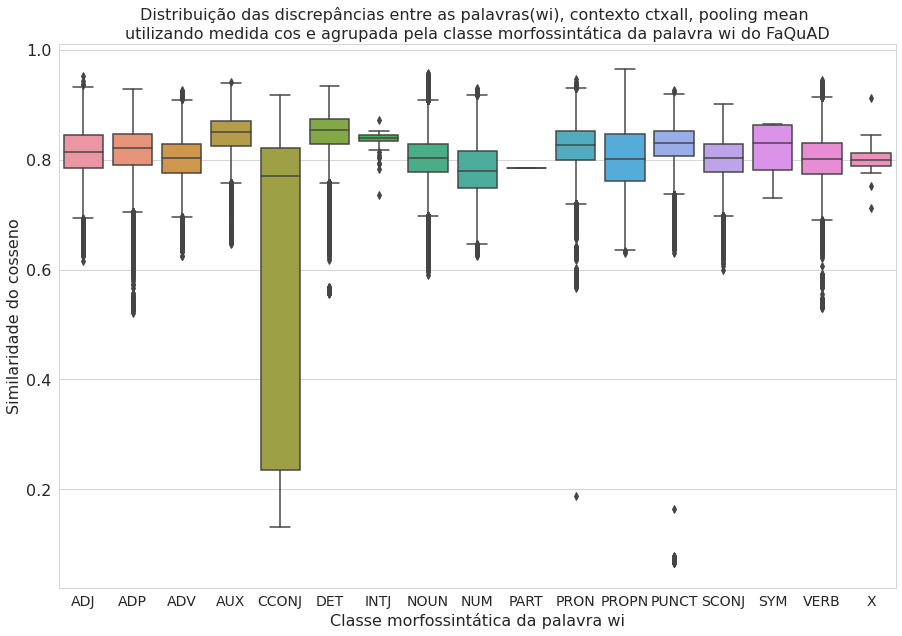

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59752.000000 0.789939 0.045556 0.568146 0.766528 0.795238 0.820368   
ADP   160966.000000 0.816041 0.043465 0.521281 0.789781 0.820697 0.847044   
ADV    21806.000000 0.797797 0.043252 0.624540 0.774967 0.800513 0.826785   
AUX    43680.000000 0.846054 0.037500 0.645666 0.825472 0.850504 0.870971   
CCONJ   6891.000000 0.566703 0.289067 0.131600 0.235538 0.769458 0.821375   
DET   123058.000000 0.845043 0.039243 0.556221 0.822815 0.851798 0.872664   
INTJ     110.000000 0.836295 0.016531 0.736049 0.833568 0.839826 0.843981   
NOUN  227381.000000 0.790187 0.043278 0.583599 0.765731 0.795262 0.820601   
NUM     4317.000000 0.751877 0.075546 0.470366 0.726919 0.765414 0.794940   
PART       1.000000 0.784607      NaN 0.784607 0.784607 0.784607 0.784607   
PRON   82759.000000 0.822087 0.040968 0.187898 0.797055 0.824869 0.850675   
PROPN  41472.000000 0.752286 0.052478 0.520906 0.716624 0.755198 0.789897   
PUNCT  94793.000000 0.826573 0.044691 0.065848 0.805938 0.829694 0.852247   
SCONJ  22150.000000 0.800879 0.039458 0.598614 0.776528 0.802428 0.829157   
SYM        4.000000 0.813556 0.064115 0.729614 0.780405 0.829561 0.862712   
VERB   94772.000000 0.790656 0.044641 0.529941 0.765805 0.793468 0.820579   
X         30.000000 0.801671 0.032276 0.711095 0.788040 0.799491 0.812300   

           max  
pos_i           
ADJ   0.914117  
ADP   0.928786  
ADV   0.911769  
AUX   0.940595  
CCONJ 0.916707  
DET   0.933252  
INTJ  0.871967  
NOUN  0.909032  
NUM   0.926056  
PART  0.784607  
PRON  0.927783  
PROPN 0.921175  
PUNCT 0.925764  
SCONJ 0.901903  
SYM   0.865485  
VERB  0.920090  
X     0.911250

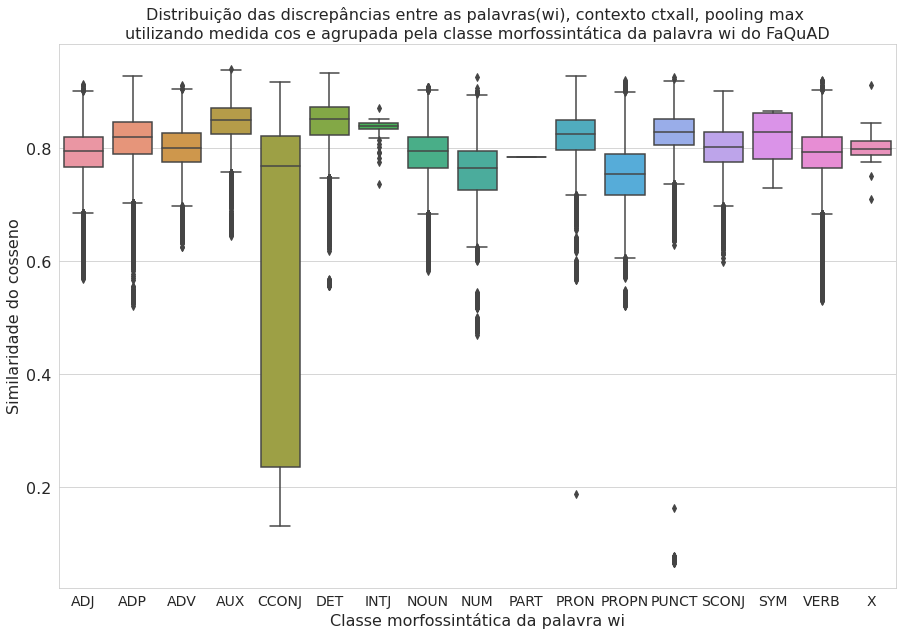

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59752.000000 23.535202 4.644993 11.117695 20.463058 23.304956   
ADP   160966.000000 22.634766 3.058906 13.492750 20.538482 22.352502   
ADV    21806.000000 25.273620 3.918385 13.152172 22.595609 24.782020   
AUX    43680.000000 20.934854 3.332490 12.331011 18.846195 20.499038   
CCONJ   6891.000000 27.547958 6.040574 16.726542 21.986080 25.774618   
DET   123058.000000 20.277364 2.709458 12.935775 18.450106 19.871106   
INTJ     110.000000 21.393723 2.667454 19.357256 20.599376 20.888112   
NOUN  227381.000000 23.441122 3.363813  9.961720 21.418997 23.193701   
NUM     4317.000000 25.995697 4.851192 11.634485 22.167435 26.640909   
PART       1.000000 35.305500      NaN 35.305500 35.305500 35.305500   
PRON   82759.000000 22.237351 3.036151 11.897396 20.277298 22.070314   
PROPN  41472.000000 22.328658 4.518240  9.821314 19.493656 22.437657   
PUNCT  94793.000000 21.172079 2.820077 14.169297 19.598089 20.967913   
SCONJ  22150.000000 24.235903 2.971628 16.207983 22.253008 24.138021   
SYM        4.000000 29.465445 9.412370 19.168531 25.788411 28.348769   
VERB   94772.000000 26.880463 5.228289 10.839937 23.133446 26.268336   
X         30.000000 30.051449 5.645227 23.099888 27.219521 27.796322   

            75%       max  
pos_i                      
ADJ   26.040552 46.635590  
ADP   24.327560 44.729881  
ADV   27.428013 43.814659  
AUX   22.474139 42.787022  
CCONJ 33.889740 40.053658  
DET   21.777452 42.947163  
INTJ  21.244659 41.618610  
NOUN  25.184427 45.588848  
NUM   29.463190 40.773483  
PART  35.305500 35.305500  
PRON  23.917636 45.274540  
PROPN 25.053013 45.530792  
PUNCT 22.377068 46.053673  
SCONJ 25.850925 43.048946  
SYM   32.025803 41.995708  
VERB  30.031562 48.347458  
X     29.977441 46.455635

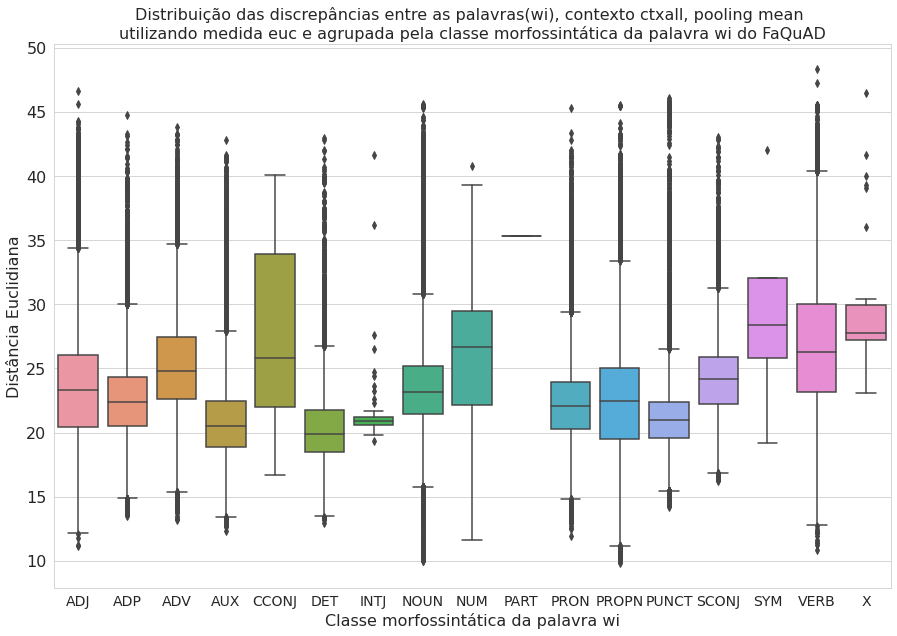

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59752.000000 25.205688 3.807117 15.472905 22.661107 24.411312   
ADP   160966.000000 22.634883 3.059183 13.492750 20.538499 22.352502   
ADV    21806.000000 25.396145 3.797017 16.593966 22.775144 24.883234   
AUX    43680.000000 20.935148 3.332740 12.331011 18.846296 20.499119   
CCONJ   6891.000000 27.806380 6.149275 16.726542 22.123641 26.679354   
DET   123058.000000 20.475867 2.774218 12.935775 18.575157 20.062531   
INTJ     110.000000 21.414335 2.693704 19.357256 20.599376 20.888112   
NOUN  227381.000000 24.211367 3.071373 15.454318 22.114784 23.838757   
NUM     4317.000000 28.406469 5.223051 14.107215 25.416330 27.951143   
PART       1.000000 35.305500      NaN 35.305500 35.305500 35.305500   
PRON   82759.000000 22.314044 3.013488 13.704464 20.337886 22.140257   
PROPN  41472.000000 25.930750 3.345051 14.622686 23.665400 25.595545   
PUNCT  94793.000000 21.172079 2.820077 14.169297 19.598089 20.967913   
SCONJ  22150.000000 24.236115 2.972223 16.207983 22.253008 24.138021   
SYM        4.000000 29.465445 9.412370 19.168531 25.788411 28.348769   
VERB   94772.000000 27.569819 4.804614 14.270814 24.174438 26.853007   
X         30.000000 30.051449 5.645227 23.099888 27.219521 27.796322   

            75%       max  
pos_i                      
ADJ   27.067373 46.635590  
ADP   24.327560 44.729881  
ADV   27.434106 43.814659  
AUX   22.474592 42.787022  
CCONJ 33.989738 40.053658  
DET   22.137773 42.947163  
INTJ  21.244659 41.618610  
NOUN  25.794310 45.588848  
NUM   31.092766 45.183052  
PART  35.305500 35.305500  
PRON  24.010921 45.274540  
PROPN 27.759395 45.530792  
PUNCT 22.377068 46.053673  
SCONJ 25.850925 43.048946  
SYM   32.025803 41.995708  
VERB  30.323083 48.347458  
X     29.977441 46.455635

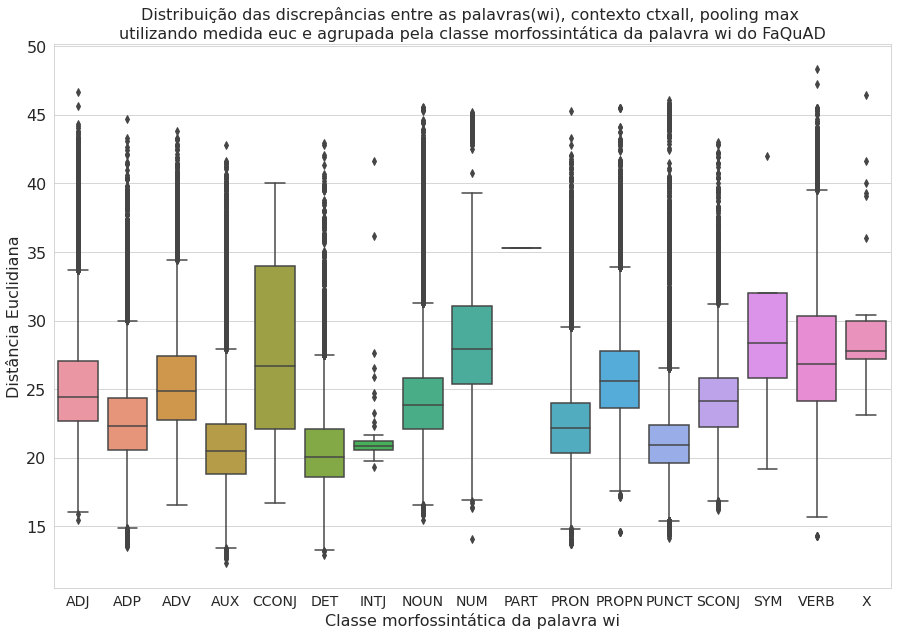

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59752.000000 1104.767602 197.822876  551.888550  973.620375   
ADP   160966.000000 1110.010336 148.650895  660.460700 1008.833215   
ADV    21806.000000 1216.641575 169.258148  622.148600 1099.893675   
AUX    43680.000000 1015.934436 155.436229  587.638400  914.218400   
CCONJ   6891.000000 1107.541132 116.092715  825.432560 1053.728500   
DET   123058.000000  994.489120 131.807397  631.158100  904.937413   
INTJ     110.000000 1035.672571  86.062891  953.030900 1004.813980   
NOUN  227381.000000 1103.906834 146.620825  470.890660 1014.914300   
NUM     4317.000000 1238.326065 212.266347  563.257000 1098.900400   
PART       1.000000 1395.789100        NaN 1395.789100 1395.789100   
PRON   82759.000000 1092.215987 149.244633  574.268300  995.137350   
PROPN  41472.000000 1049.707722 199.051508  478.801480  927.375800   
PUNCT  94793.000000 1043.068945 123.702153  657.454300  967.088560   
SCONJ  22150.000000 1193.337740 141.678518  797.749150 1095.573650   
SYM        4.000000 1285.992438 327.965125  927.599850 1129.174612   
VERB   94772.000000 1246.931451 197.635103  530.690060 1110.051825   
X         30.000000 1319.227557 145.507898 1091.531700 1232.452350   

              50%         75%         max  
pos_i                                      
ADJ   1109.548750 1229.790925 1892.328500  
ADP   1094.758550 1192.327600 1966.389900  
ADV   1207.079100 1319.927150 1937.499600  
AUX    997.576170 1097.185200 1793.155800  
CCONJ 1092.914200 1138.746450 1820.925300  
DET    976.378300 1068.575475 1978.898000  
INTJ  1018.951950 1036.699700 1692.972700  
NOUN  1092.909400 1186.339700 2051.299000  
NUM   1272.438700 1382.556400 1765.213100  
PART  1395.789100 1395.789100 1395.789100  
PRON  1086.468000 1181.353050 2018.999000  
PROPN 1056.012600 1177.073625 2041.056200  
PUNCT 1037.642100 1111.239700 1900.172900  
SCONJ 1192.572900 1279.217525 1827.363600  
SYM   1249.595400 1406.413225 1717.179100  
VERB  1239.520900 1375.950725 2106.689700  
X     1278.307800 1353.136425 1691.823400

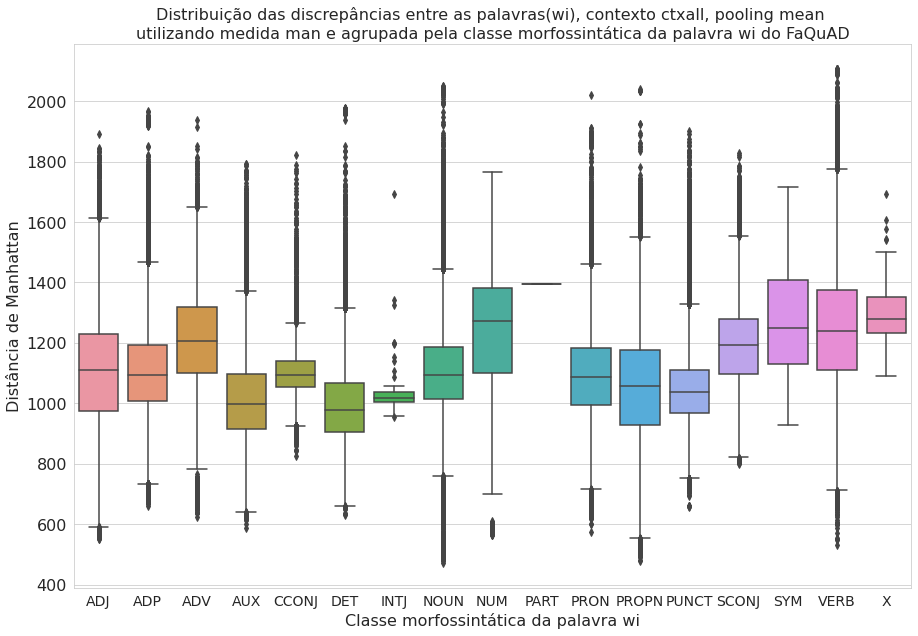

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59752.000000 1183.544242 157.957226  732.782840 1075.443275   
ADP   160966.000000 1110.019151 148.670231  660.460700 1008.834578   
ADV    21806.000000 1222.854359 162.371620  808.018700 1107.779300   
AUX    43680.000000 1015.949520 155.453220  587.638400  914.235725   
CCONJ   6891.000000 1118.862294 133.525413  825.432560 1056.177850   
DET   123058.000000 1003.781390 134.132816  631.158100  911.336810   
INTJ     110.000000 1036.522726  87.690056  953.030900 1004.813980   
NOUN  227381.000000 1140.346628 135.461671  740.998000 1045.189500   
NUM     4317.000000 1363.167645 270.851117  700.894170 1221.580800   
PART       1.000000 1395.789100        NaN 1395.789100 1395.789100   
PRON   82759.000000 1095.511811 147.880356  682.545700  998.534580   
PROPN  41472.000000 1227.845760 163.154212  708.553470 1117.103050   
PUNCT  94793.000000 1043.068945 123.702153  657.454300  967.088560   
SCONJ  22150.000000 1193.353003 141.714538  797.749150 1095.573650   
SYM        4.000000 1285.992438 327.965125  927.599850 1129.174612   
VERB   94772.000000 1280.562900 182.236136  676.948700 1154.361675   
X         30.000000 1319.227557 145.507898 1091.531700 1232.452350   

              50%         75%         max  
pos_i                                      
ADJ   1152.623800 1270.940950 1892.328500  
ADP   1094.758550 1192.327600 1966.389900  
ADV   1211.180300 1320.949975 1937.499600  
AUX    997.585450 1097.197400 1793.155800  
CCONJ 1095.612300 1141.646850 1820.925300  
DET    985.986200 1083.753425 1978.898000  
INTJ  1018.951950 1036.699700 1692.972700  
NOUN  1122.802600 1215.325300 2051.299000  
NUM   1330.211400 1460.577600 2379.885700  
PART  1395.789100 1395.789100 1395.789100  
PRON  1089.348800 1184.531700 2018.999000  
PROPN 1206.613200 1311.213125 2041.056200  
PUNCT 1037.642100 1111.239700 1900.172900  
SCONJ 1192.572900 1279.217525 1827.363600  
SYM   1249.595400 1406.413225 1717.179100  
VERB  1267.521050 1395.247050 2171.871000  
X     1278.307800 1353.136425 1691.823400

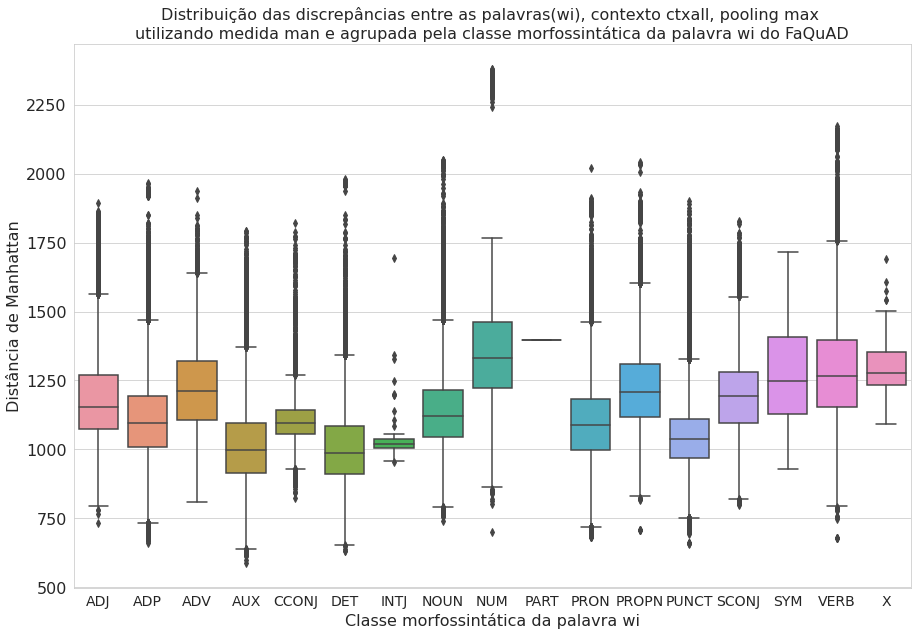

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59752.000000 0.830911 0.047259 0.566070 0.805759 0.838695 0.863907   
ADP   160966.000000 0.755192 0.048013 0.447261 0.726311 0.760509 0.788878   
ADV    21806.000000 0.759769 0.057458 0.527914 0.724287 0.757011 0.791215   
AUX    43680.000000 0.781682 0.043350 0.569901 0.755231 0.782487 0.807878   
CCONJ   6891.000000 0.509407 0.284739 0.091332 0.174523 0.700526 0.756830   
DET   123058.000000 0.784793 0.042391 0.527788 0.759203 0.789378 0.815157   
INTJ     110.000000 0.768533 0.023872 0.652833 0.758511 0.766767 0.775132   
NOUN  227381.000000 0.824878 0.046484 0.553994 0.799501 0.830655 0.857666   
NUM     4317.000000 0.787444 0.055249 0.568827 0.756712 0.793280 0.828252   
PART       1.000000 0.842253      NaN 0.842253 0.842253 0.842253 0.842253   
PRON   82759.000000 0.746611 0.042296 0.124928 0.721259 0.751148 0.775986   
PROPN  41472.000000 0.815958 0.053473 0.566501 0.780049 0.817046 0.855240   
PUNCT  94793.000000 0.816955 0.049038 0.090934 0.789587 0.817494 0.843543   
SCONJ  22150.000000 0.738153 0.046543 0.520808 0.707504 0.736632 0.770599   
SYM        4.000000 0.845513 0.051487 0.789912 0.808173 0.847845 0.885185   
VERB   94772.000000 0.814885 0.051488 0.508645 0.786530 0.821845 0.849867   
X         30.000000 0.838398 0.037453 0.751955 0.826048 0.841257 0.856856   

           max  
pos_i           
ADJ   0.950571  
ADP   0.925652  
ADV   0.941253  
AUX   0.936306  
CCONJ 0.870526  
DET   0.928719  
INTJ  0.895361  
NOUN  0.954357  
NUM   0.914468  
PART  0.842253  
PRON  0.938594  
PROPN 0.952024  
PUNCT 1.000000  
SCONJ 0.905691  
SYM   0.896452  
VERB  0.937884  
X     0.932661

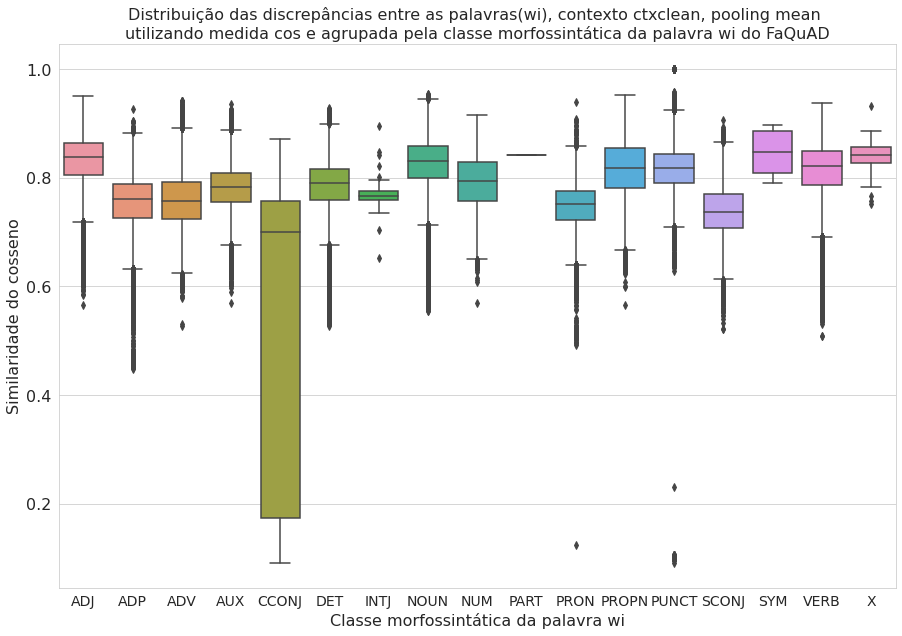

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59752.000000 0.806490 0.060798 0.550128 0.771781 0.816427 0.850864   
ADP   160966.000000 0.755190 0.048012 0.447261 0.726308 0.760507 0.788875   
ADV    21806.000000 0.758072 0.055968 0.527914 0.724021 0.756252 0.788079   
AUX    43680.000000 0.781677 0.043351 0.569901 0.755231 0.782482 0.807878   
CCONJ   6891.000000 0.504857 0.284802 0.091332 0.174523 0.700526 0.756830   
DET   123058.000000 0.782115 0.042593 0.527788 0.756293 0.787037 0.812880   
INTJ     110.000000 0.768293 0.025148 0.626371 0.758511 0.766767 0.775132   
NOUN  227381.000000 0.813747 0.055911 0.553994 0.784017 0.823898 0.853898   
NUM     4317.000000 0.757553 0.090795 0.442471 0.730285 0.778599 0.820120   
PART       1.000000 0.842253      NaN 0.842253 0.842253 0.842253 0.842253   
PRON   82759.000000 0.745640 0.042514 0.124928 0.720481 0.750397 0.774860   
PROPN  41472.000000 0.764194 0.071504 0.478973 0.715613 0.767589 0.817392   
PUNCT  94793.000000 0.816955 0.049038 0.090934 0.789587 0.817494 0.843543   
SCONJ  22150.000000 0.738149 0.046541 0.520808 0.707504 0.736617 0.770590   
SYM        4.000000 0.845513 0.051487 0.789912 0.808173 0.847845 0.885185   
VERB   94772.000000 0.805361 0.057376 0.508645 0.772162 0.812929 0.845543   
X         30.000000 0.838398 0.037453 0.751955 0.826048 0.841257 0.856856   

           max  
pos_i           
ADJ   0.950571  
ADP   0.925652  
ADV   0.941253  
AUX   0.936306  
CCONJ 0.870526  
DET   0.915458  
INTJ  0.895361  
NOUN  0.954357  
NUM   0.914468  
PART  0.842253  
PRON  0.938594  
PROPN 0.952024  
PUNCT 1.000000  
SCONJ 0.905691  
SYM   0.896452  
VERB  0.937884  
X     0.932661

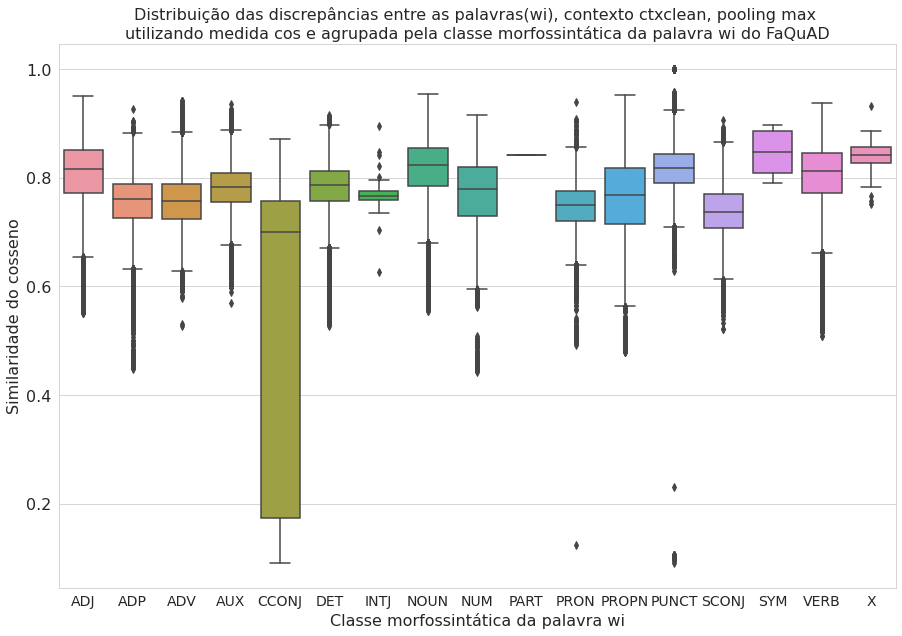

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59752.000000 22.522560 4.206450 11.086174 19.672438 21.852043   
ADP   160966.000000 25.894219 2.922331 16.351160 23.919781 25.561525   
ADV    21806.000000 27.288080 3.522905 12.530858 25.193870 26.921056   
AUX    43680.000000 24.614887 2.959758 14.345037 22.916993 24.418746   
CCONJ   6891.000000 30.797598 5.804026 20.440996 25.485939 28.720623   
DET   123058.000000 23.913146 2.504506 13.549007 22.202329 23.672860   
INTJ     110.000000 25.135301 1.789892 20.913139 24.495668 24.928855   
NOUN  227381.000000 22.119868 3.401137 11.572813 19.923035 21.703913   
NUM     4317.000000 25.734349 3.561905 15.770556 23.267687 25.550762   
PART       1.000000 31.648138      NaN 31.648138 31.648138 31.648138   
PRON   82759.000000 26.430571 2.583359 13.499160 24.685818 26.184267   
PROPN  41472.000000 21.807303 3.638369 11.065921 19.565434 21.729012   
PUNCT  94793.000000 21.762954 3.032844  0.000000 20.246916 21.850943   
SCONJ  22150.000000 27.515424 2.947949 18.216841 25.642951 27.348723   
SYM        4.000000 27.435622 8.533051 18.092180 23.959991 26.437204   
VERB   94772.000000 25.915977 4.786100 11.666943 22.567921 25.296253   
X         30.000000 27.510924 5.848645 19.580427 24.554292 25.263191   

            75%       max  
pos_i                      
ADJ   24.813756 47.264008  
ADP   27.466657 47.774288  
ADV   29.238848 48.025467  
AUX   26.092633 46.516415  
CCONJ 37.054276 43.651485  
DET   25.425723 46.906673  
INTJ  25.396775 38.820145  
NOUN  23.822247 47.667095  
NUM   28.163010 40.807705  
PART  31.648138 31.648138  
PRON  27.852988 48.006042  
PROPN 23.822977 46.179489  
PUNCT 23.387133 44.315536  
SCONJ 29.193248 46.080151  
SYM   29.912835 38.775898  
VERB  28.469099 48.667980  
X     27.468952 44.452370

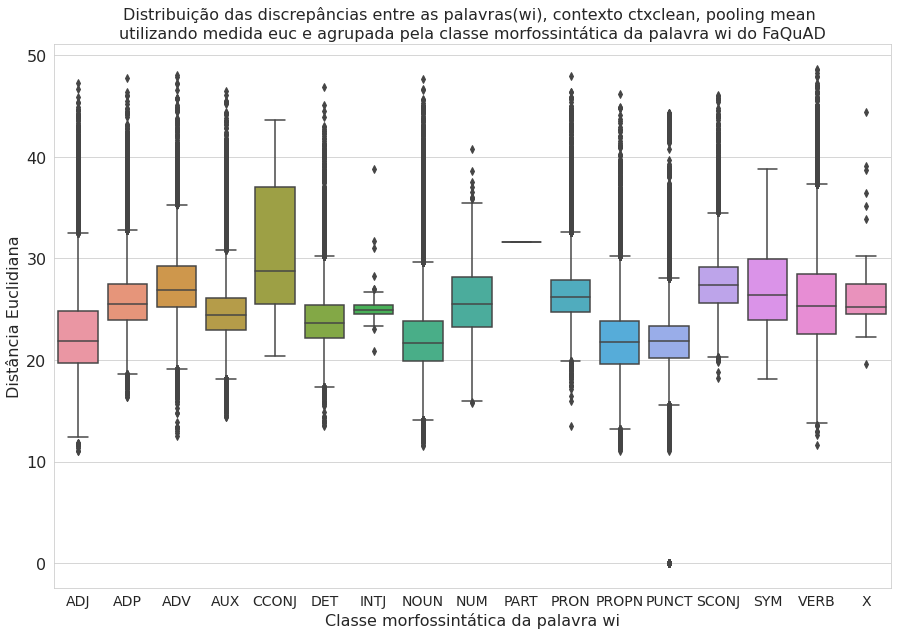

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59752.000000 24.185411 4.036926 12.384276 21.430875 23.687866   
ADP   160966.000000 25.894339 2.922495 16.351160 23.919781 25.561525   
ADV    21806.000000 27.405192 3.369584 13.175279 25.313410 26.937547   
AUX    43680.000000 24.615170 2.959783 14.345037 22.917207 24.419126   
CCONJ   6891.000000 31.044065 5.838870 20.440996 25.598260 29.230434   
DET   123058.000000 24.094657 2.499853 16.404987 22.369261 23.834298   
INTJ     110.000000 25.151616 1.851462 20.913139 24.495668 24.928855   
NOUN  227381.000000 22.869682 3.646337 11.572813 20.362503 22.346411   
NUM     4317.000000 28.002080 5.161479 18.835592 24.671503 26.827402   
PART       1.000000 31.648138      NaN 31.648138 31.648138 31.648138   
PRON   82759.000000 26.495331 2.578536 13.499160 24.752666 26.219048   
PROPN  41472.000000 25.288798 4.096852 13.299506 22.360801 25.032215   
PUNCT  94793.000000 21.762954 3.032844  0.000000 20.246916 21.850943   
SCONJ  22150.000000 27.515646 2.948276 18.216841 25.642951 27.348723   
SYM        4.000000 27.435622 8.533051 18.092180 23.959991 26.437204   
VERB   94772.000000 26.595495 4.592628 13.860520 23.625104 26.033122   
X         30.000000 27.510924 5.848645 19.580427 24.554292 25.263191   

            75%       max  
pos_i                      
ADJ   26.363197 47.264008  
ADP   27.466657 47.774288  
ADV   29.242824 48.025467  
AUX   26.092633 46.516415  
CCONJ 37.141268 43.651485  
DET   25.613653 46.906673  
INTJ  25.396775 38.820145  
NOUN  24.873760 47.667095  
NUM   29.976664 47.231911  
PART  31.648138 31.648138  
PRON  27.915409 48.006042  
PROPN 27.765225 46.179489  
PUNCT 23.387133 44.315536  
SCONJ 29.193248 46.080151  
SYM   29.912835 38.775898  
VERB  29.007051 48.667980  
X     27.468952 44.452370

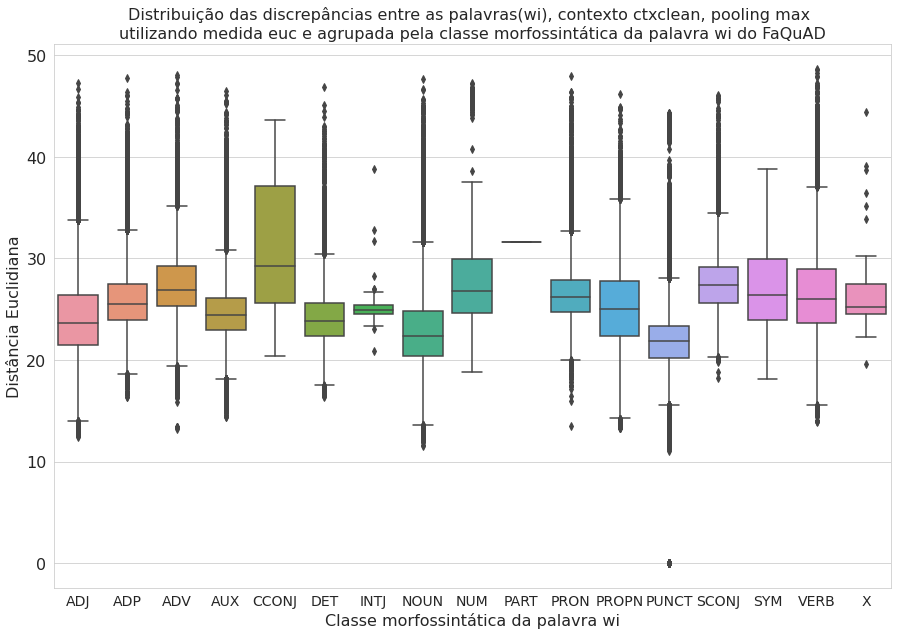

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59752.000000 1056.970430 185.683974  530.128300  925.739430   
ADP   160966.000000 1260.477634 142.943226  783.303200 1163.614175   
ADV    21806.000000 1313.257035 163.540553  613.312300 1214.744775   
AUX    43680.000000 1185.266452 137.066183  696.970300 1103.329700   
CCONJ   6891.000000 1236.777209 115.290298  985.342350 1170.996700   
DET   123058.000000 1161.370604 118.599565  640.704160 1080.416875   
INTJ     110.000000 1208.766351  64.573769 1029.522500 1182.669175   
NOUN  227381.000000 1043.053722 153.409081  565.882750  942.843900   
NUM     4317.000000 1228.797456 171.305571  752.305000 1115.992200   
PART       1.000000 1285.145400        NaN 1285.145400 1285.145400   
PRON   82759.000000 1287.530635 126.428002  649.738160 1200.776800   
PROPN  41472.000000 1024.218985 160.180099  537.524400  922.371675   
PUNCT  94793.000000 1057.023883 139.697462    0.000000  984.968000   
SCONJ  22150.000000 1348.175903 141.579987  901.832500 1254.958800   
SYM        4.000000 1204.848435 307.839956  877.670040 1021.245660   
VERB   94772.000000 1207.178502 190.113750  571.876700 1073.144875   
X         30.000000 1229.125420 166.855098  937.166500 1124.221900   

              50%         75%         max  
pos_i                                      
ADJ   1033.059200 1169.435175 1966.202900  
ADP   1241.248500 1335.482800 2102.897500  
ADV   1304.870100 1412.316475 2073.364300  
AUX   1173.859400 1260.581700 2002.674100  
CCONJ 1212.490400 1270.651850 1976.780500  
DET   1150.925600 1230.843850 2148.609900  
INTJ  1202.436500 1225.600975 1608.603900  
NOUN  1022.403500 1122.976800 2159.257300  
NUM   1224.910400 1340.884900 1791.512700  
PART  1285.145400 1285.145400 1285.145400  
PRON  1277.436000 1360.929350 2089.236300  
PROPN 1021.090950 1110.045125 2101.297900  
PUNCT 1063.704000 1139.686400 1820.576400  
SCONJ 1344.321550 1436.039700 2023.004900  
SYM   1172.336400 1355.939175 1597.050900  
VERB  1195.580850 1321.551550 2144.629400  
X     1185.716600 1269.691075 1625.444800

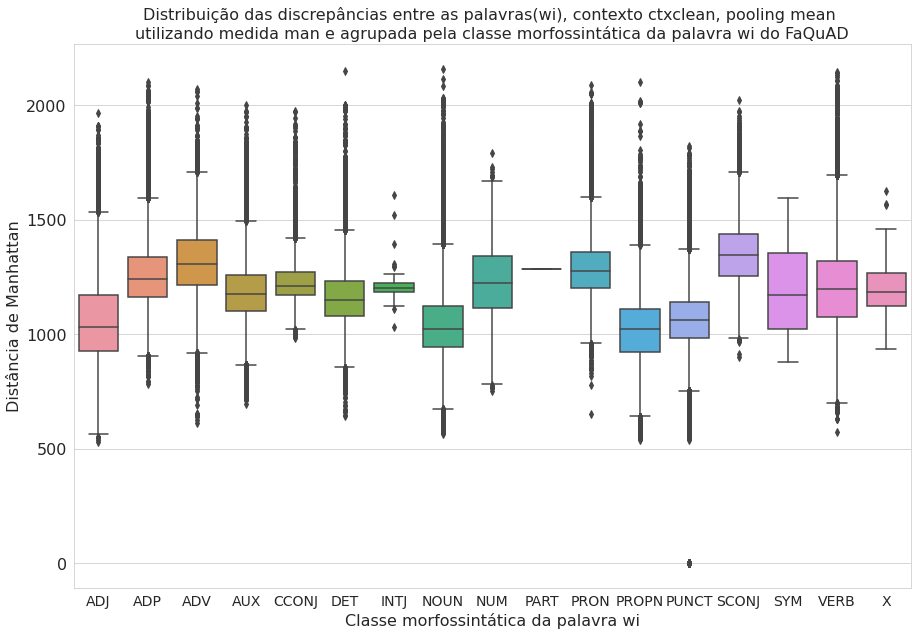

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59752.000000 1134.028093 177.734056  599.437870 1015.439062   
ADP   160966.000000 1260.486543 142.954126  783.303200 1163.614175   
ADV    21806.000000 1319.112215 155.360640  639.692260 1219.548000   
AUX    43680.000000 1185.280918 137.071958  696.970300 1103.340025   
CCONJ   6891.000000 1247.407353 126.548600  985.342350 1174.555100   
DET   123058.000000 1169.786947 117.158200  792.279100 1088.940975   
INTJ     110.000000 1209.457238  68.244999 1029.522500 1182.669175   
NOUN  227381.000000 1077.987351 166.484750  565.882750  962.186770   
NUM     4317.000000 1345.939146 273.291909  921.451230 1181.437000   
PART       1.000000 1285.145400        NaN 1285.145400 1285.145400   
PRON   82759.000000 1290.241620 125.610873  649.738160 1202.729950   
PROPN  41472.000000 1192.973231 201.005624  635.775000 1050.716550   
PUNCT  94793.000000 1057.023883 139.697462    0.000000  984.968000   
SCONJ  22150.000000 1348.191212 141.597930  901.832500 1254.958800   
SYM        4.000000 1204.848435 307.839956  877.670040 1021.245660   
VERB   94772.000000 1239.852757 187.649065  666.508900 1119.452175   
X         30.000000 1229.125420 166.855098  937.166500 1124.221900   

              50%         75%         max  
pos_i                                      
ADJ   1111.768650 1234.947450 1966.202900  
ADP   1241.248500 1335.486075 2102.897500  
ADV   1305.637000 1412.492750 2073.364300  
AUX   1173.861900 1260.581700 2002.674100  
CCONJ 1215.507200 1274.685800 1976.780500  
DET   1158.783300 1238.808425 2148.609900  
INTJ  1202.436500 1225.600975 1608.603900  
NOUN  1052.503400 1173.065300 2159.257300  
NUM   1280.988800 1424.768100 2416.819300  
PART  1285.145400 1285.145400 1285.145400  
PRON  1279.240000 1363.368200 2089.236300  
PROPN 1173.859250 1302.800375 2101.297900  
PUNCT 1063.704000 1139.686400 1820.576400  
SCONJ 1344.321550 1436.045325 2023.004900  
SYM   1172.336400 1355.939175 1597.050900  
VERB  1227.332000 1348.027425 2196.946800  
X     1185.716600 1269.691075 1625.444800

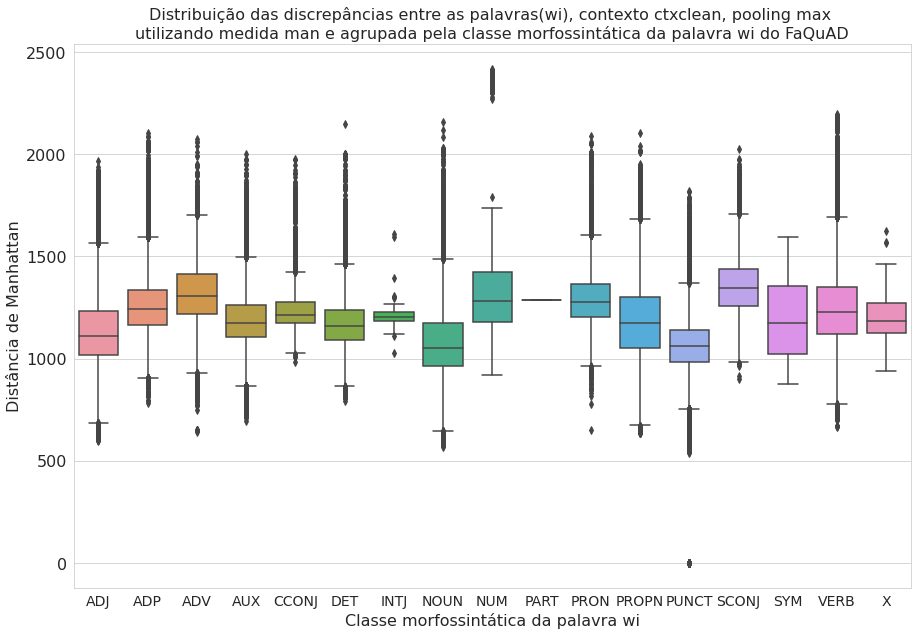

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    50902.000000 0.659397 0.073200 0.363845 0.607036 0.660010 0.714269   
ADP   142281.000000 0.640910 0.082169 0.321689 0.587394 0.649467 0.700699   
ADV    20725.000000 0.719721 0.060074 0.390803 0.684367 0.728172 0.762162   
AUX    43680.000000 0.929459 0.060000 0.698323 0.888877 0.914718 1.000000   
CCONJ   6244.000000 0.422128 0.268196 0.040933 0.129329 0.550581 0.660577   
DET   106941.000000 0.708277 0.075190 0.392841 0.658441 0.710991 0.764663   
INTJ      12.000000 0.657178 0.103759 0.539704 0.567135 0.642461 0.721716   
NOUN  201427.000000 0.637889 0.071745 0.345415 0.590356 0.642582 0.690285   
NUM     4219.000000 0.627778 0.067945 0.452784 0.575308 0.624615 0.672791   
PART       1.000000 0.523553      NaN 0.523553 0.523553 0.523553 0.523553   
PRON   76573.000000 0.702613 0.064600 0.078024 0.658425 0.703500 0.749735   
PROPN  37246.000000 0.601035 0.083100 0.325576 0.543237 0.603053 0.659567   
PUNCT  83838.000000 0.690901 0.066789 0.032986 0.650103 0.699130 0.739357   
SCONJ  21600.000000 0.701616 0.067126 0.468659 0.653858 0.709430 0.753482   
SYM        3.000000 0.682329 0.076697 0.632472 0.638171 0.643870 0.707258   
VERB   94772.000000 0.920410 0.062605 0.612299 0.878380 0.922367 1.000000   
X         25.000000 0.619470 0.046479 0.573120 0.590154 0.602896 0.633728   

           max  
pos_i           
ADJ   0.904411  
ADP   0.860217  
ADV   0.899258  
AUX   1.000000  
CCONJ 0.834850  
DET   0.895027  
INTJ  0.835278  
NOUN  0.933831  
NUM   0.826717  
PART  0.523553  
PRON  0.878858  
PROPN 0.895054  
PUNCT 0.843460  
SCONJ 0.873806  
SYM   0.770646  
VERB  1.000000  
X     0.750904

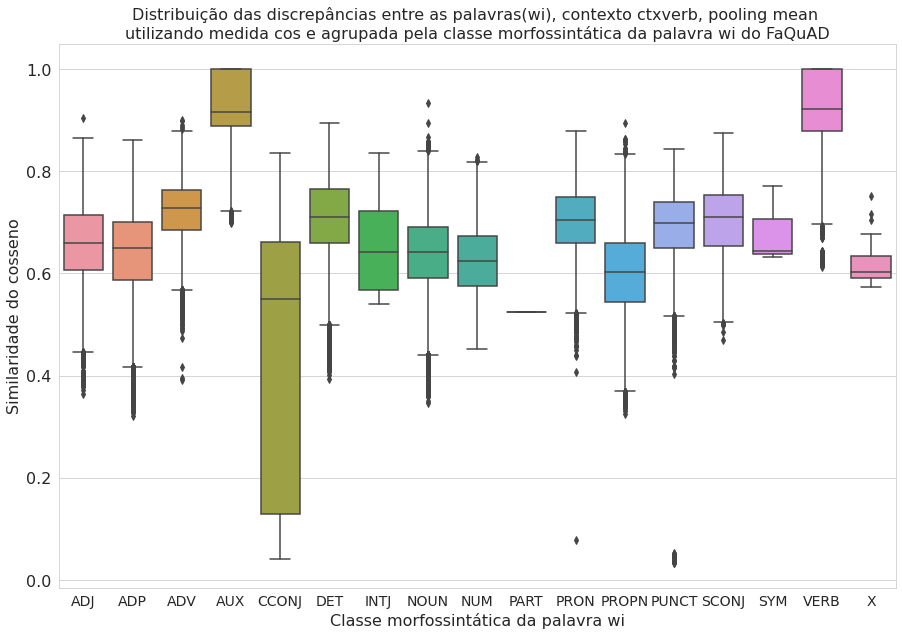

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    50902.000000 0.639732 0.085509 0.303687 0.581061 0.645813 0.704707   
ADP   142281.000000 0.640909 0.082169 0.321689 0.587394 0.649467 0.700699   
ADV    20725.000000 0.718686 0.061464 0.390803 0.682772 0.727825 0.762123   
AUX    43680.000000 0.929454 0.060007 0.698323 0.888874 0.914718 1.000000   
CCONJ   6244.000000 0.417372 0.267508 0.040933 0.129329 0.540063 0.660577   
DET   106941.000000 0.705882 0.076230 0.392841 0.655776 0.708425 0.762949   
INTJ      12.000000 0.655130 0.105795 0.539704 0.549413 0.642461 0.721716   
NOUN  201427.000000 0.628327 0.075686 0.278454 0.576887 0.633582 0.684499   
NUM     4219.000000 0.603283 0.095442 0.294368 0.548773 0.603558 0.671610   
PART       1.000000 0.523553      NaN 0.523553 0.523553 0.523553 0.523553   
PRON   76573.000000 0.701691 0.064468 0.078024 0.657443 0.702961 0.749551   
PROPN  37246.000000 0.558723 0.082845 0.296349 0.502978 0.562217 0.617854   
PUNCT  83838.000000 0.690901 0.066789 0.032986 0.650103 0.699130 0.739357   
SCONJ  21600.000000 0.701612 0.067123 0.468659 0.653858 0.709430 0.753472   
SYM        3.000000 0.682329 0.076697 0.632472 0.638171 0.643870 0.707258   
VERB   94772.000000 0.910742 0.076560 0.506867 0.869042 0.920595 1.000000   
X         25.000000 0.619470 0.046479 0.573120 0.590154 0.602896 0.633728   

           max  
pos_i           
ADJ   0.904411  
ADP   0.860217  
ADV   0.899258  
AUX   1.000000  
CCONJ 0.834850  
DET   0.895027  
INTJ  0.835278  
NOUN  0.933831  
NUM   0.826717  
PART  0.523553  
PRON  0.878858  
PROPN 0.895054  
PUNCT 0.843460  
SCONJ 0.873806  
SYM   0.770646  
VERB  1.000000  
X     0.750904

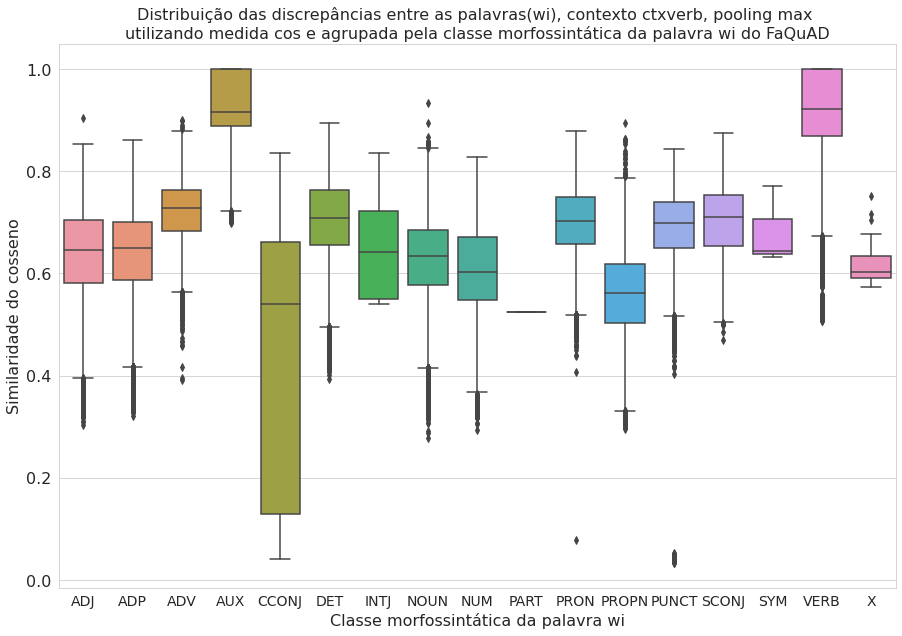

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    50902.000000 33.536258 4.894214 17.498550 30.175176 33.199001   
ADP   142281.000000 34.189218 5.461334 20.668961 30.329548 33.272163   
ADV    20725.000000 30.847278 4.505905 20.175409 27.451563 30.342411   
AUX    43680.000000 11.695648 9.088693  0.000000  0.000000 15.970056   
CCONJ   6244.000000 38.246873 7.606589 21.788095 31.855373 38.883116   
DET   106941.000000 30.544652 5.687302 16.572277 26.358255 29.865891   
INTJ      12.000000 36.265823 6.851680 22.378105 31.002158 37.730228   
NOUN  201427.000000 34.322311 4.950207 15.457245 30.855698 33.676716   
NUM     4219.000000 36.644592 4.981919 22.240763 33.326654 36.445847   
PART       1.000000 46.923450      NaN 46.923450 46.923450 46.923450   
PRON   76573.000000 31.022493 5.113365 18.846874 27.159395 30.740316   
PROPN  37246.000000 35.501072 5.124792 19.038218 32.000927 35.128355   
PUNCT  83838.000000 31.157986 5.332391 20.395153 27.191636 29.980653   
SCONJ  21600.000000 31.352403 5.201989 18.732771 27.579848 30.451610   
SYM        3.000000 36.118153 9.907854 25.509417 31.611474 37.713531   
VERB   94772.000000 14.439000 9.482429  0.000000  0.000000 17.502950   
X         25.000000 39.514877 3.632829 30.381210 38.079563 38.488373   

            75%       max  
pos_i                      
ADJ   36.418736 56.641441  
ADP   37.315479 59.446781  
ADV   33.492115 57.533535  
AUX   18.696131 38.323238  
CCONJ 43.806858 63.810551  
DET   34.122135 56.630192  
INTJ  39.896552 46.604237  
NOUN  37.083086 59.515274  
NUM   39.491415 51.823425  
PART  46.923450 46.923450  
PRON  34.257557 56.758392  
PROPN 38.429114 58.293034  
PUNCT 34.123062 54.080257  
SCONJ 34.376134 51.628918  
SYM   41.422522 45.131512  
VERB  20.934064 43.155338  
X     40.577564 49.174664

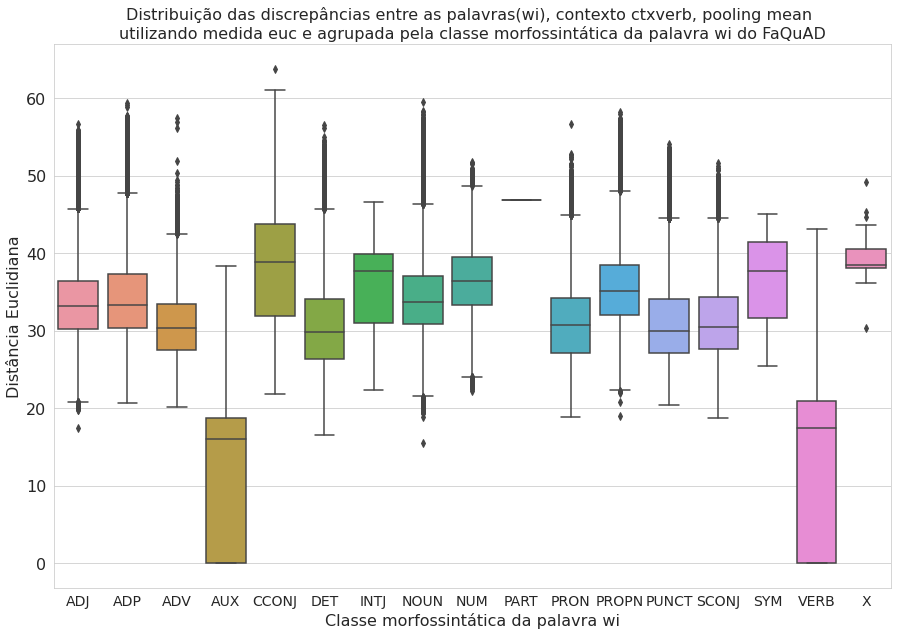

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg       std       min       25%       50%  \
pos_i                                                                   
ADJ    50902.000000 34.674234  5.030634 17.498550 31.389087 34.223825   
ADP   142281.000000 34.189289  5.461354 20.668961 30.329672 33.272224   
ADV    20725.000000 30.908103  4.553794 20.175409 27.473841 30.377243   
AUX    43680.000000 11.696016  9.089036  0.000000  0.000000 15.970534   
CCONJ   6244.000000 38.498462  7.505860 21.788095 32.279104 39.530790   
DET   106941.000000 30.687729  5.732399 16.572277 26.469877 30.024483   
INTJ      12.000000 36.387336  6.998684 22.378105 31.002158 37.730228   
NOUN  201427.000000 34.875834  4.984727 15.457245 31.294722 34.310749   
NUM     4219.000000 38.369458  6.166585 22.240763 34.391836 37.789539   
PART       1.000000 46.923450       NaN 46.923450 46.923450 46.923450   
PRON   76573.000000 31.083636  5.085433 18.917839 27.163397 30.808807   
PROPN  37246.000000 37.929111  5.079459 19.038218 34.264561 37.300041   
PUNCT  83838.000000 31.157986  5.332391 20.395153 27.191636 29.980653   
SCONJ  21600.000000 31.352655  5.202014 18.732771 27.579848 30.451784   
SYM        3.000000 36.118153  9.907854 25.509417 31.611474 37.713531   
VERB   94772.000000 15.267254 10.008140  0.000000  0.000000 17.948420   
X         25.000000 39.514877  3.632829 30.381210 38.079563 38.488373   

            75%       max  
pos_i                      
ADJ   37.729730 60.623959  
ADP   37.315510 59.446781  
ADV   33.561630 57.533535  
AUX   18.696235 38.323238  
CCONJ 43.816662 63.810551  
DET   34.292366 56.630192  
INTJ  39.896552 46.604237  
NOUN  37.735640 61.417854  
NUM   41.055553 57.909939  
PART  46.923450 46.923450  
PRON  34.310841 56.758392  
PROPN 40.896691 60.864876  
PUNCT 34.123062 54.080257  
SCONJ 34.376618 51.628918  
SYM   41.422522 45.131512  
VERB  22.172814 43.155338  
X     40.577564 49.174664

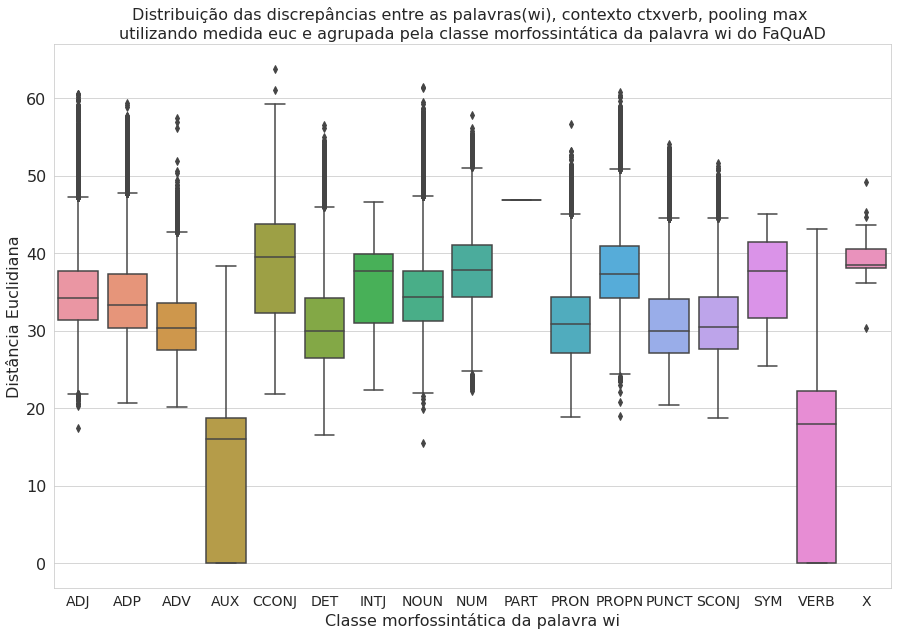

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    50902.000000 1574.696854 205.179829  838.093750 1430.431793   
ADP   142281.000000 1635.713981 218.682257  956.104004 1478.899902   
ADV    20725.000000 1489.478776 207.338957  982.063049 1332.189209   
AUX    43680.000000  553.390491 429.773696    0.000000    0.000000   
CCONJ   6244.000000 1586.051179 195.240534 1070.152832 1454.962616   
DET   106941.000000 1456.084096 235.533595  804.456909 1284.295410   
INTJ      12.000000 1682.930522 276.147174 1079.265381 1502.761719   
NOUN  201427.000000 1606.135672 203.736012  705.875366 1463.132568   
NUM     4219.000000 1736.655930 200.716249 1103.887939 1609.852234   
PART       1.000000 1962.150635        NaN 1962.150635 1962.150635   
PRON   76573.000000 1489.269967 223.035275  887.338440 1324.317993   
PROPN  37246.000000 1654.771700 206.842591  908.270142 1509.563843   
PUNCT  83838.000000 1488.067310 209.595580  987.958191 1332.211243   
SCONJ  21600.000000 1509.715370 222.730182  917.786926 1345.788269   
SYM        3.000000 1665.955404 393.841777 1217.152466 1521.961243   
VERB   94772.000000  682.083490 445.599042    0.000000    0.000000   
X         25.000000 1770.590938  99.962083 1459.607910 1734.453125   

              50%         75%         max  
pos_i                                      
ADJ   1574.408813 1706.491211 2515.101318  
ADP   1614.096313 1773.764648 2475.632812  
ADV   1471.837769 1624.961426 2534.479004  
AUX    760.375671  874.910019 1591.689209  
CCONJ 1581.429871 1711.915527 2281.735840  
DET   1441.680664 1612.225220 2323.927246  
INTJ  1724.694946 1864.172546 2061.597168  
NOUN  1589.237183 1736.048828 2540.894043  
NUM   1731.230957 1868.708679 2335.476074  
PART  1962.150635 1962.150635 1962.150635  
PRON  1484.699463 1637.257080 2502.233887  
PROPN 1650.210144 1781.377228 2535.748535  
PUNCT 1450.342163 1618.536133 2328.641113  
SCONJ 1476.543091 1653.148193 2257.185303  
SYM   1826.770020 1890.356873 1953.943726  
VERB   828.563324  989.959991 1984.511963  
X     1760.786377 1818.398682 2045.937500

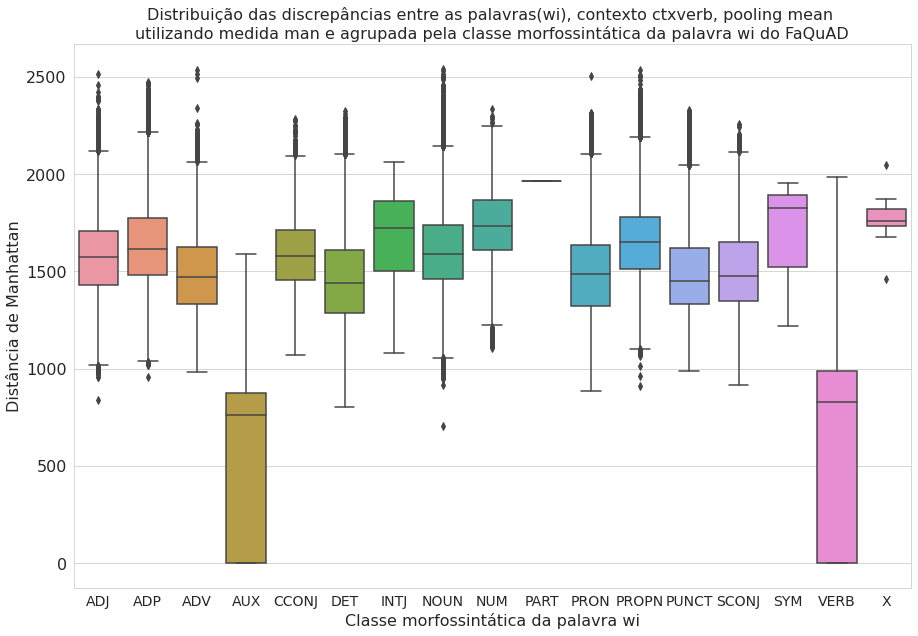

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    50902.000000 1625.808174 207.766053  838.093750 1488.941010   
ADP   142281.000000 1635.719788 218.685905  956.104004 1478.903320   
ADV    20725.000000 1492.346376 209.666913  982.063049 1333.132935   
AUX    43680.000000  553.408323 429.792511    0.000000    0.000000   
CCONJ   6244.000000 1596.592638 192.377582 1070.152832 1466.844299   
DET   106941.000000 1462.410599 236.816318  804.456909 1289.845459   
INTJ      12.000000 1687.380961 280.603498 1079.265381 1502.761719   
NOUN  201427.000000 1631.146237 204.910248  705.875366 1484.837646   
NUM     4219.000000 1822.806663 266.234144 1103.887939 1647.587158   
PART       1.000000 1962.150635        NaN 1962.150635 1962.150635   
PRON   76573.000000 1491.886492 221.440489  887.338440 1324.477051   
PROPN  37246.000000 1767.036608 207.831364  908.270142 1618.724670   
PUNCT  83838.000000 1488.067310 209.595580  987.958191 1332.211243   
SCONJ  21600.000000 1509.730714 222.733847  917.786926 1345.788269   
SYM        3.000000 1665.955404 393.841777 1217.152466 1521.961243   
VERB   94772.000000  721.841832 472.313747    0.000000    0.000000   
X         25.000000 1770.590938  99.962083 1459.607910 1734.453125   

              50%         75%         max  
pos_i                                      
ADJ   1615.723816 1761.050873 2515.101318  
ADP   1614.096313 1773.766479 2475.632812  
ADV   1473.476685 1628.008545 2534.479004  
AUX    760.379211  874.918320 1591.689209  
CCONJ 1589.121399 1722.619019 2281.735840  
DET   1448.744995 1619.040649 2323.927246  
INTJ  1724.694946 1877.523865 2061.597168  
NOUN  1616.906250 1763.407227 2540.894043  
NUM   1810.120361 1943.320801 2741.983398  
PART  1962.150635 1962.150635 1962.150635  
PRON  1487.522217 1639.339111 2502.233887  
PROPN 1748.595703 1893.460541 2583.186035  
PUNCT 1450.342163 1618.536133 2328.641113  
SCONJ 1476.550354 1653.160248 2257.185303  
SYM   1826.770020 1890.356873 1953.943726  
VERB   846.733643 1054.827789 2228.688477  
X     1760.786377 1818.398682 2045.937500

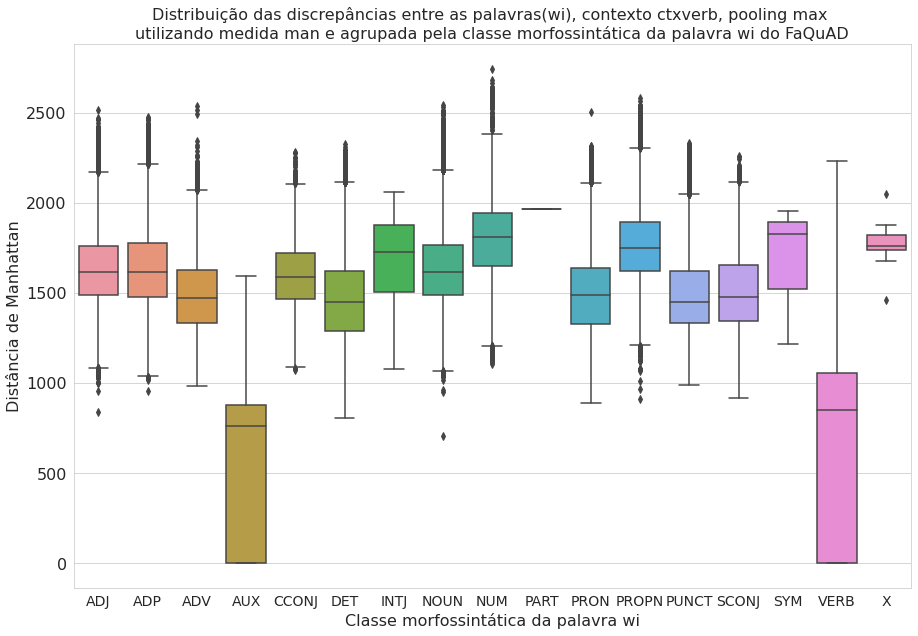

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59064.000000 0.731479 0.063501 0.403479 0.695529 0.738348 0.774032   
ADP   157515.000000 0.714565 0.069773 0.345743 0.682414 0.729715 0.762053   
ADV    21085.000000 0.650597 0.056323 0.449962 0.614560 0.649317 0.691682   
AUX    41296.000000 0.678007 0.050631 0.419467 0.645004 0.678035 0.714094   
CCONJ   6708.000000 0.461894 0.260497 0.044573 0.162162 0.625748 0.695025   
DET   120445.000000 0.726072 0.045773 0.457076 0.699832 0.729837 0.757416   
INTJ     110.000000 0.716349 0.027392 0.548745 0.717271 0.722147 0.725162   
NOUN  227381.000000 0.878464 0.055983 0.615737 0.842958 0.877543 0.911264   
NUM     4302.000000 0.675354 0.050279 0.483362 0.646520 0.679264 0.709316   
PART       1.000000 0.678993      NaN 0.678993 0.678993 0.678993 0.678993   
PRON   74668.000000 0.642934 0.055925 0.114598 0.606574 0.644471 0.680345   
PROPN  32678.000000 0.637408 0.085275 0.323937 0.589569 0.644384 0.698480   
PUNCT  89025.000000 0.666630 0.050060 0.060114 0.638674 0.670649 0.698490   
SCONJ  21400.000000 0.636757 0.058449 0.408818 0.598272 0.639044 0.676183   
SYM        2.000000 0.691995 0.059425 0.649976 0.670986 0.691995 0.713005   
VERB   90328.000000 0.674627 0.060814 0.389185 0.636113 0.679514 0.716805   
X         29.000000 0.686084 0.051167 0.569684 0.658942 0.683040 0.725672   

           max  
pos_i           
ADJ   0.912062  
ADP   0.900137  
ADV   0.867146  
AUX   0.846135  
CCONJ 0.823391  
DET   0.873616  
INTJ  0.759687  
NOUN  1.000000  
NUM   0.837381  
PART  0.678993  
PRON  0.835995  
PROPN 0.872319  
PUNCT 0.835548  
SCONJ 0.828032  
SYM   0.734015  
VERB  0.866754  
X     0.771624

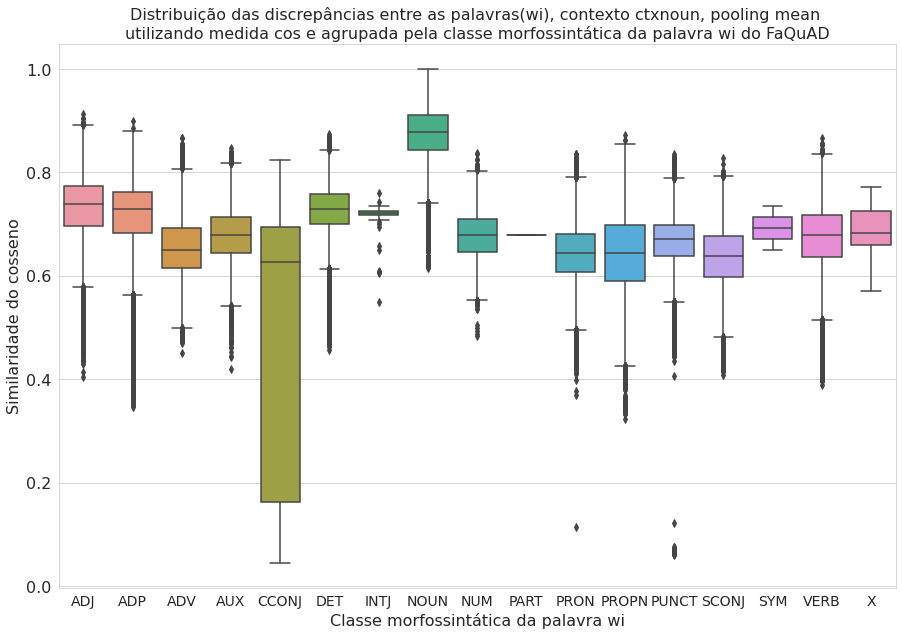

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59064.000000 0.708445 0.064349 0.403479 0.672087 0.712279 0.751407   
ADP   157515.000000 0.714563 0.069774 0.345743 0.682412 0.729714 0.762051   
ADV    21085.000000 0.649212 0.055789 0.449962 0.613482 0.648122 0.690985   
AUX    41296.000000 0.678004 0.050634 0.419467 0.645004 0.678035 0.714094   
CCONJ   6708.000000 0.457858 0.261048 0.044573 0.162162 0.625748 0.695025   
DET   120445.000000 0.723607 0.047790 0.457076 0.695874 0.728104 0.757097   
INTJ     110.000000 0.716162 0.028595 0.528106 0.717271 0.722147 0.725162   
NOUN  227381.000000 0.867145 0.065521 0.591915 0.830918 0.870362 0.907768   
NUM     4302.000000 0.649836 0.081716 0.360926 0.615603 0.668570 0.704389   
PART       1.000000 0.678993      NaN 0.678993 0.678993 0.678993 0.678993   
PRON   74668.000000 0.641996 0.056120 0.114598 0.604876 0.643471 0.679595   
PROPN  32678.000000 0.596682 0.089663 0.323937 0.533747 0.601106 0.656213   
PUNCT  89025.000000 0.666630 0.050060 0.060114 0.638674 0.670649 0.698490   
SCONJ  21400.000000 0.636754 0.058450 0.408818 0.598269 0.639043 0.676183   
SYM        2.000000 0.691995 0.059425 0.649976 0.670986 0.691995 0.713005   
VERB   90328.000000 0.665848 0.059744 0.389185 0.628725 0.671469 0.707354   
X         29.000000 0.686084 0.051167 0.569684 0.658942 0.683040 0.725672   

           max  
pos_i           
ADJ   0.912062  
ADP   0.900137  
ADV   0.867146  
AUX   0.846135  
CCONJ 0.823391  
DET   0.873616  
INTJ  0.759687  
NOUN  1.000000  
NUM   0.837381  
PART  0.678993  
PRON  0.835995  
PROPN 0.872319  
PUNCT 0.835548  
SCONJ 0.828032  
SYM   0.734015  
VERB  0.866754  
X     0.771624

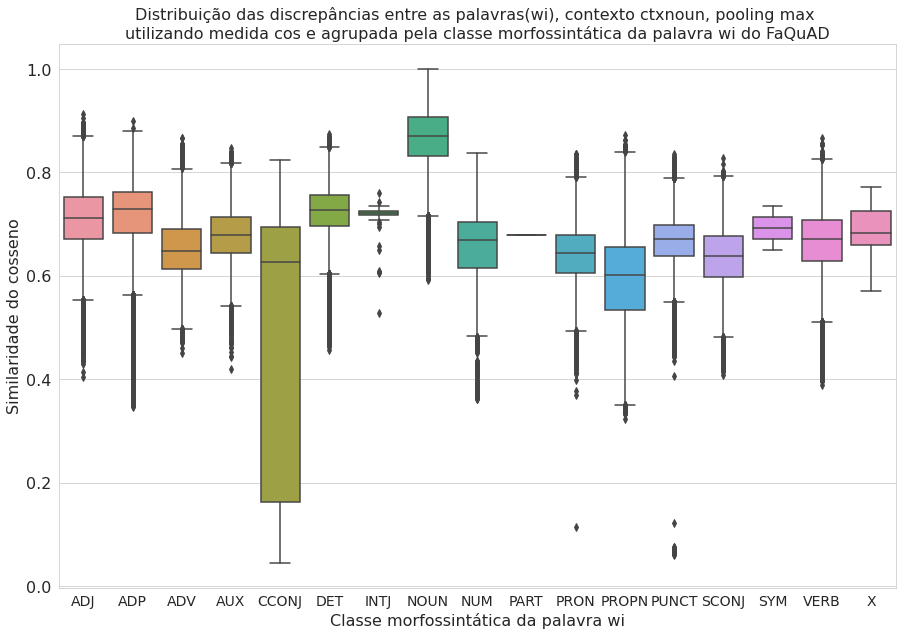

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg       std       min       25%       50%  \
pos_i                                                                   
ADJ    59064.000000 28.309761  5.053371 15.979164 24.945881 27.652034   
ADP   157515.000000 28.241566  4.046765 16.678593 25.352838 27.408516   
ADV    21085.000000 33.053530  3.602104 20.685497 30.761021 32.384048   
AUX    41296.000000 30.313017  3.117057 21.447918 28.275767 30.051484   
CCONJ   6708.000000 34.000373  5.779322 24.170784 28.676829 33.031490   
DET   120445.000000 27.348727  2.652735 18.156540 25.575836 27.093237   
INTJ     110.000000 28.023304  2.792236 26.350864 27.142537 27.424247   
NOUN  227381.000000 17.842733  6.239665  0.000000 15.932339 18.745926   
NUM     4302.000000 31.952118  4.004862 20.494673 29.072426 31.770824   
PART       1.000000 40.105106       NaN 40.105106 40.105106 40.105106   
PRON   74668.000000 31.859867  3.092404 20.573772 29.769456 31.638675   
PROPN  32678.000000 31.851068  4.945924 18.372391 28.493269 31.233039   
PUNCT  89025.000000 29.937842  3.088954 19.989904 27.985325 29.450706   
SCONJ  21400.000000 32.690441  3.406010 22.720898 30.532070 32.335794   
SYM        2.000000 38.112918 10.015862 31.030634 34.571776 38.112918   
VERB   90328.000000 33.348921  5.171530 19.976191 29.864343 32.588289   
X         29.000000 35.997525  5.843482 26.541012 31.900337 34.888214   

            75%       max  
pos_i                      
ADJ   31.206911 55.267582  
ADP   30.342679 54.086140  
ADV   34.839264 51.378090  
AUX   31.867688 50.608852  
CCONJ 38.819209 49.370525  
DET   28.718126 48.998531  
INTJ  27.592826 47.013565  
NOUN  21.277746 42.880272  
NUM   34.480504 53.099747  
PART  40.105106 40.105106  
PRON  33.608870 53.431068  
PROPN 34.706071 55.678295  
PUNCT 31.251511 53.545292  
SCONJ 34.551725 50.305202  
SYM   41.654060 45.195202  
VERB  36.273765 56.130772  
X     39.093208 50.391624

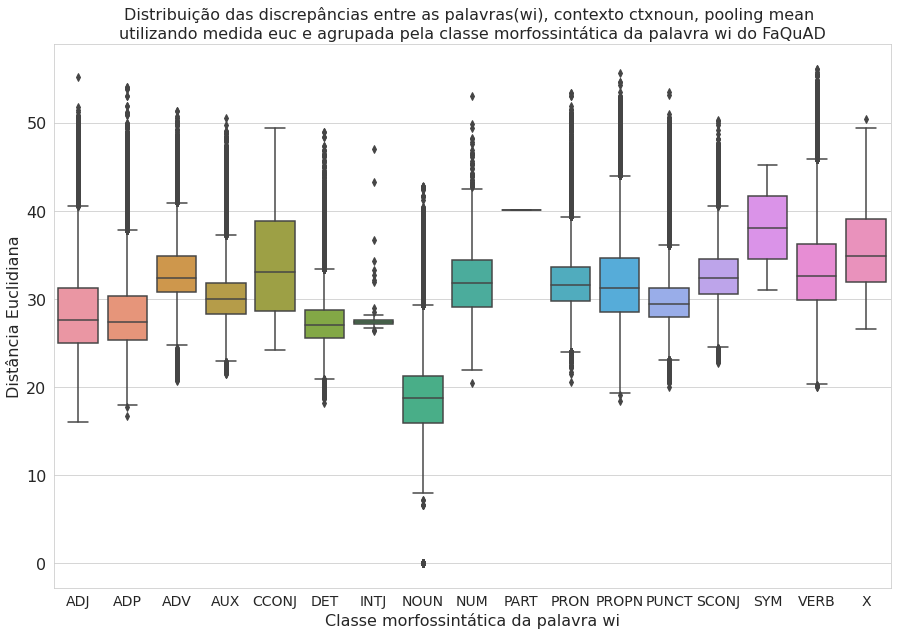

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg       std       min       25%       50%  \
pos_i                                                                   
ADJ    59064.000000 29.737729  4.582232 16.109329 26.672362 29.109244   
ADP   157515.000000 28.241664  4.046926 16.678593 25.352838 27.408609   
ADV    21085.000000 33.135547  3.544010 20.685497 30.827673 32.459625   
AUX    41296.000000 30.313169  3.117216 21.447918 28.275767 30.051484   
CCONJ   6708.000000 34.225201  5.839820 24.170784 28.869628 33.444126   
DET   120445.000000 27.500012  2.743942 18.156540 25.619370 27.230923   
INTJ     110.000000 28.036485  2.836394 26.350864 27.142537 27.424247   
NOUN  227381.000000 18.751448  6.394565  0.000000 16.418564 19.419411   
NUM     4302.000000 33.849196  5.161554 20.494673 30.470468 32.985229   
PART       1.000000 40.105106       NaN 40.105106 40.105106 40.105106   
PRON   74668.000000 31.918572  3.091736 20.573772 29.819162 31.690642   
PROPN  32678.000000 34.277972  5.028954 18.372391 30.810917 34.139406   
PUNCT  89025.000000 29.937842  3.088954 19.989904 27.985325 29.450706   
SCONJ  21400.000000 32.690615  3.406311 22.720898 30.532070 32.335794   
SYM        2.000000 38.112918 10.015862 31.030634 34.571776 38.112918   
VERB   90328.000000 33.924425  4.776986 19.976191 30.583095 33.018665   
X         29.000000 35.997525  5.843482 26.541012 31.900337 34.888214   

            75%       max  
pos_i                      
ADJ   32.092416 55.267582  
ADP   30.342679 54.086140  
ADV   34.909618 51.378090  
AUX   31.867688 50.608852  
CCONJ 39.068967 49.370525  
DET   28.997545 48.998531  
INTJ  27.592826 47.013565  
NOUN  22.315260 42.880272  
NUM   36.166221 53.099747  
PART  40.105106 40.105106  
PRON  33.688669 53.431068  
PROPN 37.447523 55.678295  
PUNCT 31.251511 53.545292  
SCONJ 34.551725 50.305202  
SYM   41.654060 45.195202  
VERB  36.522022 56.130772  
X     39.093208 50.391624

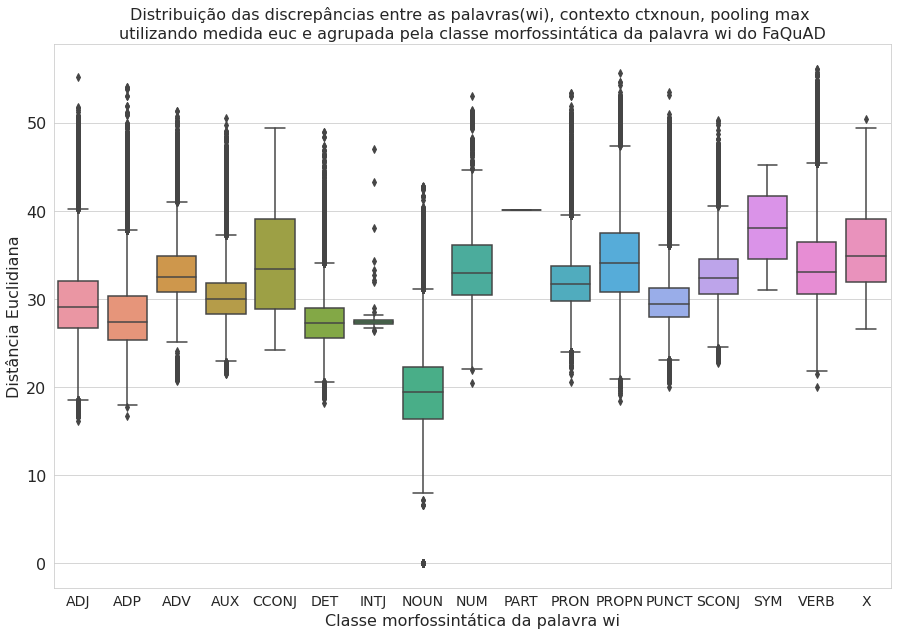

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59064.000000 1324.370574 223.057485  745.595520 1164.893219   
ADP   157515.000000 1364.366233 195.528141  796.354431 1224.998596   
ADV    21085.000000 1577.467428 154.093217  970.950989 1473.000244   
AUX    41296.000000 1450.441017 139.850104 1038.602051 1356.880768   
CCONJ   6708.000000 1433.535798 184.457588 1148.642578 1307.691528   
DET   120445.000000 1316.744716 124.130910  874.871521 1233.873535   
INTJ     110.000000 1361.137031  97.766973 1293.776367 1328.490295   
NOUN  227381.000000  839.995841 290.694901    0.000000  754.412109   
NUM     4302.000000 1514.537241 159.887754 1005.061401 1395.855225   
PART       1.000000 1599.013184        NaN 1599.013184 1599.013184   
PRON   74668.000000 1543.180591 143.212000  987.327637 1447.545166   
PROPN  32678.000000 1497.915503 224.371845  845.893738 1343.030792   
PUNCT  89025.000000 1454.591899 128.338687  979.413818 1370.368896   
SCONJ  21400.000000 1590.911319 162.177398 1111.696777 1483.798218   
SYM        2.000000 1660.716675 278.328519 1463.908691 1562.312683   
VERB   90328.000000 1553.465386 200.493338  963.460083 1422.152100   
X         29.000000 1559.675617 178.032871 1228.456543 1460.176514   

              50%         75%         max  
pos_i                                      
ADJ   1305.253113 1472.478241 2380.731934  
ADP   1322.818604 1467.785889 2406.703125  
ADV   1560.613525 1667.426270 2291.108643  
AUX   1439.307495 1528.553802 2284.615234  
CCONJ 1399.280457 1480.374725 2356.751465  
DET   1302.387207 1383.117432 2220.546875  
INTJ  1340.479980 1348.969574 1957.826416  
NOUN   883.820984 1003.062256 1962.556152  
NUM   1516.057983 1617.029236 2246.338867  
PART  1599.013184 1599.013184 1599.013184  
PRON  1535.022949 1626.839752 2360.338867  
PROPN 1475.119263 1630.711060 2561.145264  
PUNCT 1438.495850 1522.919067 2317.733398  
SCONJ 1576.521484 1686.241180 2332.926514  
SYM   1660.716675 1759.120667 1857.524658  
VERB  1539.189453 1673.703613 2439.069336  
X     1520.910645 1665.941040 1968.122192

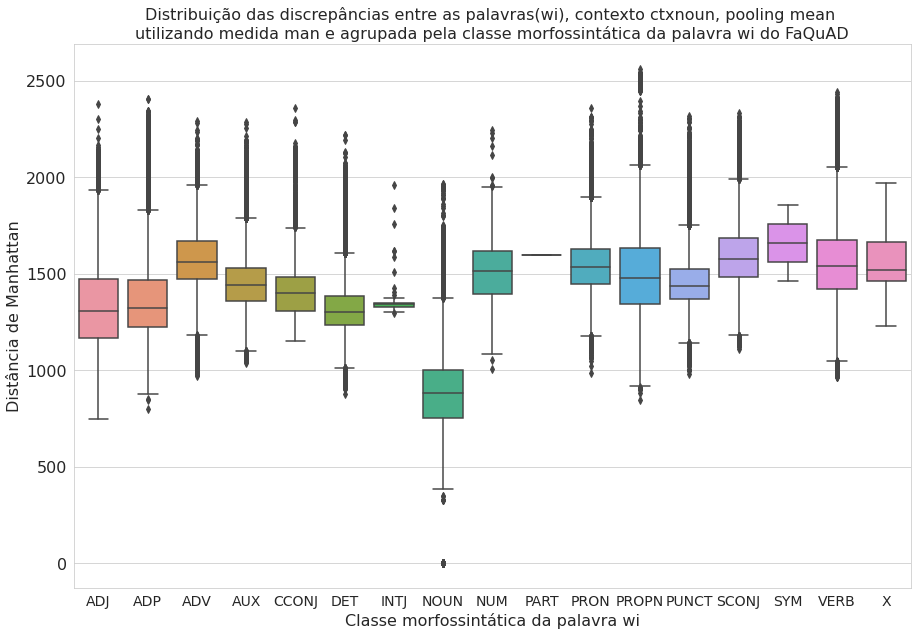

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59064.000000 1389.962449 200.037075  781.642456 1253.177734   
ADP   157515.000000 1364.374072 195.540388  796.354431 1224.998596   
ADV    21085.000000 1581.585438 150.661011  970.950989 1477.001221   
AUX    41296.000000 1450.449292 139.862639 1038.602051 1356.888519   
CCONJ   6708.000000 1443.028185 190.654503 1148.642578 1313.527466   
DET   120445.000000 1323.802010 128.475291  874.871521 1235.625000   
INTJ     110.000000 1361.733545 100.377634 1293.776367 1328.490295   
NOUN  227381.000000  882.971726 299.294060    0.000000  776.452271   
NUM     4302.000000 1610.981133 245.985653 1005.061401 1475.518982   
PART       1.000000 1599.013184        NaN 1599.013184 1599.013184   
PRON   74668.000000 1545.680777 142.876214  987.327637 1449.619141   
PROPN  32678.000000 1613.389721 235.901587  845.893738 1447.023804   
PUNCT  89025.000000 1454.591899 128.338687  979.413818 1370.368896   
SCONJ  21400.000000 1590.924541 162.195125 1111.696777 1483.798218   
SYM        2.000000 1660.716675 278.328519 1463.908691 1562.312683   
VERB   90328.000000 1581.399283 184.945834  972.795471 1454.918610   
X         29.000000 1559.675617 178.032871 1228.456543 1460.176514   

              50%         75%         max  
pos_i                                      
ADJ   1362.343506 1503.260010 2380.731934  
ADP   1322.820801 1467.785889 2406.703125  
ADV   1563.425659 1669.867432 2291.108643  
AUX   1439.307495 1528.553802 2284.615234  
CCONJ 1404.448486 1488.515137 2356.751465  
DET   1308.658447 1396.754883 2220.546875  
INTJ  1340.479980 1348.969574 1957.826416  
NOUN   915.575378 1049.989746 1972.896240  
NUM   1566.138794 1701.498718 2573.300781  
PART  1599.013184 1599.013184 1599.013184  
PRON  1537.548584 1629.717743 2360.338867  
PROPN 1597.531799 1767.268646 2561.145264  
PUNCT 1438.495850 1522.919067 2317.733398  
SCONJ 1576.521484 1686.290985 2332.926514  
SYM   1660.716675 1759.120667 1857.524658  
VERB  1559.815308 1691.722748 2439.069336  
X     1520.910645 1665.941040 1968.122192

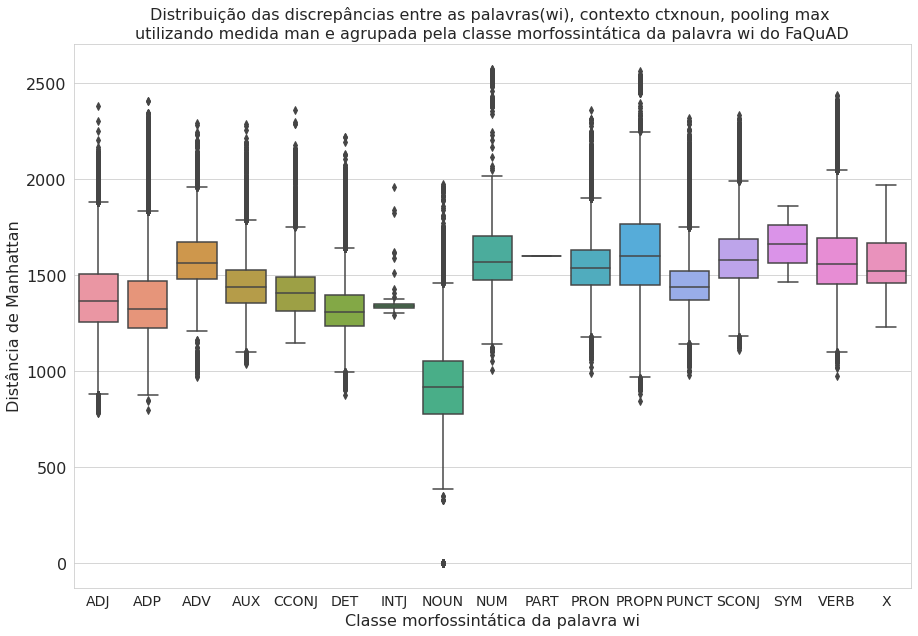

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59641.000000 0.750676 0.046738 0.467708 0.721681 0.752918 0.783077   
ADP   160705.000000 0.733543 0.059851 0.374397 0.704826 0.743459 0.773968   
ADV    21748.000000 0.731410 0.048716 0.534060 0.704207 0.737438 0.764005   
AUX    43680.000000 0.855060 0.047743 0.638759 0.826567 0.854311 0.883450   
CCONJ   6817.000000 0.481572 0.278268 0.056056 0.159791 0.657228 0.728635   
DET   122866.000000 0.763962 0.051139 0.461803 0.731835 0.768047 0.800101   
INTJ     110.000000 0.721291 0.019830 0.608432 0.717271 0.721988 0.725162   
NOUN  227381.000000 0.840483 0.047335 0.589180 0.810611 0.843045 0.872600   
NUM     4313.000000 0.707143 0.047917 0.541922 0.681424 0.707068 0.739050   
PART       1.000000 0.674922      NaN 0.674922 0.674922 0.674922 0.674922   
PRON   81521.000000 0.718259 0.048264 0.109775 0.688289 0.721956 0.751730   
PROPN  40510.000000 0.660911 0.077401 0.342028 0.616414 0.667065 0.714710   
PUNCT  94030.000000 0.723386 0.046677 0.050545 0.699355 0.727021 0.752465   
SCONJ  22123.000000 0.718231 0.050259 0.520264 0.681104 0.723672 0.755510   
SYM        3.000000 0.733916 0.048282 0.679228 0.715551 0.751873 0.761260   
VERB   94772.000000 0.849121 0.050819 0.565885 0.819829 0.848320 0.876866   
X         29.000000 0.707522 0.040636 0.569684 0.694601 0.714731 0.726520   

           max  
pos_i           
ADJ   0.897913  
ADP   0.872245  
ADV   0.887121  
AUX   1.000000  
CCONJ 0.848969  
DET   0.912942  
INTJ  0.835789  
NOUN  1.000000  
NUM   0.847036  
PART  0.674922  
PRON  0.876481  
PROPN 0.895054  
PUNCT 0.847226  
SCONJ 0.853951  
SYM   0.770646  
VERB  1.000000  
X     0.793750

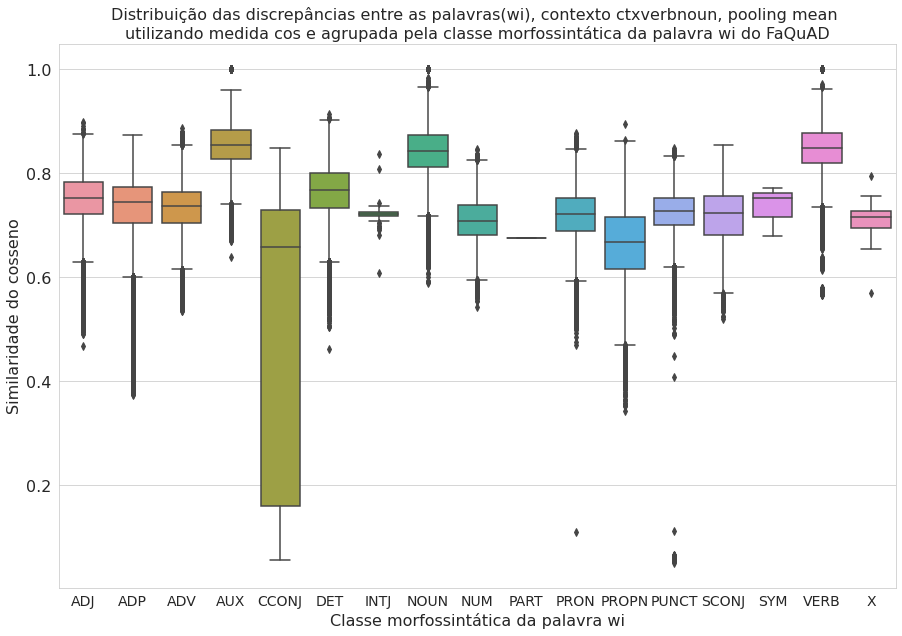

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                       
ADJ    59641.000000 0.727671 0.057573 0.467708 0.697121 0.734150 0.766954   
ADP   160705.000000 0.733542 0.059852 0.374397 0.704824 0.743458 0.773968   
ADV    21748.000000 0.729900 0.049923 0.499072 0.702666 0.736310 0.763342   
AUX    43680.000000 0.855055 0.047748 0.638759 0.826567 0.854301 0.883449   
CCONJ   6817.000000 0.477171 0.278476 0.056056 0.159791 0.657228 0.728635   
DET   122866.000000 0.761417 0.053276 0.461803 0.727269 0.766313 0.799565   
INTJ     110.000000 0.721071 0.021183 0.584204 0.717271 0.721988 0.725162   
NOUN  227381.000000 0.829347 0.058875 0.535262 0.797559 0.837205 0.869424   
NUM     4313.000000 0.680461 0.086501 0.360693 0.649423 0.697011 0.736281   
PART       1.000000 0.674922      NaN 0.674922 0.674922 0.674922 0.674922   
PRON   81521.000000 0.717321 0.048371 0.109775 0.687207 0.721468 0.750949   
PROPN  40510.000000 0.616345 0.080504 0.320858 0.561446 0.621933 0.670879   
PUNCT  94030.000000 0.723386 0.046677 0.050545 0.699355 0.727021 0.752465   
SCONJ  22123.000000 0.718228 0.050260 0.520264 0.681100 0.723664 0.755510   
SYM        3.000000 0.733916 0.048282 0.679228 0.715551 0.751873 0.761260   
VERB   94772.000000 0.839534 0.060686 0.500156 0.807964 0.842601 0.874138   
X         29.000000 0.707522 0.040636 0.569684 0.694601 0.714731 0.726520   

           max  
pos_i           
ADJ   0.897913  
ADP   0.872245  
ADV   0.887121  
AUX   1.000000  
CCONJ 0.848969  
DET   0.912942  
INTJ  0.835789  
NOUN  1.000000  
NUM   0.847036  
PART  0.674922  
PRON  0.876481  
PROPN 0.895054  
PUNCT 0.847226  
SCONJ 0.853951  
SYM   0.770646  
VERB  1.000000  
X     0.793750

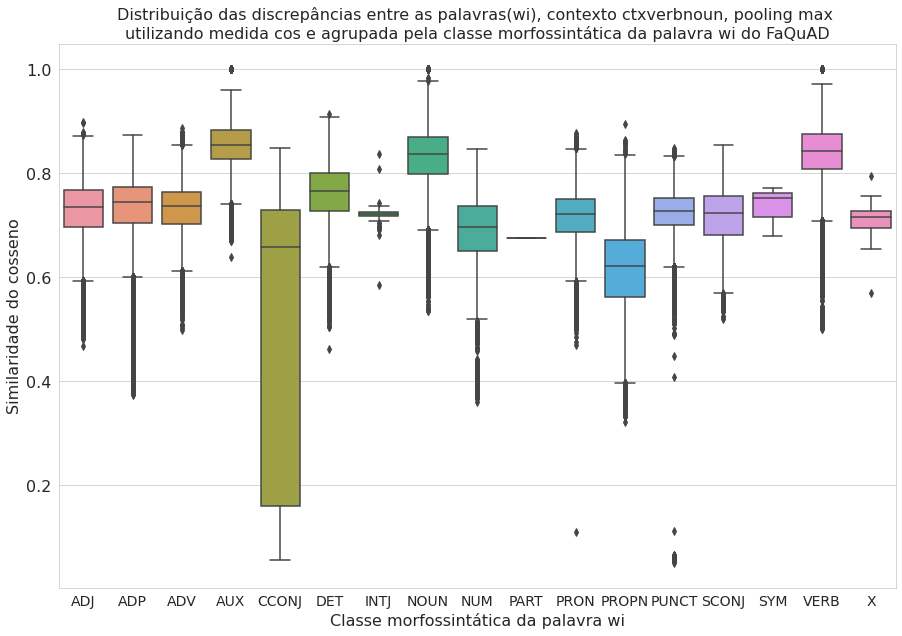

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59641.000000 27.233476 4.100540 15.936810 24.581631 26.776535   
ADP   160705.000000 27.255953 3.430811 18.369455 24.957178 26.681534   
ADV    21748.000000 29.012134 3.558671 18.596228 26.458188 28.576413   
AUX    43680.000000 20.047461 4.457246  0.000000 18.311740 20.345700   
CCONJ   6817.000000 32.723998 6.200546 21.238138 26.868498 31.039581   
DET   122866.000000 25.302299 3.015356 14.842761 23.262020 25.091208   
INTJ     110.000000 27.789770 2.075112 21.679914 27.146496 27.440255   
NOUN  227381.000000 21.135618 3.562932  0.000000 19.058023 21.087414   
NUM     4313.000000 30.275848 3.515591 19.991943 27.768063 30.149893   
PART       1.000000 40.353348      NaN 40.353348 40.353348 40.353348   
PRON   81521.000000 28.274548 3.095108 18.705624 26.198950 27.960024   
PROPN  40510.000000 30.787000 4.437248 19.038218 27.717204 30.342052   
PUNCT  94030.000000 27.197582 2.912845 19.585373 25.395061 26.784215   
SCONJ  22123.000000 28.790427 3.120341 19.489887 26.547355 28.494619   
SYM        3.000000 33.252271 9.656757 25.509417 27.842039 30.174662   
VERB   94772.000000 23.296995 5.902103  0.000000 20.509922 23.199769   
X         29.000000 35.030025 5.731499 26.660492 31.757484 33.542706   

            75%       max  
pos_i                      
ADJ   29.111242 50.031033  
ADP   28.863068 50.928780  
ADV   30.876230 50.123524  
AUX   22.387458 40.660137  
CCONJ 38.429588 47.385174  
DET   27.127380 45.040173  
INTJ  27.604267 42.711445  
NOUN  23.125341 44.897823  
NUM   32.492188 46.874363  
PART  40.353348 40.353348  
PRON  29.845854 49.463230  
PROPN 33.295654 54.625130  
PUNCT 28.376212 49.192982  
SCONJ 30.811259 48.096107  
SYM   37.123698 44.072735  
VERB  26.408145 44.780048  
X     37.088829 48.564247

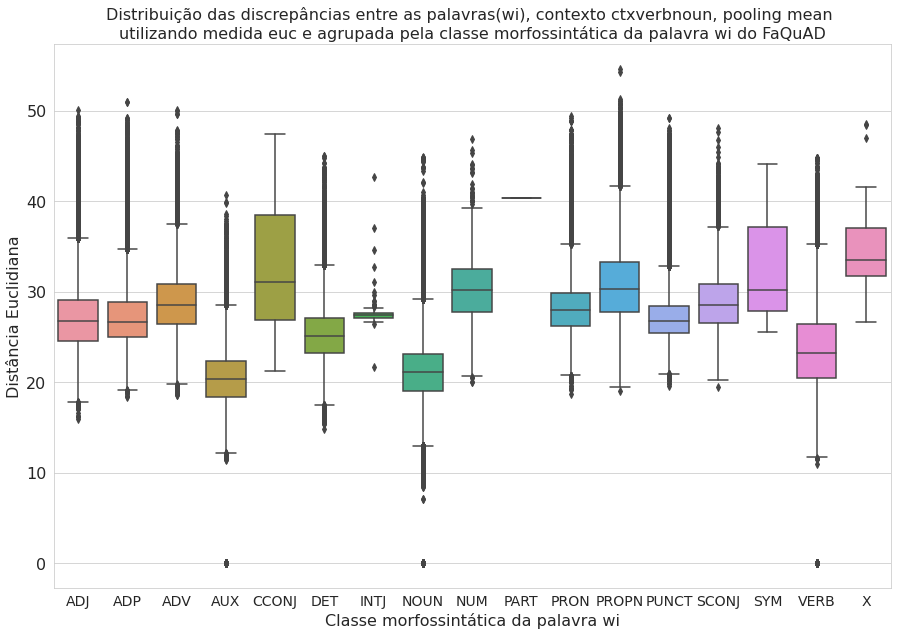

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%  \
pos_i                                                                  
ADJ    59641.000000 28.655342 3.875450 16.609022 26.121881 28.022943   
ADP   160705.000000 27.256047 3.430998 18.369455 24.957178 26.681547   
ADV    21748.000000 29.102960 3.573531 18.596228 26.505866 28.671923   
AUX    43680.000000 20.047782 4.457429  0.000000 18.312181 20.345980   
CCONJ   6817.000000 32.961451 6.236641 21.238138 27.009501 31.493582   
DET   122866.000000 25.462434 3.128969 14.842761 23.311309 25.214916   
INTJ     110.000000 27.804514 2.129366 21.679914 27.146496 27.440255   
NOUN  227381.000000 21.895085 3.962297  0.000000 19.455410 21.647518   
NUM     4313.000000 32.240308 5.164725 19.991943 29.400511 31.607805   
PART       1.000000 40.353348      NaN 40.353348 40.353348 40.353348   
PRON   81521.000000 28.336317 3.082161 19.279636 26.230417 27.995104   
PROPN  40510.000000 33.432473 4.461727 19.038218 30.425743 33.172649   
PUNCT  94030.000000 27.197582 2.912845 19.585373 25.395061 26.784215   
SCONJ  22123.000000 28.790626 3.120724 19.489887 26.547355 28.494619   
SYM        3.000000 33.252271 9.656757 25.509417 27.842039 30.174662   
VERB   94772.000000 23.997800 5.980004  0.000000 21.220235 24.112951   
X         29.000000 35.030025 5.731499 26.660492 31.757484 33.542706   

            75%       max  
pos_i                      
ADJ   30.539997 50.031033  
ADP   28.863068 50.928780  
ADV   30.981674 50.123524  
AUX   22.387458 40.660137  
CCONJ 38.532009 47.385174  
DET   27.380800 45.040173  
INTJ  27.604267 42.711445  
NOUN  24.168236 44.897823  
NUM   34.602905 52.024624  
PART  40.353348 40.353348  
PRON  29.912758 49.463230  
PROPN 36.244885 54.625130  
PUNCT 28.376212 49.192982  
SCONJ 30.811259 48.096107  
SYM   37.123698 44.072735  
VERB  27.197280 44.780048  
X     37.088829 48.564247

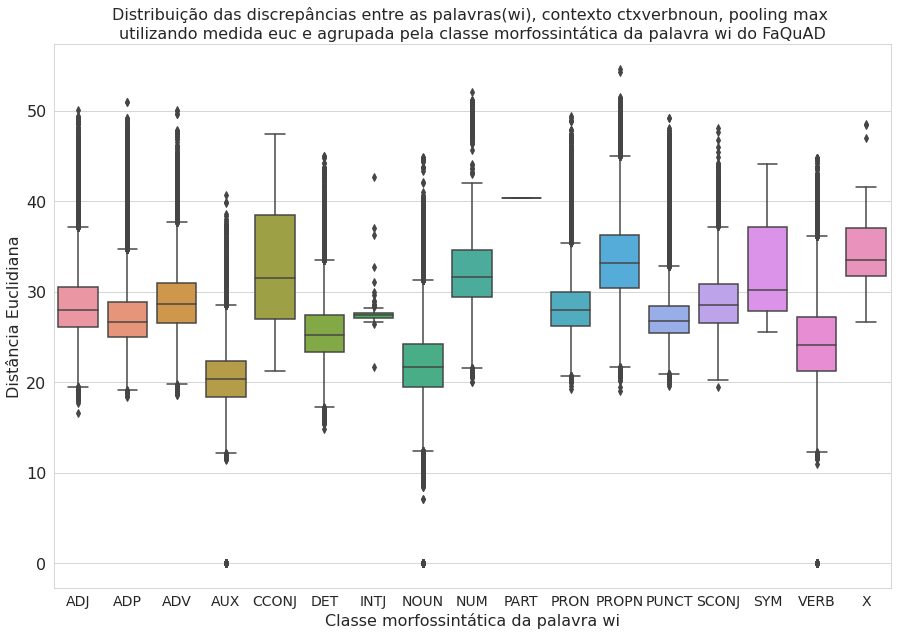

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59641.000000 1275.398523 176.613258  761.094849 1154.539673   
ADP   160705.000000 1319.703431 162.078745  877.133057 1210.566650   
ADV    21748.000000 1394.454530 153.097538  896.971680 1281.662415   
AUX    43680.000000  960.001919 213.785170    0.000000  873.276154   
CCONJ   6817.000000 1330.935011 141.027260 1020.748352 1239.274902   
DET   122866.000000 1221.944714 137.864892  730.707642 1128.962158   
INTJ     110.000000 1349.584418  66.764525 1067.660034 1328.910187   
NOUN  227381.000000  994.400948 161.556768    0.000000  901.303894   
NUM     4313.000000 1442.688063 148.869122  985.747437 1328.309692   
PART       1.000000 1606.124512        NaN 1606.124512 1606.124512   
PRON   81521.000000 1372.610929 143.488065  917.250122 1276.072510   
PROPN  40510.000000 1440.730310 197.076479  896.215454 1301.899048   
PUNCT  94030.000000 1322.639701 119.800722  952.838013 1244.958893   
SCONJ  22123.000000 1406.959324 146.895812  975.623901 1300.060730   
SYM        3.000000 1489.626058 306.623199 1217.152466 1323.609253   
VERB   94772.000000 1087.148138 255.320942    0.000000  977.258896   
X         29.000000 1516.693856 159.437195 1247.809326 1430.252808   

              50%         75%         max  
pos_i                                      
ADJ   1260.994751 1375.481567 2248.100342  
ADP   1289.592041 1397.604248 2391.678955  
ADV   1380.740723 1487.955811 2138.242920  
AUX    975.926147 1073.690979 1678.566650  
CCONJ 1298.470703 1391.247681 2147.280273  
DET   1213.422668 1304.479431 2016.129150  
INTJ  1341.272949 1349.781769 1783.297485  
NOUN   992.113281 1086.870483 2031.854004  
NUM   1445.276855 1543.476929 2108.269043  
PART  1606.124512 1606.124512 1606.124512  
PRON  1360.721680 1449.789673 2235.134277  
PROPN 1421.562988 1554.938568 2353.031250  
PUNCT 1309.659424 1382.889069 2094.181152  
SCONJ 1394.630249 1510.695312 2125.054932  
SYM   1430.066040 1625.862854 1821.659668  
VERB  1097.783142 1230.441986 2057.369873  
X     1470.123779 1586.447510 1968.122192

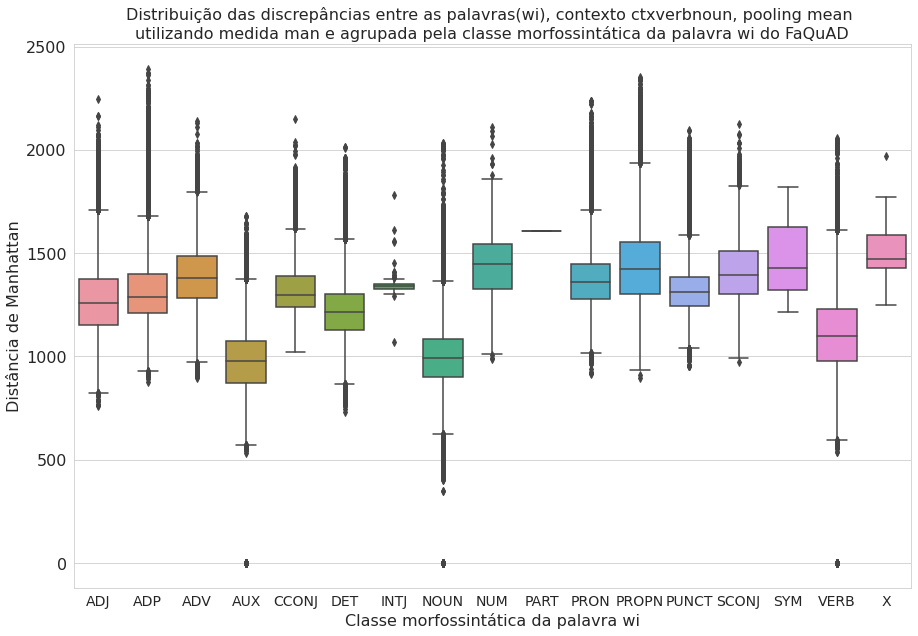

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%  \
pos_i                                                                
ADJ    59641.000000 1340.172257 162.869948  783.728882 1232.183716   
ADP   160705.000000 1319.711294 162.093991  877.133057 1210.566650   
ADV    21748.000000 1398.867735 153.473071  896.971680 1284.175140   
AUX    43680.000000  960.017825 213.797498    0.000000  873.282349   
CCONJ   6817.000000 1340.864164 149.209397 1020.748352 1242.088257   
DET   122866.000000 1229.312405 142.733606  730.707642 1131.153809   
INTJ     110.000000 1350.152415  69.257508 1067.660034 1328.910187   
NOUN  227381.000000 1029.738513 181.371779    0.000000  919.235596   
NUM     4313.000000 1542.081501 250.180402  985.747437 1419.805542   
PART       1.000000 1606.124512        NaN 1606.124512 1606.124512   
PRON   81521.000000 1375.227545 142.562932  917.250122 1277.341675   
PROPN  40510.000000 1565.322028 207.251289  896.215454 1422.909332   
PUNCT  94030.000000 1322.639701 119.800722  952.838013 1244.958893   
SCONJ  22123.000000 1406.973452 146.919391  975.623901 1300.060730   
SYM        3.000000 1489.626058 306.623199 1217.152466 1323.609253   
VERB   94772.000000 1120.826461 264.954590    0.000000 1008.485291   
X         29.000000 1516.693856 159.437195 1247.809326 1430.252808   

              50%         75%         max  
pos_i                                      
ADJ   1318.818970 1424.249023 2248.100342  
ADP   1289.592041 1397.604248 2391.678955  
ADV   1386.949646 1492.623993 2138.242920  
AUX    975.942749 1073.690979 1678.566650  
CCONJ 1302.157227 1401.070557 2147.280273  
DET   1218.881531 1317.040771 2016.129150  
INTJ  1341.272949 1349.781769 1783.297485  
NOUN  1017.476379 1135.876465 2031.854004  
NUM   1508.173828 1625.263062 2523.266357  
PART  1606.124512 1606.124512 1606.124512  
PRON  1362.316162 1452.149170 2235.134277  
PROPN 1547.973022 1701.455200 2433.425049  
PUNCT 1309.659424 1382.889069 2094.181152  
SCONJ 1394.630249 1510.730713 2125.054932  
SYM   1430.066040 1625.862854 1821.659668  
VERB  1137.373291 1268.696106 2214.292969  
X     1470.123779 1586.447510 1968.122192

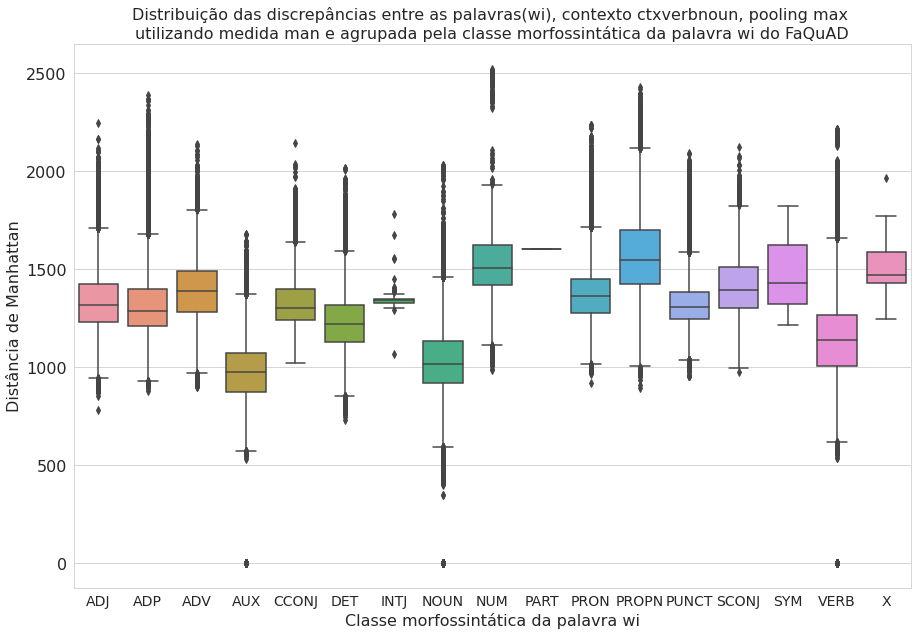

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/983942 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

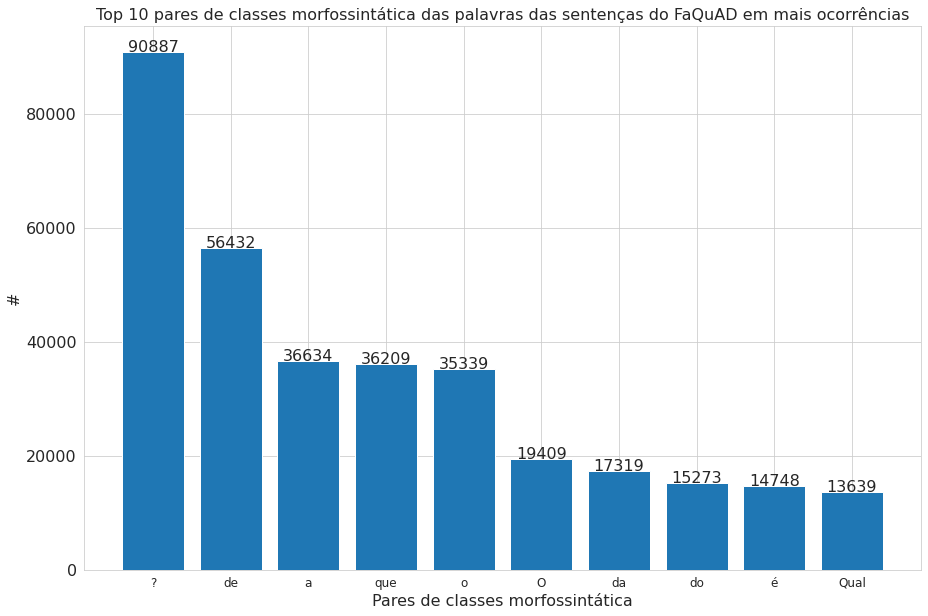

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do FaQuAD em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 94772


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count     94772.000000     94772.000000    94772.000000    94772.000000   
mean          0.800123        26.880463     1280.562900        0.790656   
std           0.043465         5.228289      182.236136        0.044641   
min           0.529941        10.839937      676.948700        0.529941   
25%           0.773485        23.133446     1154.361675        0.765805   
50%           0.801312        26.268336     1267.521050        0.793468   
75%           0.829603        30.031562     1395.247050        0.820579   
max           0.945093        48.347458     2171.871000        0.920090   

       euc_ctxall_max  man_ctxall_max  
count    94772.000000    94772.000000  
mean        27.569819     1280.562900  
std          4.804614      182.236136  
min         14.270814      676.948700  
25%         24.174438     1154.361675  
50%         26.853007     1267.521050  
75%         30.323083     1395.247050  
max         48.347458     2171.871000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/94772 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        2 16662
      2        4 13084
      3        3 11084
      4        5 10061
      5        6  9666
      6        1  7974
      7        7  7085
      8        8  4908
      9        9  3470
     10       10  2380
     11       11  1943
     12       12  1644
     13       13  1457
     14       14  1255
     15       15   512
     16       16   429
     17        0   213
     18       20   202
     19       18   202
     20       41   101


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.056117743253707886
Limite superior             : 0.9137794971466064
Limite inferior             : 0.6893085241317749


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 250 de 94772 ( 0.002637909931203309 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 876 de 94772 ( 0.009243236398936394 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1126 de 94772 ( 0.011881146330139704 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.945092797279358 UNIVASF
         O que eu UNIVASF ?

 2 0.9437307119369508 SGBDs
         O que não SGBDs ?

 3 0.9394912123680116 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 4 0.9385135769844056 SGBDs
         O que será SGBDs ?

 5 0.9372516870498656 emos
         Onde geralmente emos a próxima instrução ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5299408435821533 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que alegre os moradores de Brasília ” ?

 2 0.5306627154350281 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que far os moradores de Brasília ” ?

 3 0.5322091579437256 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que , os moradores de Brasília ” ?

 4 0.532239258

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual a base da análise e interpretação dos dados selecionados a partir da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 0.7930964231491089 selecionados
       2 0.7838923335075378 ocorem
       3 0.6892514824867249 partir

 2 Qual a base da análise e interpretação dos dados produzidos a partir da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 0.7850151062011719 ocorem
       2 0.7646176218986511 produzidos
       3 0.6892384886741638 partir

 3 Qual a base da análise e interpretação dos dados visuais a partir da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 0.7843976616859436 ocorem
       2 0.6892383694648743 partir

 4 O que recuperar caso o aluno perca o prazo de seleção de disciplinas online ?
       1 0.8020662665367126 perca
       2 0.7737921476364136 online
       3 0.6892286539077759 recuperar

 5 Qual a base da análise e interpretação dos dados realizados a partir da observação de fat

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05477461218833923
Limite superior             : 0.9027411639690399
Limite inferior             : 0.683642715215683


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 31 de 94772 ( 0.0003271008314692103 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1627 de 94772 ( 0.017167517832271134 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1658 de 94772 ( 0.017494618663740344 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.920089840888977 vai
         Quem vai a academia ?

 2 0.9198368787765504 pode
         Onde o acadêmico pode mais aproveitamento dos estudos ?

 3 0.9184812903404236 é
         O que é assim ?

 4 0.9184812903404236 é
         O que é assim ?

 5 0.9184812903404236 é
         O que é assim ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5299408435821533 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que alegre os moradores de Brasília ” ?

 2 0.5306627154350281 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que far os moradores de Brasília ” ?

 3 0.5322091579437256 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que , os moradores de Brasília ” ?

 4 0.532239258

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram perceber a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.7730032205581665 perceber
       2 0.7224231362342834 combinados
       3 0.6836019158363342 trazidas
       4 0.6801348924636841 ficaram

 2 O que quer ia Total de Alunos Equivalentes da Graduação ?
       1 0.693994402885437 quer
       2 0.6835752725601196 ia

 3 O que quer aquilo Total de Alunos Equivalentes da Graduação ?
       1 0.6835546493530273 quer

 4 O que acontece caso o Aluno Especial não atingir o aproveitamento das duas disciplinas cursadas até a data de matrícula ?
       1 0.7561030387878418 atingir
       2 0.6835267543792725 acontece
       3 0.6552519202232361 cursadas

 5 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o gere de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 0.7549813389778137 deve
      

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.898116588592529
Limite superior             : 40.37873721122742
Limite inferior             : 12.7862708568573


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1269 de 94772 ( 0.013390030810787996 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 13 de 94772 ( 0.00013717131642257207 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1282 de 94772 ( 0.013527202127210569 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.34745788574219 criados
         Qual curso foi criados através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?

 2 47.272003173828125 oferecidos
         Qual curso foi oferecidos através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?

 3 45.52693939208984 haja
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 45.517845153808594 defendem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5 45.49832534790039 irão
         Em qual semestre o

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.839937210083008 SGBDs
         O que não SGBDs ?

 2 11.23850440979004 UNIVASF
         O que eu UNIVASF ?

 3 11.374080657958984 SGBDs
         O que será SGBDs ?

 4 11.439407348632812 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 5 11.63393211364746 SGBDs
         O que serão SGBDs ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual curso foi criados através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 48.34745788574219 criados

 2 Qual curso foi oferecidos através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 47.272003173828125 oferecidos

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.52693939208984 haja
       2 33.05768203735352 existir
       3 30.82730865478516 apresentar
       4 26.336753845214844 enquadrado
       5 26.131866455078125 deve
       6 25.72097396850586 cursadas
       7 21.61156463623047 matricular

 4 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defend

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.148645401000977
Limite superior             : 39.54605150222778
Limite inferior             : 14.951469898223877


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1926 de 94772 ( 0.020322458109990293 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 94772 ( 5.275819862406618e-05 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1931 de 94772 ( 0.020375216308614358 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.34745788574219 criados
         Qual curso foi criados através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?

 2 47.272003173828125 oferecidos
         Qual curso foi oferecidos através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?

 3 45.52693939208984 haja
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 45.517845153808594 defendem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5 45.49832534790039 irão
         Em qual semestre o

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.270813941955566 é
         O que é assim ?

 2 14.270813941955566 é
         O que é assim ?

 3 14.270813941955566 é
         O que é assim ?

 4 14.270813941955566 é
         O que é assim ?

 5 14.270813941955566 é
         O que é assim ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual curso foi criados através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 48.34745788574219 criados

 2 Qual curso foi oferecidos através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 47.272003173828125 oferecidos

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.52693939208984 haja
       2 35.09726333618164 cursadas
       3 33.05768203735352 existir
       4 31.53421974182129 enquadrado
       5 30.82730865478516 apresentar
       6 26.84988784790039 matricular
       7 26.131866455078125 deve

 4 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defende

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 265.8988999999999
Limite superior             : 1774.799075
Limite inferior             : 711.2034750000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 662 de 94772 ( 0.006985185497826362 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 145 de 94772 ( 0.0015299877600979193 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  807 de 94772 ( 0.008515173257924282 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2106.6897 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que deixam os moradores de Brasília ” ?

 2 2105.8684 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que tornaram os moradores de Brasília ” ?

 3 2105.6174 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que tornam os moradores de Brasília ” ?

 4 2105.526 Há
         De quem

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 530.69006 SGBDs
         O que não SGBDs ?

 2 546.87476 iniciou-se
         Onde iniciou-se o desenvolvimento da primeira universidade árabe?

 3 549.71094 UNIVASF
         O que eu UNIVASF ?

 4 554.8734 SGBDs
         O que será SGBDs ?

 5 568.87573 SGBDs
         O que serão SGBDs ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que deixam os moradores de Brasília ” ?
       1 2106.6897 Há
       2 1811.6685 passava
       3 1404.9014 deixam
       4 1235.1182 financiadas
       5 1157.6187 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que tornaram os moradores de Brasília ” ?
       1 2105.8684 Há
       2 1812.031 passava
       3 1333.7448 tornaram
       4 1235.654 financiadas
       5 1128.8209 constituírem-se

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irrevers

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 240.88537499999984
Limite superior             : 1756.5751124999997
Limite inferior             : 793.0336125000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 982 de 94772 ( 0.010361710209766598 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 14 de 94772 ( 0.0001477229561473853 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  996 de 94772 ( 0.010509433165913983 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2171.871 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que terão os moradores de Brasília ” ?

 2 2164.5747 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que fazer os moradores de Brasília ” ?

 3 2162.8267 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que poderão os moradores de Brasília ”

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 676.9487 é
         O que é assim ?

 2 676.9487 é
         O que é assim ?

 3 676.9487 é
         O que é assim ?

 4 676.9487 é
         O que é assim ?

 5 676.9487 é
         O que é assim ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que terão os moradores de Brasília ” ?
       1 2171.871 constituírem-se
       2 2100.5388 Há
       3 1813.1947 passava
       4 1613.9321 terão
       5 1471.3109 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que fazer os moradores de Brasília ” ?
       1 2164.5747 constituírem-se
       2 2090.741 Há
       3 1810.0879 passava
       4 1747.739 fazer
       5 1481.9631 financiadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Ma

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 227381


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count    227381.000000    227381.000000    227381.000000   227381.000000   
mean          0.801309        23.441122      1103.906834        0.790187   
std           0.042486         3.363813       146.620825        0.043278   
min           0.590699         9.961720       470.890660        0.583599   
25%           0.776752        21.418997      1014.914300        0.765731   
50%           0.803749        23.193701      1092.909400        0.795262   
75%           0.829232        25.184427      1186.339700        0.820601   
max           0.956655        45.588848      2051.299000        0.909032   

       euc_ctxall_max  man_ctxall_max  
count   227381.000000   227381.000000  
mean        24.211367     1140.346628  
std          3.071373      135.461671  
min         15.454318      740.998000  
25%         22.114784     1045.189500  
50%         23.838757     1122.802600  
75%         25.794310     1215.325300  
max         45.588848     2051.299000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/227381 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        3 29660
      2        5 27517
      3        4 24940
      4        6 21193
      5        2 20732
      6        7 19646
      7        8 17410
      8        9 14869
      9        1 11980
     10       10  8061
     11       11  7664
     12       12  5598
     13       13  4363
     14       14  3133
     15       15  2167
     16       17  1923
     17       16  1514
     18        0  1375
     19       18   909
     20       19   707


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.052480459213256836
Limite superior             : 0.9079527854919434
Limite inferior             : 0.698030948638916


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1491 de 227381 ( 0.006557276113659452 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3632 de 227381 ( 0.01597319037210673 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5123 de 227381 ( 0.02253046648576618 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9566550254821776 logaritmo
         Quem determinou o logaritmo ?

 2 0.95597106218338 logaritmo
         Quem estabeleceu o logaritmo ?

 3 0.955513596534729 logaritmo
         Quem estabelece o logaritmo ?

 4 0.9549727439880372 logaritmo
         Quem conseguiu o logaritmo ?

 5 0.9546107053756714 logaritmo
         Quem controla o logaritmo ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5906989574432373 sonho
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que se os moradores de Brasília ” ?

 2 0.5958535075187683 sonho
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que conforme os moradores de Brasília ” ?

 3 0.5971134901046753 sonho
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que mostram os moradores de Brasília ” ?

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em que ano a comunidade científica do distrito federal sentiu a criação de uma instituição dedicada ao incentivo da ciência e tecnologia ?
       1 0.8026872873306274 ano
       2 0.799290657043457 instituição
       3 0.7850179672241211 incentivo
       4 0.7729264497756958 criação
       5 0.7289547920227051 comunidade
       6 0.7044926285743713 distrito
       7 0.6980300545692444 ciência
       8 0.6812158226966858 tecnologia

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que toda os moradores de Brasília ” ?
       1 0.7757190465927124 fatos
       2 0.7402358651161194 idealistas
       3 0.7315504550933838 moradores
       4 0.7071987986564636 palavras
       5 0.6991569995880127 resultados
       6 0.6980255246162415 garantia
       7 0.6609793901443481 realidade
 

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05487024784088135
Limite superior             : 0.9029064774513245
Limite inferior             : 0.6834254860877991


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 36 de 227381 ( 0.00015832457417286404 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4195 de 227381 ( 0.018449210795976796 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4231 de 227381 ( 0.018607535370149662 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9090322256088256 cursos
         Os cursos de pós-graduação é quais cursos ?

 2 0.9086940884590148 suicídio
         Quando Turing os suicídio ?

 3 0.9086278676986694 cursos
         Os cursos de pós-graduação / quais cursos ?

 4 0.9085537791252136 mais
         O que o desenvolvimento cada vez mais rápido de novas tecnologias influencia ?

 5 0.9083553552627563 cursos
         Os cursos de pós-graduação e quais cursos ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5835987329483032 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham a todos os pré-requisitos ?

 2 0.5858502388000488 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham instalado todos os pré-requisitos ?

 3 0.5872905254364014 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham instalados todos os pré-requisitos ?

 4 0.587558925151825 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham do todos os pré-requisitos ?

 5 0.5878048539161682 colação
         Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham distribuídos todos os pré-requisitos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que permite com que profissionais que não possuem educação superior abra o papel de analista de sistemas ?
       1 0.8477957844734192 profissionais
       2 0.7588045597076416 papel
       3 0.7326944470405579 educação
       4 0.7298852801322937 analista
       5 0.683403730392456 sistemas

 2 Qual um dos modelos de pós-graduação do Brasil que se comunica com o do norte-americano ?
       1 0.7748665809631348 modelos
       2 0.7303099036216736 pós-graduação
       3 0.6834025382995605 norte-americano

 3 O que a UFMS defende participando do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 0.7926738262176514 ensino
       2 0.779242992401123 ambiente
       3 0.7762150168418884 preservação
       4 0.7654557228088379 recursos
       5 0.6834861040115356 UFMS
       6 0.6833983063697815 meio

 4 por meio de quem as instituições de ensino superior irá definir as atribuições e os critérios de constituição do nde ?
       1 0.7777296900749207 constituição
 

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.7654304504394496
Limite superior             : 30.83257293701171
Limite inferior             : 15.770851135253915


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 6349


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2850 de 227381 ( 0.012534028788685071 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  9199 de 227381 ( 0.0404563266060049 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.58884811401367 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 45.52447509765625 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 45.49554061889648 dema
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o dema de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 45.492977142333984 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de di

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 9.96172046661377 logaritmo
         Quem determinou o logaritmo ?

 2 10.011636734008787 logaritmo
         Quem estabeleceu o logaritmo ?

 3 10.093157768249512 logaritmo
         Quem controla o logaritmo ?

 4 10.131525039672852 logaritmo
         Quem estabelece o logaritmo ?

 5 10.152507781982422 logaritmo
         Quem conseguiu o logaritmo ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.58884811401367 corte
       2 36.8786735534668 inicial
       3 31.496849060058597 carga
       4 30.22638511657715 caso
       5 27.520174026489254 disciplinas
       6 27.10658264160156 semestre
       7 27.028059005737305 semestre
       8 26.38494300842285 acadêmico
       9 21.26666259765625 pré-requisitos

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.52447509765625 restrição
       2 37.15609359741211 inicial
       3 31.68256950378418 carga
       4 30.237979888916016 caso
       5 27.626895904541016 disciplinas
       6 27.17919540405273 semestre
       7 

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.679525375366211
Limite superior             : 31.313597679138184
Limite inferior             : 16.59549617767334


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 6203


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 81 de 227381 ( 0.0003562302918889441 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  6284 de 227381 ( 0.027636434002841048 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.58884811401367 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 45.52447509765625 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 45.49554061889648 dema
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o dema de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 45.492977142333984 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de di

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.454318046569824 empresas
         Como muitas empresas desenvolvedoras são empresas ?

 2 15.810619354248049 cursos
         Os cursos de pós-graduação – quais cursos ?

 3 15.842206001281738 cursos
         Os cursos de pós-graduação e quais cursos ?

 4 15.868224143981934 cursos
         Os cursos de pós-graduação / quais cursos ?

 5 15.903451919555664 cursos
         Os cursos de pós-graduação ou quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.58884811401367 corte
       2 36.8786735534668 inicial
       3 31.496849060058597 carga
       4 30.22638511657715 caso
       5 30.14266586303711 pré-requisitos
       6 27.520174026489254 disciplinas
       7 27.10658264160156 semestre
       8 27.028059005737305 semestre
       9 26.38494300842285 acadêmico

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 45.52447509765625 restrição
       2 37.15609359741211 inicial
       3 31.68256950378418 carga
       4 30.237979888916016 caso
       5 30.225133895874023 pré-requisitos
       6 27.626895904541016 disciplinas
  

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 171.42539999999997
Limite superior             : 1443.4778
Limite inferior             : 757.7762


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4925


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2887 de 227381 ( 0.01269675126769607 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7812 de 227381 ( 0.0343564325955115 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2051.299 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2049.1855 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 2047.1465 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 2044.1956 força
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o força de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 470.89066 logaritmo
         Quem determinou o logaritmo ?

 2 477.9087 logaritmo
         Quem estabeleceu o logaritmo ?

 3 481.07916 logaritmo
         Quem estabelece o logaritmo ?

 4 482.09894 logaritmo
         Quem controla o logaritmo ?

 5 483.32935 logaritmo
         Quem obteve o logaritmo ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2051.299 corte
       2 1650.6545 inicial
       3 1491.0999 carga
       4 1467.2673 caso
       5 1308.5044 semestre
       6 1275.7996 semestre
       7 1227.1707 disciplinas
       8 1215.4792 acadêmico
       9 1069.1332 pré-requisitos

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2049.1855 em
       2 1650.7759 inicial
       3 1503.2192 carga
       4 1457.3516 caso
       5 1315.8009 semestre
       6 1289.3962 semestre
       7 1230.7676 disciplinas
       8 1211.801 acadêmico
       9 1066.0269 pré-requisitos

 3 Em qual semestre o acadêmico deve ser enquadrado no ca

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 170.13580000000002
Limite superior             : 1470.529
Limite inferior             : 789.9857999999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 5086


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 41 de 227381 ( 0.0001803140983635396 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5127 de 227381 ( 0.022548058105118722 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2051.299 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2049.1855 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 2047.1465 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 2044.1956 força
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o força de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 740.998 empresas
         Como muitas empresas desenvolvedoras são empresas ?

 2 754.25684 questão
         Qual a questão do estágio ?

 3 758.46826 cursos
         Os cursos de pós-graduação – quais cursos ?

 4 762.39404 ensino
         Quem busca o ensino superior ?

 5 768.2691 ensino
         Quem consegue o ensino superior ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2051.299 corte
       2 1650.6545 inicial
       3 1491.0999 carga
       4 1485.6659 pré-requisitos
       5 1467.2673 caso
       6 1308.5044 semestre
       7 1275.7996 semestre
       8 1227.1707 disciplinas
       9 1215.4792 acadêmico

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2049.1855 em
       2 1650.7759 inicial
       3 1503.2192 carga
       4 1483.3583 pré-requisitos
       5 1457.3516 caso
       6 1315.8009 semestre
       7 1289.3962 semestre
       8 1230.7676 disciplinas
       9 1211.801 acadêmico

 3 Em qual semestre o acadêmico deve ser enquadrado no ca

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count   983942.000000   983942.000000   983942.000000    94772.000000   
mean         0.814825       22.870999     1097.141677        0.800123   
std          0.055974        4.020063      170.796698        0.043465   
min          0.065848        9.821314      470.890660        0.529941   
25%          0.787891       20.245739      984.761050        0.773485   
50%          0.819131       22.374681     1081.591700        0.801312   
75%          0.848798       24.813072     1192.954800        0.829603   
max          0.964966       48.347458     2106.689700        0.945093   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count    94772.000000    94772.000000   227381.000000   227381.000000   
mean        26.880463     1246.931451        0.801309       23.441122   
std          5.228289      197.635103        0.042486        3.363813   
min         10.839937      530.690060        0.590699        9.961720   
25%         23.133446     1110.051825        0.776752       21.418997   
50%         26.268336     1239.520900        0.803749       23.193701   
75%         30.031562     1375.950725        0.829232       25.184427   
max         48.347458     2106.689700        0.956655       45.588848   

                       
      man_ctxall_mean  
count   227381.000000  
mean      1103.906834  
std        146.620825  
min        470.890660  
25%       1014.914300  
50%       1092.909400  
75%       1186.339700  
max       2051.299000

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count   983942.000000    94772.000000   227381.000000
mean         0.814825        0.800123        0.801309
std          0.055974        0.043465        0.042486
min          0.065848        0.529941        0.590699
25%          0.787891        0.773485        0.776752
50%          0.819131        0.801312        0.803749
75%          0.848798        0.829603        0.829232
max          0.964966        0.945093        0.956655

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


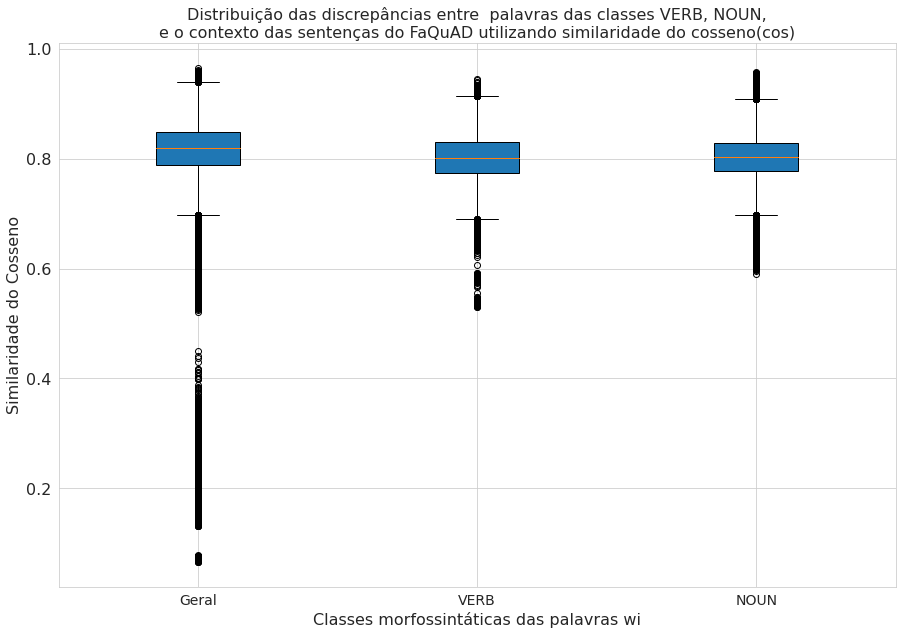

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count   983942.000000    94772.000000   227381.000000
mean        22.870999       26.880463       23.441122
std          4.020063        5.228289        3.363813
min          9.821314       10.839937        9.961720
25%         20.245739       23.133446       21.418997
50%         22.374681       26.268336       23.193701
75%         24.813072       30.031562       25.184427
max         48.347458       48.347458       45.588848

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


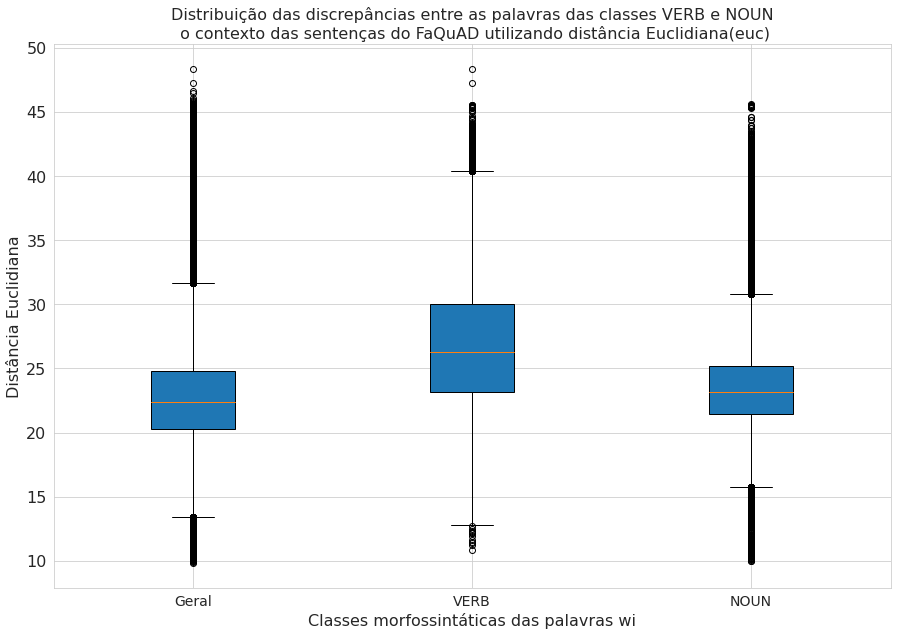

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count   983942.000000    94772.000000   227381.000000
mean      1097.141677     1246.931451     1103.906834
std        170.796698      197.635103      146.620825
min        470.890660      530.690060      470.890660
25%        984.761050     1110.051825     1014.914300
50%       1081.591700     1239.520900     1092.909400
75%       1192.954800     1375.950725     1186.339700
max       2106.689700     2106.689700     2051.299000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


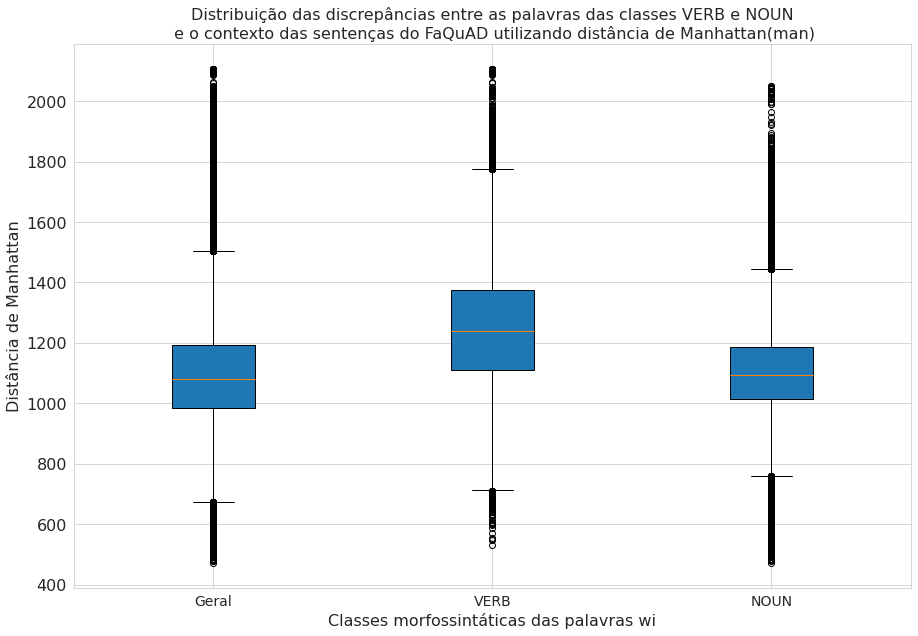

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 94772


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count       94772.000000       94772.000000      94772.000000   
mean            0.814885          25.915977          0.805361   
std             0.051488           4.786100          0.057376   
min             0.508645          11.666943          0.508645   
25%             0.786530          22.567921          0.772162   
50%             0.821845          25.296253          0.812929   
75%             0.849867          28.469099          0.845543   
max             0.937884          48.667980          0.937884   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count      94772.000000      94772.000000       94772.000000  
mean          26.595495       1239.852757        1207.178502  
std            4.592628        187.649065         190.113750  
min           13.860520        666.508900         571.876700  
25%           23.625104       1119.452175        1073.144875  
50%           26.033122       1227.332000        1195.580850  
75%           29.007051       1348.027425        1321.551550  
max           48.667980       2196.946800        2144.629400

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/94772 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        2 16662
      2        4 13084
      3        3 11084
      4        5 10061
      5        6  9666
      6        1  7974
      7        7  7085
      8        8  4908
      9        9  3470
     10       10  2380
     11       11  1943
     12       12  1644
     13       13  1457
     14       14  1255
     15       15   512
     16       16   429
     17        0   213
     18       20   202
     19       18   202
     20       41   101


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06333757936954498
Limite superior             : 0.9448735043406487
Limite inferior             : 0.6915231868624687


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2002 de 94772 ( 0.0211243827290761 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2002 de 94772 ( 0.0211243827290761 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 3 0.5309028625488281 quer
         O que quer dizer quando um professor acabam por avaliar a sua matéria através de seminários ao invés de provas ?

 4 0.5344935059547424 quer
         O que quer dizer quando um professor quer por avaliar a sua matéria através de seminários ao invés de provas ?

 5 0.5366173386573792 quer
         O que quer dizer quando um professor acabou por avaliar a sua matéria através de seminários ao invés de provas ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando devem ser destinados os pedidos de aproveitamento de atividades complementares ?
       1 0.8121825456619263 destinados
       2 0.6915003657341003 devem

 2 Quando devem ser marcados os pedidos de aproveitamento de atividades complementares ?
       1 0.817138135433197 marcados
       2 0.6914940476417542 devem

 3 O que os modelos utilizados pela engenharia de software dizem ?
       1 0.8032492399215698 utilizados
       2 0.6914732456207275 dizem

 4 A quem deve ser disponibilizado o aproveitamento das disciplinas cursadas em outro curso de graduação ?
       1 0.8313372731208801 cursadas
       2 0.7482514381408691 disponibilizado
       3 0.6914675235748291 deve

 5 Qual foi a necessidade que fez a lei da criação da FAPDF ser denominada pela lei nº 3.652 ?
       1 0.7841354012489319 denominada
       2 0.6914442777633667 fez


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07338054478168488
Limite superior             : 0.9556133523583412
Limite inferior             : 0.6620911732316017


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1811 de 94772 ( 0.01910901954163677 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1811 de 94772 ( 0.01910901954163677 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 3 0.5153413414955139 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que far os moradores de Brasília ” ?

 4 0.5166771411895752 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto explicar quais problemas matemáticos poderiam ser resolvidos por um método efetivo ?

 5 0.5167738199234009 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas f

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 o que o acadêmico deve dizer na fase de inscrição ?
       1 0.7330203652381897 deve
       2 0.6620664596557617 dizer

 2 O que Faz o MEC ?
       1 0.6620599031448364 Faz

 3 A quem o acadêmico pôde ir para revisar suas avaliações acadêmicas ?
       1 0.7977739572525024 revisar
       2 0.7553948760032654 pôde
       3 0.6619821786880493 ir

 4 O que a gestante deve ser para requisitar o regime de exercícios domiciliares ?
       1 0.7786780595779419 requisitar
       2 0.691896915435791 deve
       3 0.6619599461555481 ser

 5 Como ficaram toda a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.7435590028762817 ficaram
       2 0.7123897671699524 combinados
       3 0.6617923974990845 trazidas


##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.901178359985352
Limite superior             : 37.32086658477783
Limite inferior             : 13.716153144836426


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2333 de 94772 ( 0.02461697547798928 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7 de 94772 ( 7.386147807369266e-05 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2340 de 94772 ( 0.024690836956062973 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.6679801940918 Forma
         Quando se Forma a primeira turma de engenheiros de computação ?

 2 48.55094909667969 ir
         A quem o acadêmico tem ir para revisar suas avaliações acadêmicas ?

 3 48.26874542236328 Ter
         Qual foi o primeiro projeto a Ter apoio da instituição ?

 4 47.93706130981445 vindo
         Quem noticiou que o DF vindo a ser um novo exemplo de como a sociedade deve valorizar a atividade científica ?

 5 47.86766052246094 saber
         Qual foi o primeiro projeto a saber apoio da instituição ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.666942596435549 SGBDs
         O que não SGBDs ?

 2 12.595637321472168 UNIVASF
         O que eu UNIVASF ?

 3 12.951005935668944 SGBDs
         O que seria SGBDs ?

 4 13.00178337097168 FAPDF
         O que a FAPDF fazer ?

 5 13.486101150512695 armazenar
         Como tal armazenar números maiores na memória ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando se Forma a primeira turma de engenheiros de computação ?
       1 48.6679801940918 Forma

 2 A quem o acadêmico tem ir para revisar suas avaliações acadêmicas ?
       1 48.55094909667969 ir
       2 31.58614921569824 tem
       3 18.27511405944824 revisar

 3 Qual foi o primeiro projeto a Ter apoio da instituição ?
       1 48.26874542236328 Ter

 4 Quem noticiou que o DF vindo a ser um novo exemplo de como a sociedade deve valorizar a atividade científica ?
       1 47.93706130981445 vindo
       2 27.114990234375 deve
       3 26.60548973083496 noticiou
       4 23.476192474365234 valorizar

 5 Qual foi o primeiro projeto a saber apoio da instituição ?
       1 47.86766052246094 saber


##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.381947040557861
Limite superior             : 37.0799720287323
Limite inferior             : 15.552183866500854


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2763 de 94772 ( 0.02915418055965897 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 54 de 94772 ( 0.0005697885451399148 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2817 de 94772 ( 0.029723969104798884 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.6679801940918 Forma
         Quando se Forma a primeira turma de engenheiros de computação ?

 2 48.55094909667969 ir
         A quem o acadêmico tem ir para revisar suas avaliações acadêmicas ?

 3 48.26874542236328 Ter
         Qual foi o primeiro projeto a Ter apoio da instituição ?

 4 47.93706130981445 vindo
         Quem noticiou que o DF vindo a ser um novo exemplo de como a sociedade deve valorizar a atividade científica ?

 5 47.86766052246094 saber
         Qual foi o primeiro projeto a saber apoio da instituição ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 13.860520362854004 amar
         o que é amar ?

 2 13.950817108154297 amar
         O que é amar ?

 3 13.950817108154297 amar
         O que é amar ?

 4 13.950817108154297 amar
         O que é amar ?

 5 13.950817108154297 amar
         O que é amar ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando se Forma a primeira turma de engenheiros de computação ?
       1 48.6679801940918 Forma

 2 A quem o acadêmico tem ir para revisar suas avaliações acadêmicas ?
       1 48.55094909667969 ir
       2 31.58614921569824 tem
       3 22.26052474975586 revisar

 3 Qual foi o primeiro projeto a Ter apoio da instituição ?
       1 48.26874542236328 Ter

 4 Quem noticiou que o DF vindo a ser um novo exemplo de como a sociedade deve valorizar a atividade científica ?
       1 47.93706130981445 vindo
       2 30.325273513793945 noticiou
       3 27.723678588867188 valorizar
       4 27.114990234375 deve

 5 Qual foi o primeiro projeto a saber apoio da instituição ?
       1 47.86766052246094 saber


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 248.40667499999995
Limite superior             : 1694.1615625
Limite inferior             : 700.5348625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1338 de 94772 ( 0.01411809395180011 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 23 de 94772 ( 0.00024268771367070443 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1361 de 94772 ( 0.014360781665470813 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2144.6294 pegar
         O que pegar se o acadêmico não entregar as atividades na data estipulada ?

 2 2140.103 vão
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o vão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 2132.6099 devem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o devem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 2124.2686 têm
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o têm de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5 2111.2002 pegar
         O que pegar se o aluno reprovar no TCC ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 571.8767 SGBDs
         O que não SGBDs ?

 2 628.3025 UNIVASF
         O que eu UNIVASF ?

 3 629.6132 FAPDF
         O que a FAPDF fazer ?

 4 630.10645 SGBDs
         O que seria SGBDs ?

 5 656.79944 armazenar
         Como tal armazenar números maiores na memória ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que pegar se o acadêmico não entregar as atividades na data estipulada ?
       1 2144.6294 pegar
       2 1231.9053 entregar
       3 1032.222 estipulada

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o vão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2140.103 vão
       2 1485.6454 existir
       3 1456.2335 apresentar
       4 1386.4102 deve
       5 1305.4805 enquadrado
       6 1170.117 cursadas
       7 1047.2871 matricular

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o devem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2132.6099 devem
       2 1500.4673 existir
       3 1463.087 apresentar
       4 1403.6007 deve
       5 1311.397 enquadrado
       6 1171.1799 cursadas
       7 1046.9163 matricular

 4 Em qual

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 228.57524999999987
Limite superior             : 1690.8902999999998
Limite inferior             : 776.5893000000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1641 de 94772 ( 0.01731524078841852 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 144 de 94772 ( 0.0015194361203731059 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1785 de 94772 ( 0.018834676908791627 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2196.9468 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que terão os moradores de Brasília ” ?

 2 2190.541 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que fazer os moradores de Brasília ” ?

 3 2188.4102 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que poderão os moradores de Brasília ”

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 666.5089 amar
         o que é amar ?

 2 670.1235 amar
         O que é amar ?

 3 670.1235 amar
         O que é amar ?

 4 670.1235 amar
         O que é amar ?

 5 670.1235 amar
         O que é amar ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que terão os moradores de Brasília ” ?
       1 2196.9468 constituírem-se
       2 2070.6438 Há
       3 1804.0898 passava
       4 1554.3455 terão
       5 1474.0682 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que fazer os moradores de Brasília ” ?
       1 2190.541 constituírem-se
       2 2051.6965 Há
       3 1791.7925 passava
       4 1762.0852 fazer
       5 1485.9192 financiadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . 

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 227381


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count      227381.000000      227381.000000     227381.000000   
mean            0.824878          22.119868          0.813747   
std             0.046484           3.401137          0.055911   
min             0.553994          11.572813          0.553994   
25%             0.799501          19.923035          0.784017   
50%             0.830655          21.703913          0.823898   
75%             0.857666          23.822247          0.853898   
max             0.954357          47.667095          0.954357   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count     227381.000000     227381.000000      227381.000000  
mean          22.869682       1077.987351        1043.053722  
std            3.646337        166.484750         153.409081  
min           11.572813        565.882750         565.882750  
25%           20.362503        962.186770         942.843900  
50%           22.346411       1052.503400        1022.403500  
75%           24.873760       1173.065300        1122.976800  
max           47.667095       2159.257300        2159.257300

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/227381 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        3 29660
      2        5 27517
      3        4 24940
      4        6 21193
      5        2 20732
      6        7 19646
      7        8 17410
      8        9 14869
      9        1 11980
     10       10  8061
     11       11  7664
     12       12  5598
     13       13  4363
     14       14  3133
     15       15  2167
     16       17  1923
     17       16  1514
     18        0  1375
     19       18   909
     20       19   707


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05816549062728882
Limite superior             : 0.9449145495891571
Limite inferior             : 0.7122525870800018


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 27 de 227381 ( 0.00011874343062964804 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5020 de 227381 ( 0.022077482287438263 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5047 de 227381 ( 0.022196225718067914 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9543566703796388 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 0.9541686177253724 cursos
         Os cursos de pós-graduação mais quais cursos ?

 3 0.951800525188446 cursos
         Os cursos de pós-graduação seria quais cursos ?

 4 0.9515507817268372 cursos
         Os cursos de pós-graduação ou quais cursos ?

 5 0.9510447978973388 cursos
         Os cursos de pós-graduação E quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5539944767951965 partir
         a partir de quando o semestre de posicionamento é interrompido ?

 2 0.5544908046722412 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que conforme os moradores de Brasília ” ?

 3 0.5579372644424438 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que , os moradores de Brasília ” ?

 4 0.5592952966690063 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os re

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 por meio de quem as instituições de ensino superior participam definir as atribuições e os critérios de constituição do nde ?
       1 0.8143234848976135 nde
       2 0.809617817401886 constituição
       3 0.8094601035118103 instituições
       4 0.7714168429374695 atribuições
       5 0.7520346641540527 critérios
       6 0.7122511267662048 ensino
       7 0.6672717332839966 meio

 2 O que a UFMS vem participando do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 0.8363497853279114 preservação
       2 0.8247734308242798 recursos
       3 0.822767436504364 ambiente
       4 0.8139330148696899 ensino
       5 0.7691587209701538 UFMS
       6 0.7122510075569153 meio

 3 Quem decide o programa traduzido da necessidade do usuário pelo analista de sistemas ?
       1 0.8395504355430603 programa
       2 0.829823911190033 necessidade
       3 0.8257613778114319 usuário
       4 0.7822162508964539 analista
       5 0.7122481465339661 sistemas

 4 O trancamento 

##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0698813796043396
Limite superior             : 0.9587203562259674
Limite inferior             : 0.679194837808609


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 227381 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5594 de 227381 ( 0.02460187966452782 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5594 de 227381 ( 0.02460187966452782 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5539944767951965 partir
         a partir de quando o semestre de posicionamento é interrompido ?

 2 0.5544908046722412 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que conforme os moradores de Brasília ” ?

 3 0.5579372644424438 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que , os moradores de Brasília ” ?

 4 0.5592952966690063 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os re

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O candidato informa ter um vinculo efetivo com quem para se matricular sem passar pelo exame de seleção ?
       1 0.8415868282318115 candidato
       2 0.8089895248413086 seleção
       3 0.7583475708961487 exame
       4 0.6791885495185852 vinculo

 2 Quem foi responsável pela difusão do oficial de numeração hindu-arábico no Oriente Médio ?
       1 0.8049913048744202 oficial
       2 0.7744280099868774 difusão
       3 0.6791737675666809 numeração

 3 Por que grande parte dos eletroeletrônicos são formas de computação ?
       1 0.8818862438201904 computação
       2 0.8736584186553955 formas
       3 0.7235509753227234 eletroeletrônicos
       4 0.679173469543457 parte

 4 O candidato alega ter um vinculo efetivo com quem para se matricular sem passar pelo exame de seleção ?
       1 0.8481259942054749 candidato
       2 0.8202465772628784 seleção
       3 0.7743393182754517 exame
       4 0.6791630387306213 vinculo

 5 Por que foram úteis os cursos de pós-graduação profissiona

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.899211883544922
Limite superior             : 29.671064376831055
Limite inferior             : 14.074216842651367


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 7475


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 330 de 227381 ( 0.0014513085965845872 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7805 de 227381 ( 0.034325647261644554 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 47.66709518432617 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 46.655609130859375 nível
         O que é necessário para que um indivíduo se nível para obter a habilitação de professor nos países europeus ?

 3 46.59605407714844 apoio
         Qual foi o primeiro projeto a ser apoio da instituição ?

 4 45.73472213745117 parte
         Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?

 5 45.65447235107422 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.572813034057615 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 11.654969215393066 cursos
         Os cursos de pós-graduação mais quais cursos ?

 3 11.816518783569336 SGBDs
         O que esses SGBDs ?

 4 11.931535720825195 cursos
         Os cursos de pós-graduação ou quais cursos ?

 5 11.941802978515623 cursos
         Os cursos de pós-graduação E quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 47.66709518432617 em
       2 36.117130279541016 inicial
       3 30.768949508666992 caso
       4 30.114635467529297 carga
       5 24.519126892089844 semestre
       6 24.388620376586918 semestre
       7 24.186569213867188 disciplinas
       8 24.005002975463867 acadêmico
       9 22.77880859375 pré-requisitos

 2 O que é necessário para que um indivíduo se nível para obter a habilitação de professor nos países europeus ?
       1 46.655609130859375 nível
       2 23.77838516235352 países
       3 23.31808090209961 indivíduo
       4 23.25011444091797 habilitação
       5 22.796873092651367 professor

 3 Qual foi o primeiro projeto a ser apoio da instituição ?
       1 46.59605407714844 apoio
       2 16.41368293762207 projeto
       3 15.100414276123049 in

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.511257171630863
Limite superior             : 31.640645980834968
Limite inferior             : 13.595617294311515


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4577


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 91 de 227381 ( 0.00040020934027029523 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4668 de 227381 ( 0.020529419784414703 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 47.66709518432617 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 46.655609130859375 nível
         O que é necessário para que um indivíduo se nível para obter a habilitação de professor nos países europeus ?

 3 46.59605407714844 apoio
         Qual foi o primeiro projeto a ser apoio da instituição ?

 4 45.73472213745117 parte
         Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?

 5 45.65447235107422 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.572813034057615 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 11.654969215393066 cursos
         Os cursos de pós-graduação mais quais cursos ?

 3 11.931535720825195 cursos
         Os cursos de pós-graduação ou quais cursos ?

 4 11.941802978515623 cursos
         Os cursos de pós-graduação E quais cursos ?

 5 11.97961139678955 cursos
         Os cursos de pós-graduação Ou quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 47.66709518432617 em
       2 36.117130279541016 inicial
       3 31.407569885253903 pré-requisitos
       4 30.768949508666992 caso
       5 30.114635467529297 carga
       6 24.519126892089844 semestre
       7 24.388620376586918 semestre
       8 24.186569213867188 disciplinas
       9 24.005002975463867 acadêmico

 2 O que é necessário para que um indivíduo se nível para obter a habilitação de professor nos países europeus ?
       1 46.655609130859375 nível
       2 25.88298797607422 habilitação
       3 23.77838516235352 países
       4 23.31808090209961 indivíduo
       5 22.796873092651367 professor

 3 Qual foi o primeiro projeto a ser apoio da instituição ?
       1 46.59605407714844 apoio
       2 16.41368293762207 projeto
       3 15.10041427612304

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 180.13289999999995
Limite superior             : 1393.1761499999998
Limite inferior             : 672.64455


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 6975


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 291 de 227381 ( 0.0012797903078973177 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7266 de 227381 ( 0.03195517655388973 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2159.2573 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2115.6707 parte
         Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?

 3 2086.2373 parte
         Qual parte ser a ênfase do curso universitário dos analistas de sistemas ?

 4 2031.1559 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5 2030.7601 autor
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o autor de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 565.88275 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 569.7384 SGBDs
         O que esses SGBDs ?

 3 572.6366 cursos
         Os cursos de pós-graduação mais quais cursos ?

 4 580.0126 cursos
         Os cursos de pós-graduação E quais cursos ?

 5 581.7112 pergunta
         Qual foi a primeira pergunta ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2159.2573 em
       2 1601.6243 inicial
       3 1483.3855 caso
       4 1421.6633 carga
       5 1195.2805 semestre
       6 1158.6663 semestre
       7 1134.0559 pré-requisitos
       8 1117.5706 acadêmico
       9 1084.7943 disciplinas

 2 Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?
       1 2115.6707 parte
       2 1022.8174 frequência
       3 950.2908 acadêmico
       4 931.75854 disciplina

 3 Qual parte ser a ênfase do curso universitário dos analistas de sistemas ?
       1 2086.2373 parte
       2 1261.1643 sistemas
       3 1103.9014 ênfase
       4 998.56854 analistas
       5 900.6953 curso

 4 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no 

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 210.87852999999996
Limite superior             : 1489.383095
Limite inferior             : 645.8689750000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4257


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 68 de 227381 ( 0.00029905752899318767 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4325 de 227381 ( 0.01902093842493436 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2159.2573 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2115.6707 parte
         Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?

 3 2086.2373 parte
         Qual parte ser a ênfase do curso universitário dos analistas de sistemas ?

 4 2031.1559 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 5 2030.7601 autor
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o autor de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 565.88275 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 572.6366 cursos
         Os cursos de pós-graduação mais quais cursos ?

 3 580.0126 cursos
         Os cursos de pós-graduação E quais cursos ?

 4 581.7112 pergunta
         Qual foi a primeira pergunta ?

 5 581.80927 verdade
         o que é verdade ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2159.2573 em
       2 1601.6243 inicial
       3 1543.9661 pré-requisitos
       4 1483.3855 caso
       5 1421.6633 carga
       6 1195.2805 semestre
       7 1158.6663 semestre
       8 1117.5706 acadêmico
       9 1084.7943 disciplinas

 2 Qual parte ser a frequência do acadêmico para que seja aprovado em uma disciplina ?
       1 2115.6707 parte
       2 1022.8174 frequência
       3 950.2908 acadêmico
       4 931.75854 disciplina

 3 Qual parte ser a ênfase do curso universitário dos analistas de sistemas ?
       1 2086.2373 parte
       2 1261.1643 sistemas
       3 1188.4572 analistas
       4 1103.9014 ênfase
       5 900.6953 curso

 4 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no 

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count     983942.000000     983942.000000    983942.000000    983942.000000   
mean           0.792454         24.090632         0.784682        24.619538   
std            0.065662          3.902575         0.067411         3.849092   
min            0.090934          0.000000         0.090934         0.000000   
25%            0.758050         21.519072         0.749231        22.080595   
50%            0.797386         23.842826         0.789588        24.353966   
75%            0.834540         26.281051         0.827871        26.752311   
max            1.000000         48.667980         1.000000        48.667980   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count    983942.000000     983942.000000      94772.000000      94772.000000   
mean       1177.569083       1152.555472          0.814885         25.915977   
std         177.757707        180.869090          0.051488          4.786100   
min           0.000000          0.000000          0.508645         11.666943   
25%        1058.282775       1028.873475          0.786530         22.567921   
50%        1170.105750       1146.424200          0.821845         25.296253   
75%        1284.087650       1264.912800          0.849867         28.469099   
max        2416.819300       2159.257300          0.937884         48.667980   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count     94772.000000     94772.000000     94772.000000      94772.000000   
mean          0.805361        26.595495      1239.852757       1207.178502   
std           0.057376         4.592628       187.649065        190.113750   
min           0.508645        13.860520       666.508900        571.876700   
25%           0.772162        23.625104      1119.452175       1073.144875   
50%           0.812929        26.033122      1227.332000       1195.580850   
75%           0.845543        29.007051      1348.027425       1321.551550   
max           0.937884        48.667980      2196.946800       2144.629400   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count     227381.000000     227381.000000    227381.000000    227381.000000   
mean           0.824878         22.119868         0.813747        22.869682   
std            0.046484          3.401137         0.055911         3.646337   
min            0.553994         11.572813         0.553994        11.572813   
25%            0.799501         19.923035         0.784017        20.362503   
50%            0.830655         21.703913         0.823898        22.346411   
75%            0.857666         23.822247         0.853898        24.873760   
max            0.954357         47.667095         0.954357        47.667095   

                                          
      man_ctxclean_max man_ctxclean_mean  
count    227381.000000     227381.000000  
mean       1077.987351       1043.053722  
std         166.484750        153.409081  
min         565.882750        565.882750  
25%         962.186770        942.843900  
50%        1052.503400       1022.403500  
75%        1173.065300       1122.976800  
max        2159.257300       2159.257300

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count     983942.000000      94772.000000     227381.000000
mean           0.792454          0.814885          0.824878
std            0.065662          0.051488          0.046484
min            0.090934          0.508645          0.553994
25%            0.758050          0.786530          0.799501
50%            0.797386          0.821845          0.830655
75%            0.834540          0.849867          0.857666
max            1.000000          0.937884          0.954357

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


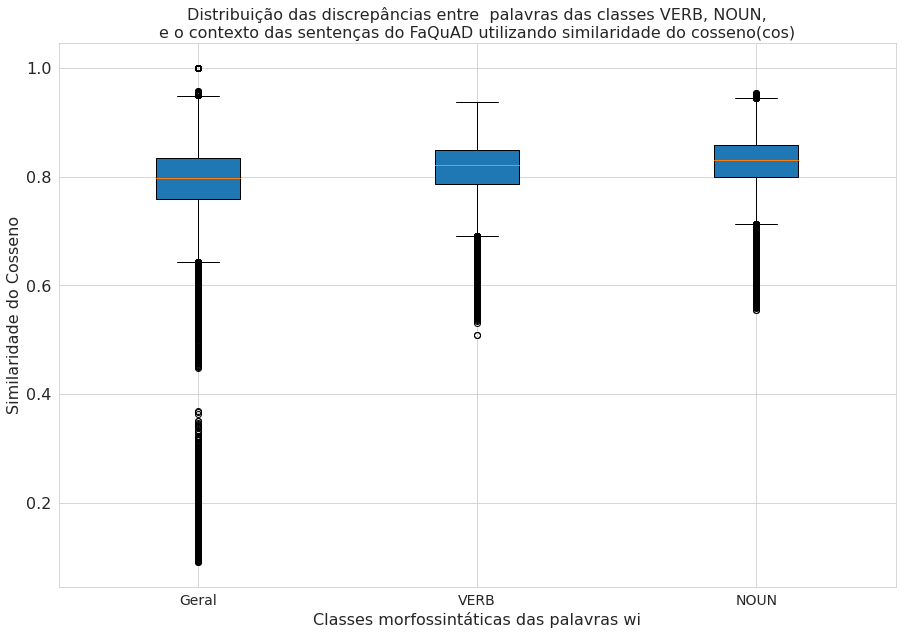

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count     983942.000000      94772.000000     227381.000000
mean          24.090632         25.915977         22.119868
std            3.902575          4.786100          3.401137
min            0.000000         11.666943         11.572813
25%           21.519072         22.567921         19.923035
50%           23.842826         25.296253         21.703913
75%           26.281051         28.469099         23.822247
max           48.667980         48.667980         47.667095

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


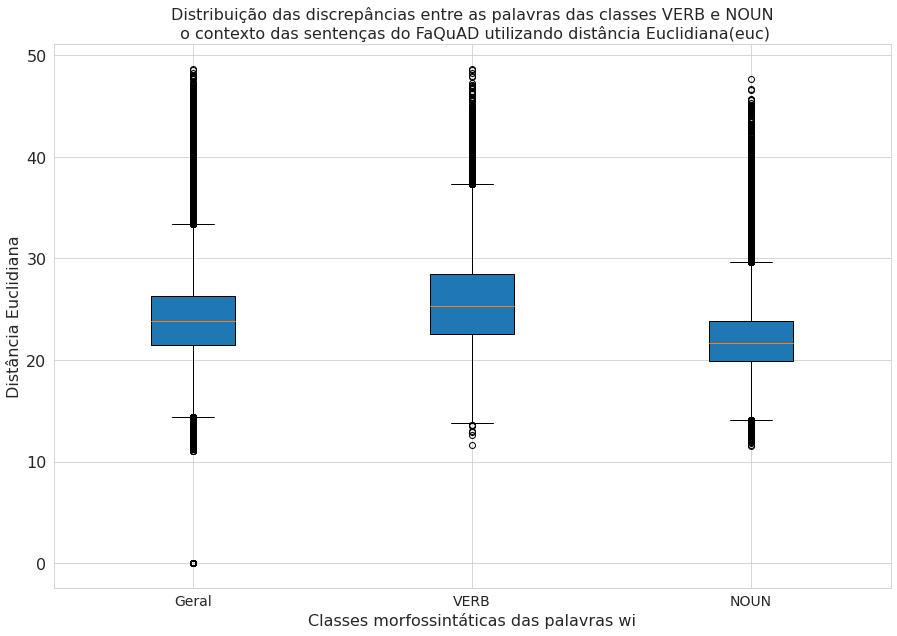

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count     983942.000000      94772.000000     227381.000000
mean        1152.555472       1207.178502       1043.053722
std          180.869090        190.113750        153.409081
min            0.000000        571.876700        565.882750
25%         1028.873475       1073.144875        942.843900
50%         1146.424200       1195.580850       1022.403500
75%         1264.912800       1321.551550       1122.976800
max         2159.257300       2144.629400       2159.257300

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


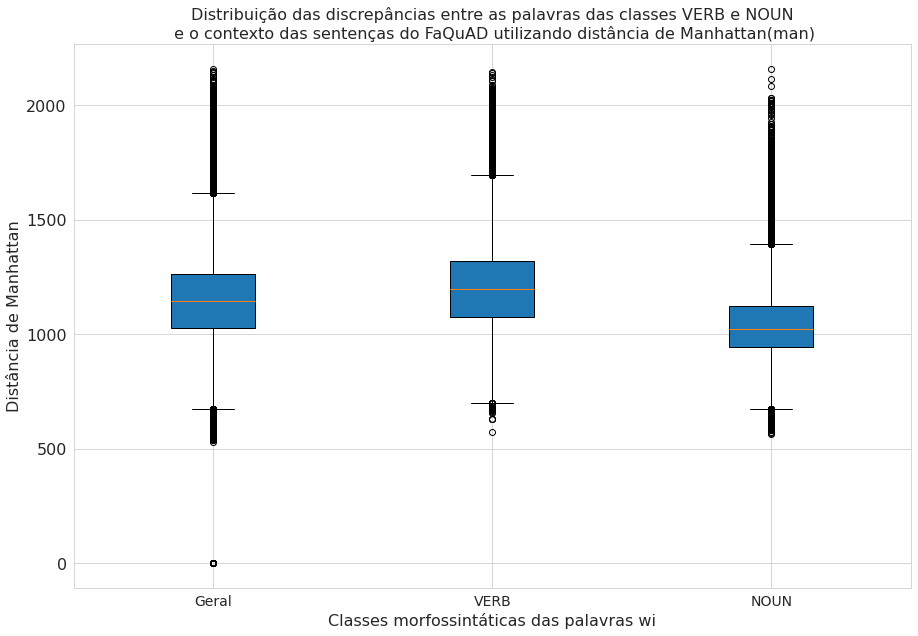

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 94772


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count      94772.000000      94772.000000      94772.000000     94772.000000   
mean           0.920410         14.439000        682.083490         0.910742   
std            0.062605          9.482429        445.599042         0.076560   
min            0.612299          0.000000          0.000000         0.506867   
25%            0.878380          0.000000          0.000000         0.869042   
50%            0.922367         17.502950        828.563324         0.920595   
75%            1.000000         20.934064        989.959991         1.000000   
max            1.000000         43.155338       1984.511963         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count     94772.000000     94772.000000  
mean         15.267254       721.841832  
std          10.008140       472.313747  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%          17.948420       846.733643  
75%          22.172814      1054.827789  
max          43.155338      2228.688477

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/94772 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        2 16662
      2        4 13084
      3        3 11084
      4        5 10061
      5        6  9666
      6        1  7974
      7        7  7085
      8        8  4908
      9        9  3470
     10       10  2380
     11       11  1943
     12       12  1644
     13       13  1457
     14       14  1255
     15       15   512
     16       16   429
     17        0   213
     18       20   202
     19       18   202
     20       41   101


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.12162019312381744
Limite superior             : 1.1824302896857262
Limite inferior             : 0.6959495171904564


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 158 de 94772 ( 0.0016671590765204912 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  158 de 94772 ( 0.0016671590765204912 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6122989654541016 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que são os moradores de Brasília ” ?

 2 0.6153641939163208 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que vivem os moradores de Brasília ” ?

 3 0.6157565712928772 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficia os moradores de Brasília ” ?

 4 0.61

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o sejam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 0.8333390951156616 matricular
       2 0.7931280136108398 apresentar
       3 0.7901608943939209 existir
       4 0.780007541179657 enquadrado
       5 0.7654989957809448 deve
       6 0.7020187973976135 cursadas
       7 0.6929380893707275 sejam

 2 A FAPDF tem finalidade de estimular , apoiar e financiar o desenvolvimento científico de qual âmbito ?
       1 0.9286755919456482 apoiar
       2 0.9029565453529358 estimular
       3 0.8973188996315002 financiar
       4 0.6928926706314087 tem

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o possam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 0.8384005427360535 matricular
      

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.13095827400684357
Limite superior             : 1.1964374110102654
Limite inferior             : 0.6726043149828911


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 919 de 94772 ( 0.009696956907103364 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  919 de 94772 ( 0.009696956907103364 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5068670511245728 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que far os moradores de Brasília ” ?

 2 0.5073080658912659 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que alegre os moradores de Brasília ” ?

 3 0.5090413689613342 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que conform

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficaram ificar a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.875433087348938 ficaram
       2 0.7617030739784241 ificar
       3 0.6723401546478271 combinados
       4 0.666300892829895 trazidas

 2 Por que a contagem do tempo cursado é feita a razão do ingresso do acadêmico na UFMS ?
       1 0.8832453489303589 feita
       2 0.6721380949020386 cursado

 3 Onde se revelam as médias de aproveitamento das disciplinas cursadas ?
       1 0.91575026512146 revelam
       2 0.6721222400665283 cursadas

 4 Como ficaram ser a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.85910564661026 ficaram
       2 0.6833558678627014 trazidas
       3 0.6720655560493469 combinados

 5 Como ficaram explica a série de inovações trazidas pelos pacotes de software combinados com a flexibilidade dos terminais ?
       1 0.8685843348503113 explica
       2 0.849259853363

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 20.93406391143799
Limite superior             : 52.33515977859497
Limite inferior             : -31.401095867156982


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 22.17281436920166
Limite superior             : 55.43203592300415
Limite inferior             : -33.25922155380249


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 989.9599914550781
Limite superior             : 2474.8999786376953
Limite inferior             : -1484.9399871826172


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 1054.8277893066406
Limite superior             : 2637.0694732666016
Limite inferior             : -1582.241683959961


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 227381


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count     201427.000000     201427.000000     201427.000000    201427.000000   
mean           0.637889         34.322311       1606.135672         0.628327   
std            0.071745          4.950207        203.736012         0.075686   
min            0.345415         15.457245        705.875366         0.278454   
25%            0.590356         30.855698       1463.132568         0.576887   
50%            0.642582         33.676716       1589.237183         0.633582   
75%            0.690285         37.083086       1736.048828         0.684499   
max            0.933831         59.515274       2540.894043         0.933831   

       euc_ctxverb_max  man_ctxverb_max  
count    201427.000000    201427.000000  
mean         34.875834      1631.146237  
std           4.984727       204.910248  
min          15.457245       705.875366  
25%          31.294722      1484.837646  
50%          34.310749      1616.906250  
75%          37.735640      1763.407227  
max          61.417854      2540.894043

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/227381 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        3 29660
      2        5 27517
      3        4 24940
      4        6 21193
      5        2 20732
      6        7 19646
      7        8 17410
      8        9 14869
      9        1 11980
     10       10  8061
     11       11  7664
     12       12  5598
     13       13  4363
     14       14  3133
     15       15  2167
     16       17  1923
     17       16  1514
     18        0  1375
     19       18   909
     20       19   707


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 227381 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 227381 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 227381 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 227381 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count    890489.000000    890489.000000    890489.000000   890489.000000   
mean          0.703328        29.929883      1417.360563        0.696702   
std           0.126006         9.437894       429.966294        0.129550   
min           0.032986         0.000000         0.000000        0.032986   
25%           0.624239        26.670330      1293.104980        0.615855   
50%           0.688701        31.247715      1496.843262        0.684451   
75%           0.759941        35.400875      1673.958740        0.756873   
max           1.000000        63.810551      2540.894043        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count   890489.000000   890489.000000     94772.000000     94772.000000   
mean        30.343672     1436.402345         0.920410        14.439000   
std          9.531643      433.535646         0.062605         9.482429   
min          0.000000        0.000000         0.612299         0.000000   
25%         26.933241     1306.060059         0.878380         0.000000   
50%         31.595461     1513.700439         0.922367        17.502950   
75%         35.938622     1695.692871         1.000000        20.934064   
max         63.810551     2741.983398         1.000000        43.155338   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count     94772.000000    94772.000000    94772.000000    94772.000000   
mean        682.083490        0.910742       15.267254      721.841832   
std         445.599042        0.076560       10.008140      472.313747   
min           0.000000        0.506867        0.000000        0.000000   
25%           0.000000        0.869042        0.000000        0.000000   
50%         828.563324        0.920595       17.948420      846.733643   
75%         989.959991        1.000000       22.172814     1054.827789   
max        1984.511963        1.000000       43.155338     2228.688477   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count    201427.000000    201427.000000    201427.000000   201427.000000   
mean          0.637889        34.322311      1606.135672        0.628327   
std           0.071745         4.950207       203.736012        0.075686   
min           0.345415        15.457245       705.875366        0.278454   
25%           0.590356        30.855698      1463.132568        0.576887   
50%           0.642582        33.676716      1589.237183        0.633582   
75%           0.690285        37.083086      1736.048828        0.684499   
max           0.933831        59.515274      2540.894043        0.933831   

                                       
      euc_ctxverb_max man_ctxverb_max  
count   201427.000000   201427.000000  
mean        34.875834     1631.146237  
std          4.984727      204.910248  
min         15.457245      705.875366  
25%         31.294722     1484.837646  
50%         34.310749     1616.906250  
75%         37.735640     1763.407227  
max         61.417854     2540.894043

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count    890489.000000     94772.000000    201427.000000
mean          0.703328         0.920410         0.637889
std           0.126006         0.062605         0.071745
min           0.032986         0.612299         0.345415
25%           0.624239         0.878380         0.590356
50%           0.688701         0.922367         0.642582
75%           0.759941         1.000000         0.690285
max           1.000000         1.000000         0.933831

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


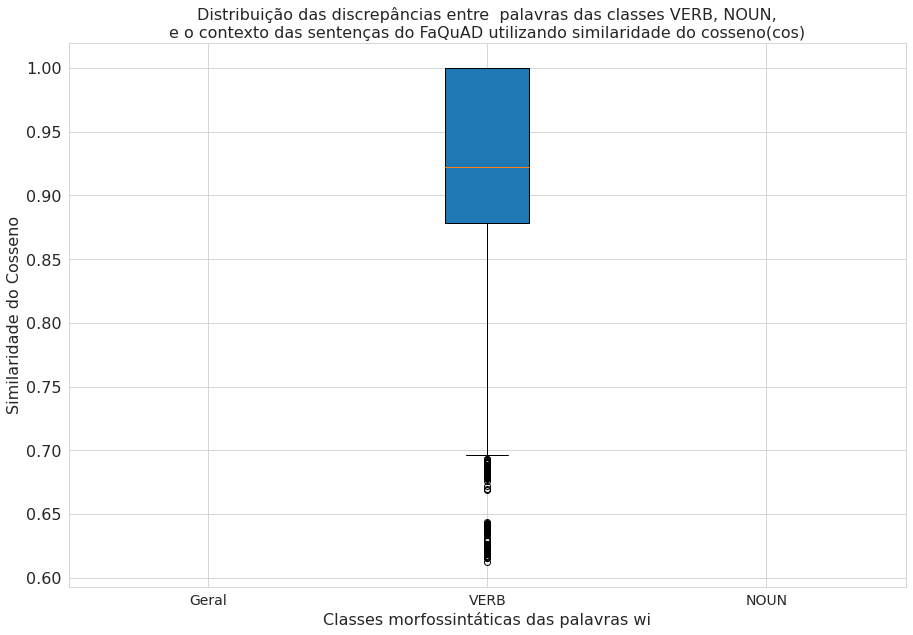

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count    890489.000000     94772.000000    201427.000000
mean         29.929883        14.439000        34.322311
std           9.437894         9.482429         4.950207
min           0.000000         0.000000        15.457245
25%          26.670330         0.000000        30.855698
50%          31.247715        17.502950        33.676716
75%          35.400875        20.934064        37.083086
max          63.810551        43.155338        59.515274

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


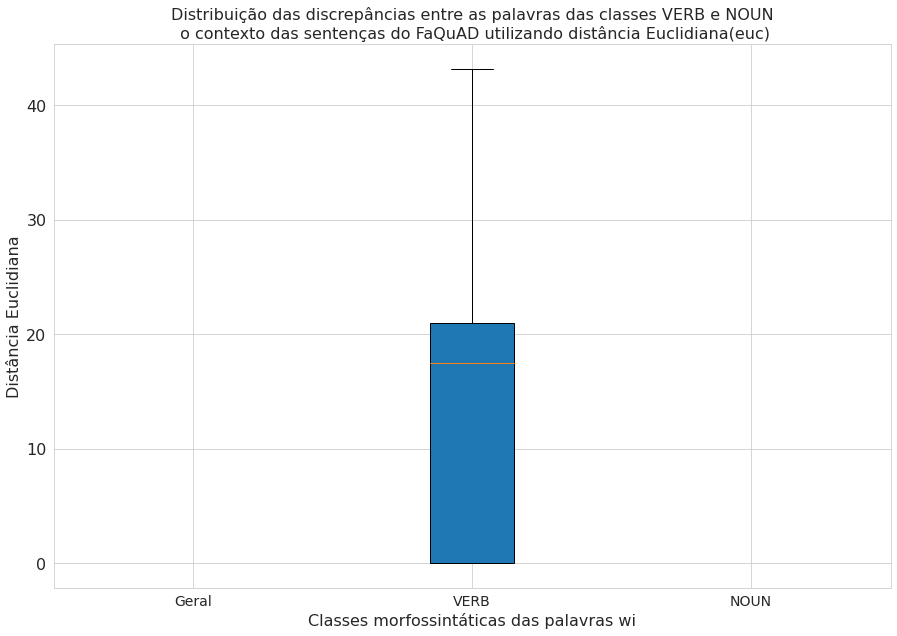

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count    890489.000000     94772.000000    201427.000000
mean       1417.360563       682.083490      1606.135672
std         429.966294       445.599042       203.736012
min           0.000000         0.000000       705.875366
25%        1293.104980         0.000000      1463.132568
50%        1496.843262       828.563324      1589.237183
75%        1673.958740       989.959991      1736.048828
max        2540.894043      1984.511963      2540.894043

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


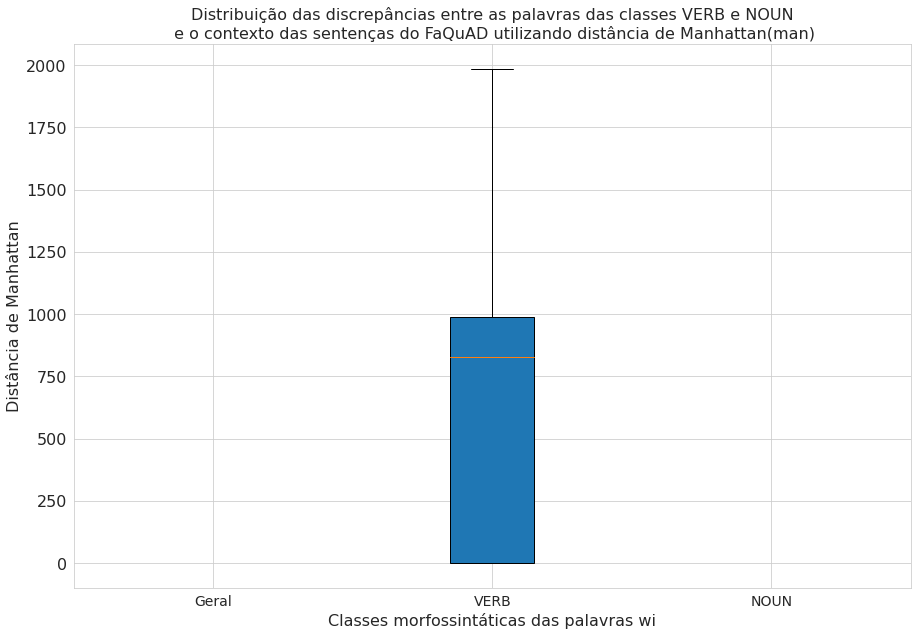

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 94772


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count      90328.000000      90328.000000      90328.000000     90328.000000   
mean           0.674627         33.348921       1553.465386         0.665848   
std            0.060814          5.171530        200.493338         0.059744   
min            0.389185         19.976191        963.460083         0.389185   
25%            0.636113         29.864343       1422.152100         0.628725   
50%            0.679514         32.588289       1539.189453         0.671469   
75%            0.716805         36.273765       1673.703613         0.707354   
max            0.866754         56.130772       2439.069336         0.866754   

       euc_ctxnoun_max  man_ctxnoun_max  
count     90328.000000     90328.000000  
mean         33.924425      1581.399283  
std           4.776986       184.945834  
min          19.976191       972.795471  
25%          30.583095      1454.918610  
50%          33.018665      1559.815308  
75%          36.522022      1691.722748  
max          56.130772      2439.069336

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/94772 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        2 16662
      2        4 13084
      3        3 11084
      4        5 10061
      5        6  9666
      6        1  7974
      7        7  7085
      8        8  4908
      9        9  3470
     10       10  2380
     11       11  1943
     12       12  1644
     13       13  1457
     14       14  1255
     15       15   512
     16       16   429
     17        0   213
     18       20   202
     19       18   202
     20       41   101


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 94772 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 94772 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 94772 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 227381


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count     227381.000000     227381.000000     227381.000000    227381.000000   
mean           0.878464         17.842733        839.995841         0.867145   
std            0.055983          6.239665        290.694901         0.065521   
min            0.615737          0.000000          0.000000         0.591915   
25%            0.842958         15.932339        754.412109         0.830918   
50%            0.877543         18.745926        883.820984         0.870362   
75%            0.911264         21.277746       1003.062256         0.907768   
max            1.000000         42.880272       1962.556152         1.000000   

       euc_ctxnoun_max  man_ctxnoun_max  
count    227381.000000    227381.000000  
mean         18.751448       882.971726  
std           6.394565       299.294060  
min           0.000000         0.000000  
25%          16.418564       776.452271  
50%          19.419411       915.575378  
75%          22.315260      1049.989746  
max          42.880272      1972.896240

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/227381 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        3 29660
      2        5 27517
      3        4 24940
      4        6 21193
      5        2 20732
      6        7 19646
      7        8 17410
      8        9 14869
      9        1 11980
     10       10  8061
     11       11  7664
     12       12  5598
     13       13  4363
     14       14  3133
     15       15  2167
     16       17  1923
     17       16  1514
     18        0  1375
     19       18   909
     20       19   707


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06830620765686024
Limite superior             : 1.0137236714363096
Limite inferior             : 0.7404988408088686


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 227381 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1875 de 227381 ( 0.008246071571503337 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1875 de 227381 ( 0.008246071571503337 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6157371997833252 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que são os moradores de Brasília ” ?

 2 0.6168939471244812 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que sejam os moradores de Brasília ” ?

 3 0.6184280514717102 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que se os moradores de Brasília ” ?

 4 0.

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que poderá ser tratado pela rádio FM Educativa por caráter experimental com a assinatura do termo de cessão ?
       1 0.8299612402915955 termo
       2 0.8274953365325928 assinatura
       3 0.823802649974823 cessão
       4 0.7902159690856934 caráter
       5 0.740498423576355 rádio

 2 a partir de quando o semestre de posicionamento é devido ?
       1 0.9174808263778688 semestre
       2 0.9167773723602296 posicionamento
       3 0.7404940724372864 partir

 3 Quanto do questionário irá ser respondido para que a carga horária de resposta ao questionário do estudante da Comissão Própria de Avaliação da UFMS seja válida ?
       1 0.838777482509613 questionário
       2 0.8215654492378235 questionário
       3 0.8211233019828796 estudante
       4 0.7976997494697571 carga
       5 0.7868772745132446 resposta
       6 0.7589814066886902 UFMS
       7 0.7404825091362 Avaliação

 4 Quanto do questionário necessitam ser respondido para que a carga horária de resposta ao questionário

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06830620765686024
Limite superior             : 1.0137236714363096
Limite inferior             : 0.7404988408088686


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 227381 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1875 de 227381 ( 0.008246071571503337 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1875 de 227381 ( 0.008246071571503337 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6157371997833252 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que são os moradores de Brasília ” ?

 2 0.6168939471244812 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que sejam os moradores de Brasília ” ?

 3 0.6184280514717102 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que se os moradores de Brasília ” ?

 4 0.

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que poderá ser tratado pela rádio FM Educativa por caráter experimental com a assinatura do termo de cessão ?
       1 0.8299612402915955 termo
       2 0.8274953365325928 assinatura
       3 0.823802649974823 cessão
       4 0.7902159690856934 caráter
       5 0.740498423576355 rádio

 2 a partir de quando o semestre de posicionamento é devido ?
       1 0.9174808263778688 semestre
       2 0.9167773723602296 posicionamento
       3 0.7404940724372864 partir

 3 Quanto do questionário irá ser respondido para que a carga horária de resposta ao questionário do estudante da Comissão Própria de Avaliação da UFMS seja válida ?
       1 0.838777482509613 questionário
       2 0.8215654492378235 questionário
       3 0.8211233019828796 estudante
       4 0.7976997494697571 carga
       5 0.7868772745132446 resposta
       6 0.7589814066886902 UFMS
       7 0.7404825091362 Avaliação

 4 Quanto do questionário necessitam ser respondido para que a carga horária de resposta ao questionário

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.345407485961914
Limite superior             : 29.295857429504395
Limite inferior             : 7.914227485656738


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 2798


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 16962 de 227381 ( 0.07459726186444778 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  19760 de 227381 ( 0.08690259960154982 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.88027191162109 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 42.77009201049805 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 42.76187896728516 dema
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o dema de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 42.757572174072266 rem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o rem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a 

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 professors
         O que os professors no Reino Unido geralmente necessitam ?

 3 0.0 professors
         O que os professors no Reino Unido geralmente servem ?

 4 0.0 professors
         O que os professors no Reino Unido geralmente afirmam ?

 5 0.0 professors
         O que os professors no Reino Unido geralmente queriam ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 42.88027191162109 corte
       2 33.61299514770508 inicial
       3 31.802959442138672 carga
       4 30.14398956298828 caso
       5 25.048290252685547 disciplinas
       6 23.635343551635746 acadêmico
       7 23.47661399841309 pré-requisitos
       8 22.39249992370605 semestre
       9 22.109455108642575 semestre

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 42.77009201049805 ex
       2 33.61250305175781 inicial
       3 31.91413688659668 carga
       4 29.87096405029297 caso
       5 25.114789962768555 disciplinas
       6 23.61332130432129 acadêmico
       7 23.436126708

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.896696090698242
Limite superior             : 31.160304069519043
Limite inferior             : 7.573519706726074


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 2480


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 14736 de 227381 ( 0.06480752569475902 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  17216 de 227381 ( 0.0757143296933341 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.88027191162109 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 42.77009201049805 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 42.76187896728516 dema
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o dema de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 42.757572174072266 rem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o rem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a 

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 calendário
         O calendário acadêmico é apresentado por quem ?

 3 0.0 calendário
         O calendário acadêmico é representado por quem ?

 4 0.0 calendário
         O calendário acadêmico é desenvolvido por quem ?

 5 0.0 calendário
         O calendário acadêmico é modificado por quem ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 42.88027191162109 corte
       2 33.61299514770508 inicial
       3 32.017906188964844 pré-requisitos
       4 31.802959442138672 carga
       5 30.14398956298828 caso
       6 25.048290252685547 disciplinas
       7 23.635343551635746 acadêmico
       8 22.39249992370605 semestre
       9 22.109455108642575 semestre

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 42.77009201049805 ex
       2 33.61250305175781 inicial
       3 31.91413688659668 carga
       4 31.91328239440918 pré-requisitos
       5 29.87096405029297 caso
       6 25.114789962768555 disciplinas
       7 23.613

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 248.650146484375
Limite superior             : 1376.0374755859375
Limite inferior             : 381.4368896484375


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1941


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 16962 de 227381 ( 0.07459726186444778 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  18903 de 227381 ( 0.08313359515526803 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1962.55615234375 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 1962.5126953125 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 1956.559326171875 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 1955.681396484375 força
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o força de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disc

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 347.27642822265625 memória
         Qual a memória da memória ?

 2 347.2763977050781 memória
         Qual a memória da memória ?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 5 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 1962.55615234375 corte
       2 1528.7359619140625 inicial
       3 1483.96484375 carga
       4 1450.027587890625 caso
       5 1169.459716796875 pré-requisitos
       6 1106.3150634765625 disciplinas
       7 1080.9150390625 acadêmico
       8 1080.6044921875 semestre
       9 1040.605712890625 semestre

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 1962.5126953125 em
       2 1523.1663818359375 inicial
       3 1492.944580078125 carga
       4 1441.5823974609375 caso
       5 1171.544677734375 pré-requisitos
       6 1108.09375 disciplinas
       7 1087.039306640625 semestre

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 273.5374755859375
Limite superior             : 1460.2959594726562
Limite inferior             : 366.14605712890625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 2315


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 14736 de 227381 ( 0.06480752569475902 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  17051 de 227381 ( 0.0749886753950418 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1972.896240234375 idem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o idem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 1962.55615234375 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 1962.5126953125 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 1956.559326171875 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de discip

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 347.27642822265625 memória
         Qual a memória da memória ?

 2 347.2763977050781 memória
         Qual a memória da memória ?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 5 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o idem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 1972.896240234375 idem
       2 1596.70947265625 pré-requisitos
       3 1529.330322265625 inicial
       4 1457.436279296875 carga
       5 1456.90283203125 caso
       6 1100.9581298828125 disciplinas
       7 1073.90234375 semestre
       8 1067.206298828125 acadêmico
       9 1033.6845703125 semestre

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 1962.55615234375 corte
       2 1568.308837890625 pré-requisitos
       3 1528.7359619140625 inicial
       4 1483.96484375 carga
       5 1450.027587890625 caso
       6 1106.3150634765625 disciplinas
       7 1080.9150390625 ac

#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count    946037.000000    946037.000000    946037.000000   946037.000000   
mean          0.733084        27.046579      1289.856663        0.726117   
std           0.108607         7.160535       337.203670        0.108890   
min           0.044573         0.000000         0.000000        0.044573   
25%           0.662673        23.723320      1132.094727        0.657253   
50%           0.721446        27.891460      1342.078613        0.715608   
75%           0.797683        31.321257      1504.848999        0.786286   
max           1.000000        56.130772      2561.145264        1.000000   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count   946037.000000   946037.000000     90328.000000     90328.000000   
mean        27.528893     1312.632439         0.674627        33.348921   
std          7.032568      330.856803         0.060814         5.171530   
min          0.000000        0.000000         0.389185        19.976191   
25%         24.364519     1167.925537         0.636113        29.864343   
50%         28.231262     1358.017090         0.679514        32.588289   
75%         31.652124     1519.281738         0.716805        36.273765   
max         56.130772     2573.300781         0.866754        56.130772   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count     90328.000000    90328.000000    90328.000000    90328.000000   
mean       1553.465386        0.665848       33.924425     1581.399283   
std         200.493338        0.059744        4.776986      184.945834   
min         963.460083        0.389185       19.976191      972.795471   
25%        1422.152100        0.628725       30.583095     1454.918610   
50%        1539.189453        0.671469       33.018665     1559.815308   
75%        1673.703613        0.707354       36.522022     1691.722748   
max        2439.069336        0.866754       56.130772     2439.069336   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count    227381.000000    227381.000000    227381.000000   227381.000000   
mean          0.878464        17.842733       839.995841        0.867145   
std           0.055983         6.239665       290.694901        0.065521   
min           0.615737         0.000000         0.000000        0.591915   
25%           0.842958        15.932339       754.412109        0.830918   
50%           0.877543        18.745926       883.820984        0.870362   
75%           0.911264        21.277746      1003.062256        0.907768   
max           1.000000        42.880272      1962.556152        1.000000   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count   227381.000000   227381.000000  
mean        18.751448      882.971726  
std          6.394565      299.294060  
min          0.000000        0.000000  
25%         16.418564      776.452271  
50%         19.419411      915.575378  
75%         22.315260     1049.989746  
max         42.880272     1972.896240

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count    946037.000000     90328.000000    227381.000000
mean          0.733084         0.674627         0.878464
std           0.108607         0.060814         0.055983
min           0.044573         0.389185         0.615737
25%           0.662673         0.636113         0.842958
50%           0.721446         0.679514         0.877543
75%           0.797683         0.716805         0.911264
max           1.000000         0.866754         1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


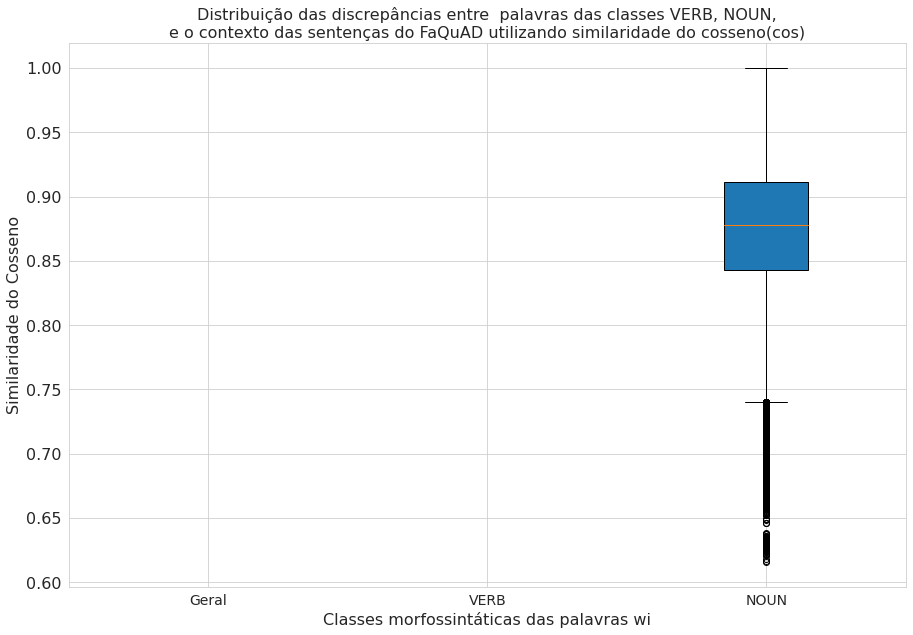

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count    946037.000000     90328.000000    227381.000000
mean         27.046579        33.348921        17.842733
std           7.160535         5.171530         6.239665
min           0.000000        19.976191         0.000000
25%          23.723320        29.864343        15.932339
50%          27.891460        32.588289        18.745926
75%          31.321257        36.273765        21.277746
max          56.130772        56.130772        42.880272

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


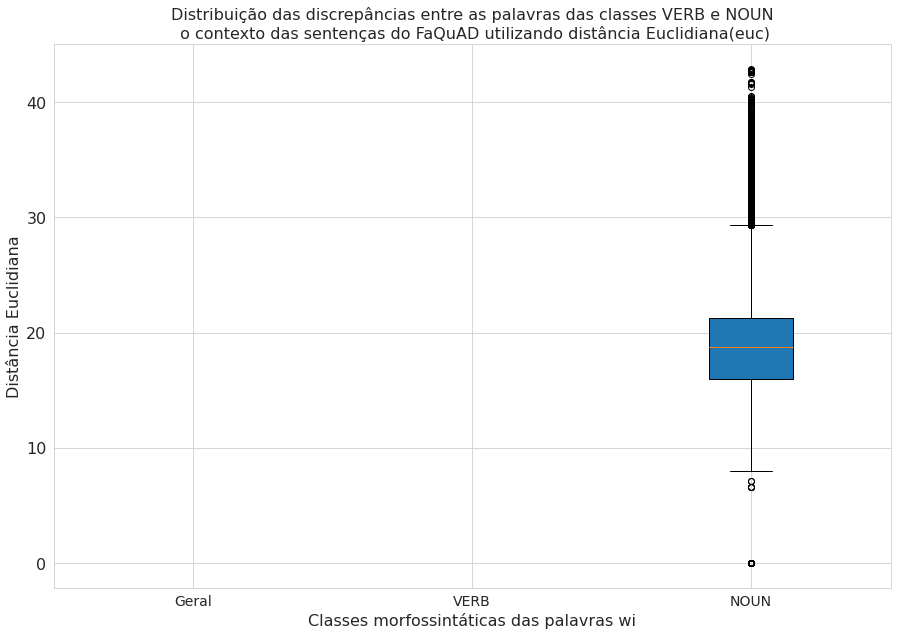

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count    946037.000000     90328.000000    227381.000000
mean       1289.856663      1553.465386       839.995841
std         337.203670       200.493338       290.694901
min           0.000000       963.460083         0.000000
25%        1132.094727      1422.152100       754.412109
50%        1342.078613      1539.189453       883.820984
75%        1504.848999      1673.703613      1003.062256
max        2561.145264      2439.069336      1962.556152

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


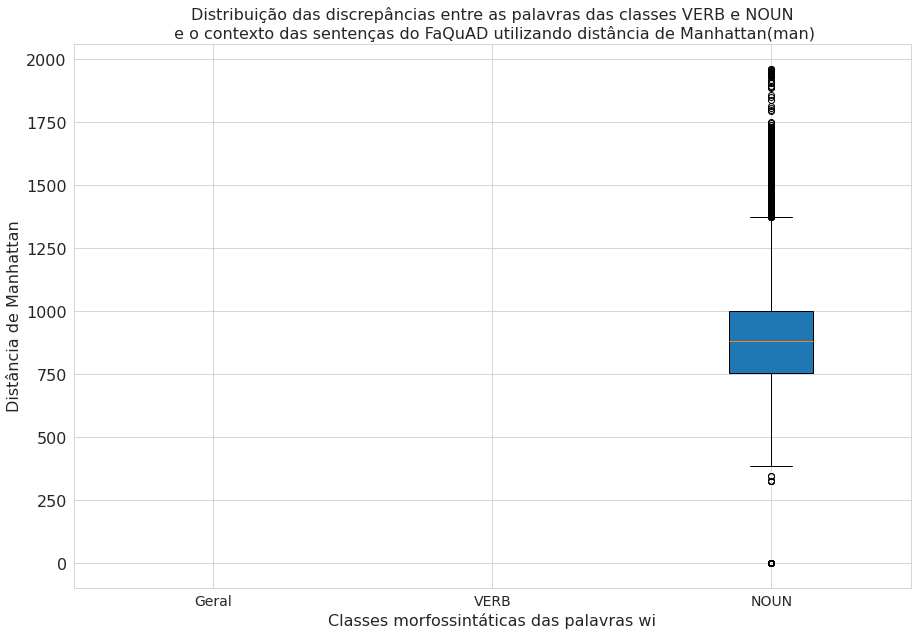

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 94772


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count          94772.000000          94772.000000          94772.000000   
mean               0.849121             23.296995           1087.148138   
std                0.050819              5.902103            255.320942   
min                0.565885              0.000000              0.000000   
25%                0.819829             20.509922            977.258896   
50%                0.848320             23.199769           1097.783142   
75%                0.876866             26.408145           1230.441986   
max                1.000000             44.780048           2057.369873   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count         94772.000000         94772.000000         94772.000000  
mean              0.839534            23.997800          1120.826461  
std               0.060686             5.980004           264.954590  
min               0.500156             0.000000             0.000000  
25%               0.807964            21.220235          1008.485291  
50%               0.842601            24.112951          1137.373291  
75%               0.874138            27.197280          1268.696106  
max               1.000000            44.780048          2214.292969

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/94772 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        2 16662
      2        4 13084
      3        3 11084
      4        5 10061
      5        6  9666
      6        1  7974
      7        7  7085
      8        8  4908
      9        9  3470
     10       10  2380
     11       11  1943
     12       12  1644
     13       13  1457
     14       14  1255
     15       15   512
     16       16   429
     17        0   213
     18       20   202
     19       18   202
     20       41   101


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05703730881214142
Limite superior             : 0.9624219611287117
Limite inferior             : 0.734272725880146


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2331 de 94772 ( 0.024595872198539655 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1444 de 94772 ( 0.015236567762630313 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3775 de 94772 ( 0.03983243996116997 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 é
         Como é para Alan Turing ?

 2 1.0 fez
         Quem fez o Ministério da Saúde ?

 3 1.0 escolhe
         Quem escolhe o Ministério da Saúde ?

 4 1.0 ocupa
         Quem ocupa o Ministério da Saúde ?

 5 1.0 assume
         Quem assume o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.565884530544281 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que alegre os moradores de Brasília ” ?

 2 0.5658921599388123 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que agrade os moradores de Brasília ” ?

 3 0.5660501718521118 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que vivem os moradores de Brasília ” ?

 4 0.566

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que comprar se o acadêmico não entregar as atividades na data estipulada ?
       1 0.8063585758209229 entregar
       2 0.7918830513954163 estipulada
       3 0.7342087030410767 comprar

 2 Quando ocorrem as inscrições para o disciplinas do programa de mestrado sem passar pelo exame de seleção ?
       1 0.7342040538787842 ocorrem
       2 0.7158946394920349 passar

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o permit de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 0.8480608463287354 matricular
       2 0.7689170837402344 apresentar
       3 0.7685999274253845 existir
       4 0.7430355548858643 enquadrado
       5 0.7341887950897217 deve
       6 0.7124423384666443 cursadas

 4 O que acontece caso o acadêmico não renove a matrícula e estiver impedido de assistir ?
       1 0.8273023962974548 renove
       2 0.7970333695411682 assistir
       3 0.73

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06617367267608643
Limite superior             : 0.9733981341123581
Limite inferior             : 0.7087034434080124


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2314 de 94772 ( 0.024416494323217828 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2242 de 94772 ( 0.023656776263031275 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4556 de 94772 ( 0.048073270586249106 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 é
         Como é para Alan Turing ?

 2 1.0 inclui
         Quem inclui o Ministério da Saúde ?

 3 1.0 ocupa
         Quem ocupa o Ministério da Saúde ?

 4 1.0 assume
         Quem assume o Ministério da Saúde ?

 5 1.0 substitui
         Quem substitui o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.500156044960022 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que far os moradores de Brasília ” ?

 2 0.5002651810646057 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que alegre os moradores de Brasília ” ?

 3 0.5024120807647705 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que conforme

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teoria investiga as questões relativas à possibilidade de realizar certos tipos de computação em quaisquer tipos de máquina ?
       1 0.8199304938316345 realizar
       2 0.7086754441261292 investiga

 2 O que passar se o aluno reprovar no TCC ?
       1 0.8312101364135742 passar
       2 0.7086674571037292 reprovar

 3 o que poderá com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte ?
       1 0.7088768482208252 poderá
       2 0.7086400389671326 trancado

 4 Quando as vagas nas disciplinas finais no período de posicionamento do discente não são garantidas ?
       1 0.7085241675376892 garantidas

 5 O que acontece caso o Aluno Especial não conseguiu o aproveitamento das duas disciplinas cursadas até a data de matrícula ?
       1 0.7616674304008484 conseguiu
       2 0.7085155248641968 acontece
       3 0.6735404133796692 cursadas


##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.898223876953132
Limite superior             : 35.25548124313356
Limite inferior             : 11.66258573532103


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1906 de 94772 ( 0.02011142531549403 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2331 de 94772 ( 0.024595872198539655 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4237 de 94772 ( 0.044707297514033684 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.78004837036133 defendem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 44.77944946289063 irão
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o irão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 44.75069046020508 possibil
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o possibil de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 44.741336822509766 pudessem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o pudessem de se matricular no semestre mais próximo ao inicial em que apresentar maior car

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 é
         Como é para Alan Turing ?

 2 0.0 escolhe
         Quem escolhe o Ministério da Saúde ?

 3 0.0 ocupa
         Quem ocupa o Ministério da Saúde ?

 4 0.0 assume
         Quem assume o Ministério da Saúde ?

 5 0.0 substitui
         Quem substitui o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.78004837036133 defendem
       2 31.64667320251465 existir
       3 29.634105682373047 apresentar
       4 27.026275634765625 deve
       5 26.757984161376957 enquadrado
       6 26.25993156433105 cursadas
       7 20.805021286010746 matricular

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o irão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.77944946289063 irão
       2 31.46475982666016 existir
       3 29.56542015075684 apresentar
       4 27.00848960876465 deve
       5 26.604846954345703 enquadrado
       6 26.305662155151367 cursadas
       7 20.851865768432617 matricular

 3 Em qual semestre o acadêmico deve ser

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.97704553604126
Limite superior             : 36.162848711013794
Limite inferior             : 12.254666566848755


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1603 de 94772 ( 0.016914278478875618 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2332 de 94772 ( 0.024606423838264467 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3935 de 94772 ( 0.041520702317140085 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.78004837036133 defendem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 44.77944946289063 irão
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o irão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 44.75069046020508 possibil
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o possibil de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 44.741336822509766 pudessem
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o pudessem de se matricular no semestre mais próximo ao inicial em que apresentar maior car

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 é
         Como é para Alan Turing ?

 2 0.0 ocupa
         Quem ocupa o Ministério da Saúde ?

 3 0.0 assume
         Quem assume o Ministério da Saúde ?

 4 0.0 substitui
         Quem substitui o Ministério da Saúde ?

 5 0.0 diz
         Quem diz o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o defendem de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.78004837036133 defendem
       2 35.35099792480469 cursadas
       3 31.73444366455078 enquadrado
       4 31.64667320251465 existir
       5 29.634105682373047 apresentar
       6 27.026275634765625 deve
       7 26.011438369750977 matricular

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o irão de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.77944946289063 irão
       2 35.44479751586914 cursadas
       3 31.59272003173828 enquadrado
       4 31.46475982666016 existir
       5 29.56542015075684 apresentar
       6 27.00848960876465 deve
       7 25.866065979003903 matricular

 3 Em qual semestre o acadêmico deve ser en

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 253.18309020996094
Limite superior             : 1610.2166213989258
Limite inferior             : 597.484260559082


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 944 de 94772 ( 0.009960747900223695 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2350 de 94772 ( 0.024796353353311106 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3294 de 94772 ( 0.034757101253534796 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2057.369873046875 haja
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2048.90576171875 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que tornaram os moradores de Brasília ” ?

 3 2047.507568359375 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que torna os moradores de Brasília ” ?

 4 2047.1248779296875 Há
         De quem foram as palavras “ Há pouco tempo não pas

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 597.020751953125 preso
         Quando Eduba foi preso ?

 2 596.228759765625 feita
         Quando Eduba foi feita ?

 3 594.357666015625 dispensado
         Quando Eduba foi dispensado ?

 4 592.7101440429688 afastado
         Quando Eduba foi afastado ?

 5 591.1295166015625 acompanha
         O que o Siscad considera , acompanha e divulga ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o haja de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2057.369873046875 haja
       2 1483.324462890625 existir
       3 1448.301513671875 apresentar
       4 1311.19970703125 deve
       5 1290.25341796875 enquadrado
       6 1208.575927734375 cursadas
       7 1038.8531494140625 matricular

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que tornaram os moradores de Brasília ” ?
       1 2048.90576171875 Há
       2 1729.6070556640625 passava
       3 1326.171630859375 tornaram
       4 1226.2818603515625 financiadas
       5 1216.378173828125 constituírem-se

 3 De quem foram as palavras “ Há pouco te

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 260.2108154296875
Limite superior             : 1659.0123291015625
Limite inferior             : 618.1690673828125


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 948 de 94772 ( 0.010002954459122948 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2393 de 94772 ( 0.025250073861478074 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3341 de 94772 ( 0.035253028320601024 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2214.29296875 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que se os moradores de Brasília ” ?

 2 2214.150634765625 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que efetivamente os moradores de Brasília ” ?

 3 2213.9716796875 constituírem-se
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que terão os mo

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 618.0530395507812 usado
         Em que foi usado o Mark I ?

 2 616.9524536132812 demitido
         Quando Eduba foi demitido ?

 3 616.8480224609375 acompanha
         O que o Siscad monitora , acompanha e divulga ?

 4 616.2833862304688 citado
         Quando Eduba foi citado ?

 5 616.1295166015625 acompanha
         O que o Siscad publica , acompanha e divulga ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que se os moradores de Brasília ” ?
       1 2214.29296875 constituírem-se
       2 2031.59765625 Há
       3 1707.4041748046875 passava
       4 1492.379150390625 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituírem-se em fatos que efetivamente os moradores de Brasília ” ?
       1 2214.150634765625 constituírem-se
       2 2030.7030029296875 Há
       3 1708.7069091796875 passava
       4 1497.098388671875 financiadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade i

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 227381


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count         227381.000000         227381.000000         227381.000000   
mean               0.840483             21.135618            994.400948   
std                0.047335              3.562932            161.556768   
min                0.589180              0.000000              0.000000   
25%                0.810611             19.058023            901.303894   
50%                0.843045             21.087414            992.113281   
75%                0.872600             23.125341           1086.870483   
max                1.000000             44.897823           2031.854004   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count        227381.000000        227381.000000        227381.000000  
mean              0.829347            21.895085          1029.738513  
std               0.058875             3.962297           181.371779  
min               0.535262             0.000000             0.000000  
25%               0.797559            19.455410           919.235596  
50%               0.837205            21.647518          1017.476379  
75%               0.869424            24.168236          1135.876465  
max               1.000000            44.897823          2031.854004

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/227381 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra   #wi
      1        3 29660
      2        5 27517
      3        4 24940
      4        6 21193
      5        2 20732
      6        7 19646
      7        8 17410
      8        9 14869
      9        1 11980
     10       10  8061
     11       11  7664
     12       12  5598
     13       13  4363
     14       14  3133
     15       15  2167
     16       17  1923
     17       16  1514
     18        0  1375
     19       18   909
     20       19   707


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06198924779891968
Limite superior             : 0.965584009885788
Limite inferior             : 0.7176270186901093


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 890 de 227381 ( 0.00391413530594025 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2587 de 227381 ( 0.011377379816255535 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3477 de 227381 ( 0.015291515122195787 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 soluções
         O que as soluções tecnológicas mais ?

 2 1.0 líder
         Qual a maior líder sindical docente de Portugal ?

 3 1.0 força
         Qual a maior força sindical docente de Portugal ?

 4 1.0 entidade
         Qual a maior entidade sindical docente de Portugal ?

 5 1.0 estrutura
         Qual a maior estrutura sindical docente de Portugal ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5891802310943604 gestação
         Gestantes Pode ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 2 0.590925931930542 gestação
         Gestantes costuma ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 3 0.5925097465515137 gestação
         Gestantes receberam ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 4 0.5925241708755493 gestação
         Gestantes poderem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 5 0.5994164943695068 gestação
         Gestantes deve ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Onde reside um destaque para a engenharia de software ?
       1 0.8573294878005981 destaque
       2 0.8410452604293823 Onde
       3 0.7962846755981445 engenharia
       4 0.717613697052002 software

 2 Quando o curso de Engenharia de Sistemas e Computação da UERJ começou a organizar ?
       1 0.8178442716598511 curso
       2 0.8064108490943909 UERJ
       3 0.7176077365875244 Computação

 3 Quem é considerado o autor da frase ” Ciência da Computação tem tanto a perder com o computador como a astronomia com o telescópio [ … ] " ?
       1 0.7767331600189209 autor
       2 0.7600817680358887 astronomia
       3 0.730014979839325 telescópio
       4 0.727909505367279 frase
       5 0.7175731062889099 computador

 4 A quem é credita a frase " Ciência orientada para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ?
       1 0.8403608202934265 hidrodinâmica
       2 0.8056228756904602 Ciência
       3 0.7432711124420166 frase
       4 0.71869

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07186490297317505
Limite superior             : 0.9772216379642487
Limite inferior             : 0.6897620260715485


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 793 de 227381 ( 0.003487538536641144 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5679 de 227381 ( 0.024975701575769303 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  6472 de 227381 ( 0.028463240112410446 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 soluções
         O que as soluções tecnológicas mais ?

 2 1.0 estrutura
         Qual a maior estrutura sindical docente de Portugal ?

 3 1.0 base
         Qual a maior base sindical docente de Portugal ?

 4 1.0 representação
         Qual a maior representação sindical docente de Portugal ?

 5 1.0 massa
         Qual a maior massa sindical docente de Portugal ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5352619290351868 gestação
         Gestantes receberam ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 2 0.5357473492622375 gestação
         Gestantes costuma ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 3 0.5392299294471741 gestação
         Gestantes Pode ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 4 0.5397169589996338 gestação
         Gestantes poderem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 5 0.5450561046600342 gestação
         Gestantes deve ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o inib de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 0.7947391867637634 semestre
       2 0.789253830909729 semestre
       3 0.7797802686691284 acadêmico
       4 0.7519291043281555 disciplinas
       5 0.7445444464683533 inicial
       6 0.7129268646240234 caso
       7 0.6897483468055725 pré-requisitos
       8 0.6742398142814636 carga

 2 Qual a carga horária em hora-aula para disciplinas distribuídas ?
       1 0.862766444683075 disciplinas
       2 0.860560417175293 carga
       3 0.6897459626197815 hora-aula

 3 Em qual ano os alunos de colação de grau poderão ser matriculados em disciplinas sem que tenham passado todos os pré-requisitos ?
       1 0.8674360513687134 alunos
       2 0.8170562386512756 ano
       3 0.7988846302032471 disciplinas
       4 0.6897447109222412 grau
       5 0.623978197574615

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.067317962646488
Limite superior             : 29.226318359375007
Limite inferior             : 12.957046508789057


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4242


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1245 de 227381 ( 0.005475391523478215 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5487 de 227381 ( 0.024131303846847363 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.89782333374024 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 44.80584335327149 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 44.77809524536133 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 44.758567810058594 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de discip

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas mais ?

 2 0.0 ambiente
         Qual o ambiente do POSCOMP ?

 3 0.0 índice
         Qual o índice do POSCOMP ?

 4 0.0 cenário
         Qual o cenário do POSCOMP ?

 5 0.0 aplicativo
         Qual o aplicativo do POSCOMP ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.89782333374024 corte
       2 35.84583282470703 inicial
       3 31.27401161193848 carga
       4 30.359495162963867 caso
       5 25.60464096069336 disciplinas
       6 25.134952545166016 semestre
       7 24.85719490051269 semestre
       8 24.404638290405277 acadêmico
       9 22.25104141235352 pré-requisitos

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.80584335327149 ex
       2 35.82154846191406 inicial
       3 31.422258377075195 carga
       4 30.10272026062012 caso
       5 25.69109535217285 disciplinas
       6 25.374265670776367 semestre
       7 24.9657573699

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.712825775146488
Limite superior             : 31.237474441528327
Limite inferior             : 12.386171340942377


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3269


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1003 de 227381 ( 0.004411098552649518 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4272 de 227381 ( 0.0187878494685132 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.89782333374024 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 44.80584335327149 ex
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 44.77809524536133 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 44.758567810058594 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de discip

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas mais ?

 2 0.0 pontuação
         Qual a pontuação média pela SBC ?

 3 0.0 pontuação
         Qual a pontuação atual pela SBC ?

 4 0.0 pontuação
         Qual a pontuação mínima pela SBC ?

 5 0.0 pontuação
         Qual a pontuação oficial pela SBC ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.89782333374024 corte
       2 35.84583282470703 inicial
       3 31.27401161193848 carga
       4 31.032419204711918 pré-requisitos
       5 30.359495162963867 caso
       6 25.60464096069336 disciplinas
       7 25.134952545166016 semestre
       8 24.85719490051269 semestre
       9 24.404638290405277 acadêmico

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o ex de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 44.80584335327149 ex
       2 35.82154846191406 inicial
       3 31.422258377075195 carga
       4 30.85600471496582 pré-requisitos
       5 30.10272026062012 caso
       6 25.69109535217285 disciplinas
       7 25.3742

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 185.56658935546875
Limite superior             : 1365.2203674316406
Limite inferior             : 622.9540100097656


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3435


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1361 de 227381 ( 0.005985548484701888 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4796 de 227381 ( 0.021092351603695998 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2031.85400390625 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2031.4923095703125 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 2029.1754150390625 autor
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o autor de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 2025.756591796875 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de 

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 622.8999633789062 atividade
         Qual a mais famosa opção de atividade complementar de 2014 ?

 2 622.89990234375 opção
         Qual a mais famosa opção de atividade complementar de 2014 ?

 3 622.841064453125 hora-aula
         Qual a carga horária em hora-aula para disciplinas consecutivas ?

 4 622.8203125 cursos
         " quantas vagas anualmente para cursos de graduação na Facom ?

 5 622.7518310546875 cursos
         Quase quantas vagas anualmente para cursos de graduação na Facom ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2031.85400390625 corte
       2 1612.52880859375 inicial
       3 1472.3038330078125 carga
       4 1461.423095703125 caso
       5 1220.1773681640625 semestre
       6 1178.16796875 semestre
       7 1134.60791015625 disciplinas
       8 1127.00830078125 acadêmico
       9 1111.765380859375 pré-requisitos

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2031.4923095703125 em
       2 1610.3857421875 inicial
       3 1483.6163330078125 carga
       4 1452.6669921875 caso
       5 1227.42919921875 semestre
       6 1191.6531982421875 semestre
       7 1137.412353515625 disciplinas

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 216.640869140625
Limite superior             : 1460.8377685546875
Limite inferior             : 594.2742919921875


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 3216


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1040 de 227381 ( 0.004573821031660517 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4256 de 227381 ( 0.018717482991103037 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2031.85400390625 corte
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 2 2031.4923095703125 em
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 3 2029.1754150390625 autor
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o autor de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?

 4 2025.756591796875 restrição
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o restrição de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de 

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 594.2072143554688 custo
         Junior custo é equivalente ao que nos EUA ?

 2 593.6641845703125 atividades
         Para que os alunos nas atividades complementares ?

 3 593.6641845703125 alunos
         Para que os alunos nas atividades complementares ?

 4 593.1775512695312 requerimento
         onde para o requerimento ?

 5 592.653564453125 recursos
         Do que os gestores mais com tantos recursos disponíveis ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o corte de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2031.85400390625 corte
       2 1612.52880859375 inicial
       3 1526.98193359375 pré-requisitos
       4 1472.3038330078125 carga
       5 1461.423095703125 caso
       6 1220.1773681640625 semestre
       7 1178.16796875 semestre
       8 1134.60791015625 disciplinas
       9 1127.00830078125 acadêmico

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o em de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas ?
       1 2031.4923095703125 em
       2 1610.3857421875 inicial
       3 1524.115234375 pré-requisitos
       4 1483.6163330078125 carga
       5 1452.6669921875 caso
       6 1227.42919921875 semestre
       7 1191.6531982421875 semestre


#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count        980250.000000        980250.000000        980250.000000   
mean              0.772283            25.236321          1204.724705   
std               0.084618             4.942787           231.861685   
min               0.050545             0.000000             0.000000   
25%               0.722885            22.184616          1055.286591   
50%               0.772559            25.341820          1219.463379   
75%               0.831067            28.048344          1348.020630   
max               1.000000            54.625130          2391.678955   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count       980250.000000       980250.000000       980250.000000   
mean             0.764952           25.713635         1227.015411   
std              0.088447            5.066204          236.741825   
min              0.050545            0.000000            0.000000   
25%              0.716034           22.702272         1083.896362   
50%              0.765508           25.758213         1239.135254   
75%              0.825348           28.473312         1365.226837   
max              1.000000           54.625130         2523.266357   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         94772.000000         94772.000000         94772.000000   
mean              0.849121            23.296995          1087.148138   
std               0.050819             5.902103           255.320942   
min               0.565885             0.000000             0.000000   
25%               0.819829            20.509922           977.258896   
50%               0.848320            23.199769          1097.783142   
75%               0.876866            26.408145          1230.441986   
max               1.000000            44.780048          2057.369873   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        94772.000000        94772.000000        94772.000000   
mean             0.839534           23.997800         1120.826461   
std              0.060686            5.980004          264.954590   
min              0.500156            0.000000            0.000000   
25%              0.807964           21.220235         1008.485291   
50%              0.842601           24.112951         1137.373291   
75%              0.874138           27.197280         1268.696106   
max              1.000000           44.780048         2214.292969   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count        227381.000000        227381.000000        227381.000000   
mean              0.840483            21.135618           994.400948   
std               0.047335             3.562932           161.556768   
min               0.589180             0.000000             0.000000   
25%               0.810611            19.058023           901.303894   
50%               0.843045            21.087414           992.113281   
75%               0.872600            23.125341          1086.870483   
max               1.000000            44.897823          2031.854004   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count       227381.000000       227381.000000       227381.000000  
mean             0.829347           21.895085         1029.738513  
std              0.058875            3.962297          181.371779  
min              0.535262            0.000000            0.000000  
25%              0.797559           19.455410          919.235596  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count        980250.000000         94772.000000        227381.000000
mean              0.772283             0.849121             0.840483
std               0.084618             0.050819             0.047335
min               0.050545             0.565885             0.589180
25%               0.722885             0.819829             0.810611
50%               0.772559             0.848320             0.843045
75%               0.831067             0.876866             0.872600
max               1.000000             1.000000             1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


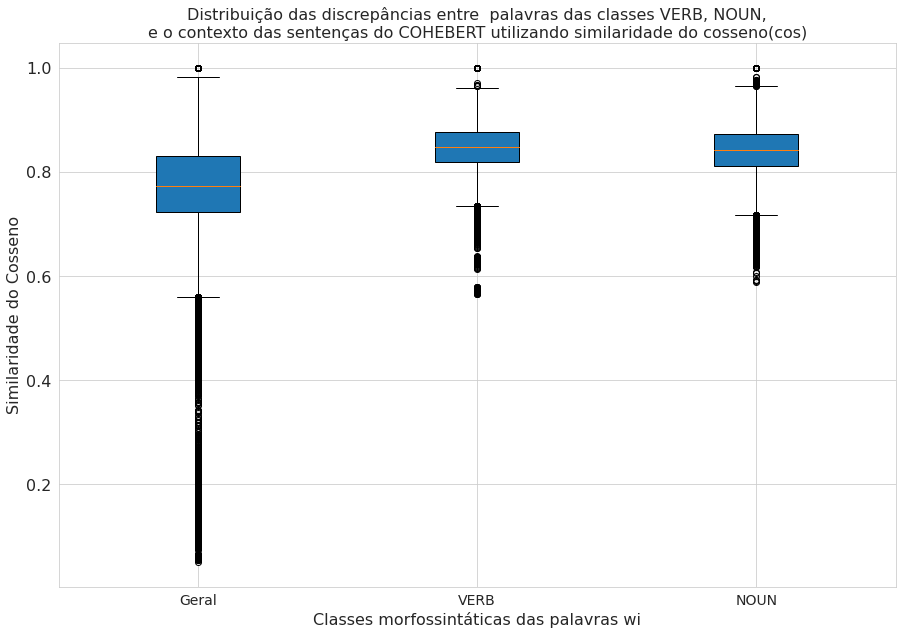

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count        980250.000000         94772.000000        227381.000000
mean             25.236321            23.296995            21.135618
std               4.942787             5.902103             3.562932
min               0.000000             0.000000             0.000000
25%              22.184616            20.509922            19.058023
50%              25.341820            23.199769            21.087414
75%              28.048344            26.408145            23.125341
max              54.625130            44.780048            44.897823

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


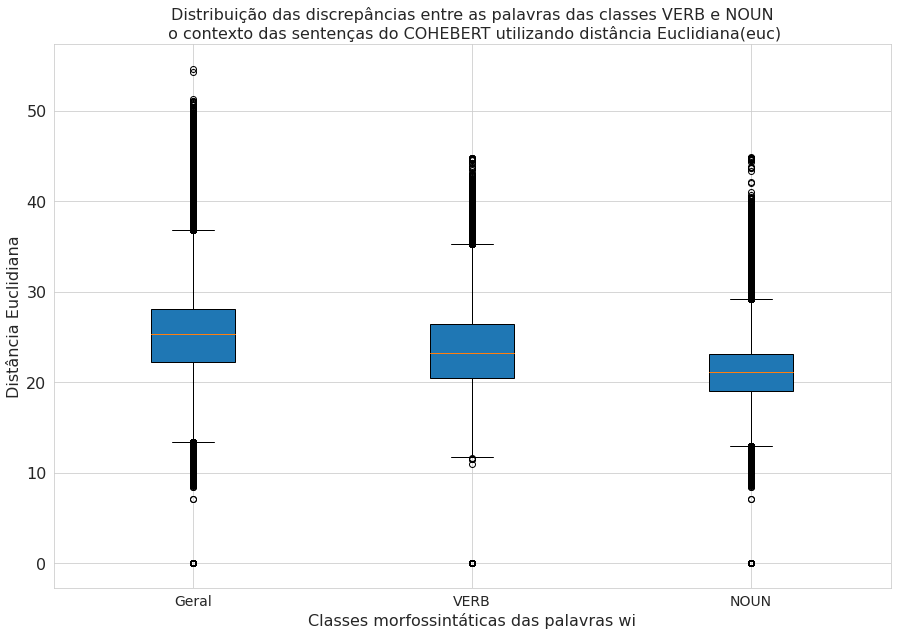

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count        980250.000000         94772.000000        227381.000000
mean           1204.724705          1087.148138           994.400948
std             231.861685           255.320942           161.556768
min               0.000000             0.000000             0.000000
25%            1055.286591           977.258896           901.303894
50%            1219.463379          1097.783142           992.113281
75%            1348.020630          1230.441986          1086.870483
max            2391.678955          2057.369873          2031.854004

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


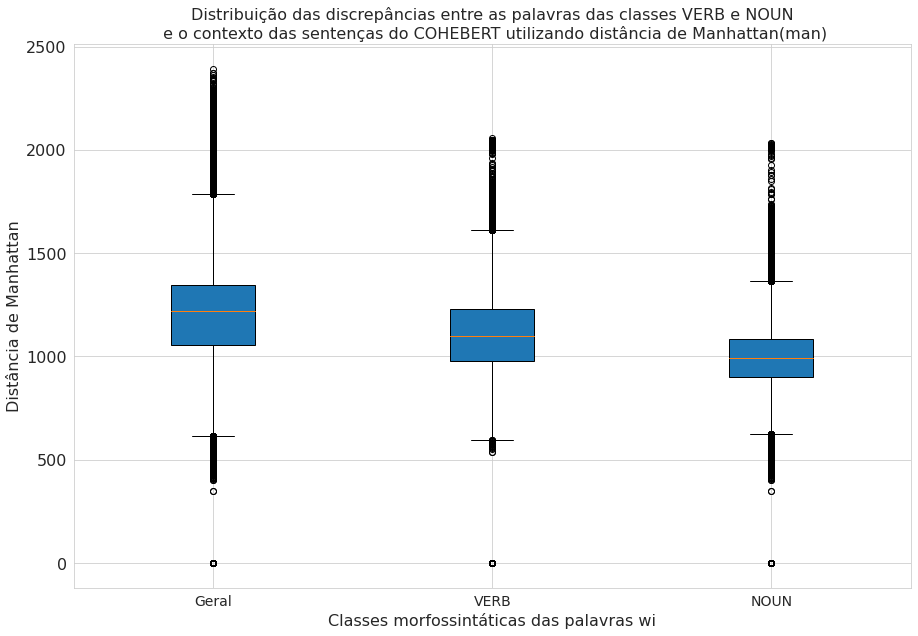

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:11:27 (h:mm:ss)
